# IMAGE COLORIZATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU,MaxPooling2D, UpSampling2D,
    Concatenate)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from time import time
from skimage.color import rgb2lab, lab2rgb


IMAGE_SIZE = 32
EPOCHS = 100
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100
WORKDIR ="/content/drive/MyDrive/IMCOLOR/results/"

In [ ]:
tf.random.set_seed(0)

In [ ]:
import tensorflow.keras as keras
(train_images, y_train), (test_images, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
print("train_images:", train_images.shape)
print("test_images:",test_images.shape)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)


In [ ]:
def generate_dataset(images):
    X = [] #lightness
    Y = [] #ab
    for i in images:
        img_lab = rgb2lab(i).astype("float32")
        x = img_lab[...,[0]] / 50. - 1. 
        y = img_lab[...,[1, 2]] / 110.
        
        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))
        Y.append(y)
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y,
def lab_to_rgb(L, ab): 
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab=tf.keras.layers.Concatenate()([L, ab])
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
X_train, Y_train = generate_dataset(train_images)
print(X_train.shape)
total_sample=X_train.shape[0]
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
print("data: ",train_data)
train_dataset = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

print("Batch: ",train_dataset)

(50000, 32, 32, 1)
data:  <TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 2), dtype=tf.float32, name=None))>
Batch:  <BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 2), dtype=tf.float32, name=None))>


In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
from math import log10
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity, mean_squared_error


def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid



def PSNR(y_true, y_pred):
    x,y,channel=y_true.shape
    mse=0
    for i in range(channel):
        mse=mse+mean_squared_error(y_true,y_pred)#np.mean((y_true[:,:,i] - y_pred[:,:,i]) ** 2)
    mse=mse/channel
    if(mse == 0):
        psnr=100
    else:
        max_pixel = 255.0
        psnr = 10 * log10((max_pixel**2) / mse)
    return psnr


def SSIM_ex(y_true,y_pred):
    return float(structural_similarity(y_true, y_pred, data_range=y_pred.max() - y_pred.min(),multichannel=True)*100)


## **Training module**

In [ ]:
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        model.add(BatchNormalization())

    model.add(LeakyReLU())
    return model


def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())
    return model


def generator_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

    # Downsampling layers
    # 1: (BATCH_SIZE, 16, 16, 32)
    # 2: (BATCH_SIZE, 8, 8, 64)
    # 3: (BATCH_SIZE, 4, 4, 128)
    # 4: (BATCH_SIZE, 2, 2, 256)
    # 5: (BATCH_SIZE, 1, 1, 256)

    downstack = [
        downsample(32, 4, apply_batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(256, 4)
    ]

    # Upsampling layers
    # 1: (BATCH_SIZE, 1, 1, 256)
    # 2: (BATCH_SIZE, 1, 1, 128)
    # 3: (BATCH_SIZE, 1, 1, 64)
    # 4: (BATCH_SIZE, 1, 1, 32)
    
    upstack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    initializer = tf.random_uniform_initializer(0, 0.02)
    output_layer = Conv2DTranspose(2, 3, strides=2, padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')
    
    x = inputs

    # Downsampling layers
    skips = []
    for dm in downstack:
        x = dm(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling layers
    for um, skip in zip(upstack, skips):
        x = um(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = output_layer(x)

    return Model(inputs=inputs, outputs=x)
generator = generator_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 32)   512         ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 8, 8, 64)     33024       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 4, 128)    131584      ['sequential_1[0][0]']           
                                                                                              

In [ ]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(.2))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [ ]:
LAMBDA = 100
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    #total_disc_loss=cross_entropy(disc_real_output, disc_generated_output)
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    #MAE
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator.compile(optimizer=generator_optimizer)
discriminator.compile(optimizer=discriminator_optimizer)

checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [ ]:
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    return gen_total_loss, disc_loss

In [ ]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("This")
    print('Restored from {}'.format(manager.latest_checkpoint))
else:
    print('Initializing from scratch')

Initializing from scratch


In [ ]:
def on_epoch_end(epoch,g_losses, d_losses, psnr, ssim):
        #clear_output(wait=True)
        N = np.arange(0, len(g_losses))
        
        # Plot generator_loss against epochs passed
        plt.figure()
        plt.plot(N, g_losses, label = "generator_loss")
        plt.title("Generator Loss [Epoch {}]".format(epoch+1))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        #plt.savefig('Epoch-{}.png'.format(epoch))
        plt.show()


        # Plot discriminator_loss against epochs passed
        plt.figure()
        plt.plot(N, d_losses, label = "discriminator_loss")
        plt.title("Discriminator Loss [Epoch {}]".format(epoch+1))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        #plt.savefig('Epoch-{}.png'.format(epoch))
        plt.show()



        
        # Plot psnr against epochs passed
        plt.figure()
        plt.plot(N, psnr, label = "psnr")
        plt.title("PSNR CGAN [Epoch {}]".format(epoch+1))
        plt.xlabel("Epoch #")
        plt.ylabel("Similarity")
        plt.legend()
        #plt.savefig('Epoch-{}.png'.format(epoch))
        plt.show()

        # Plot ssim against epochs passed
        plt.figure()
        plt.plot(N, ssim, label = "ssim")
        plt.title("SSIM CGAN [Epoch {}]".format(epoch+1))
        plt.xlabel("Epoch #")
        plt.ylabel("Similarity")
        plt.legend()
        #plt.savefig('Epoch-{}.png'.format(epoch))
        plt.show()


        plt.close()

Training Started


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 899 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 425 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 729 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 452 pixels
  re

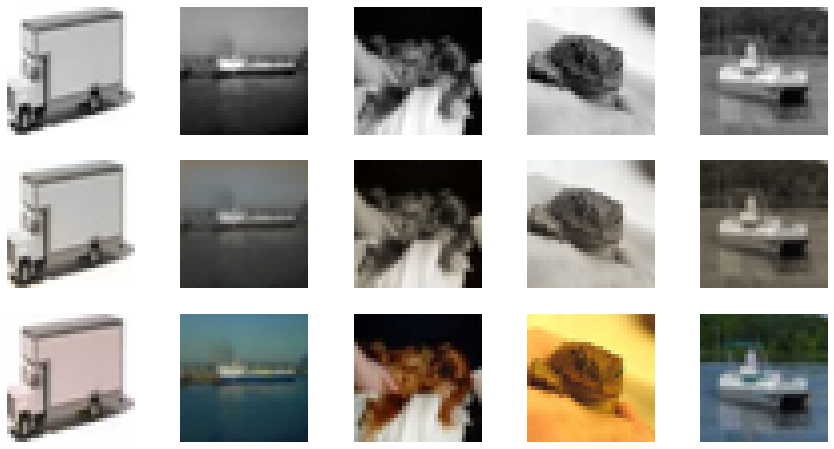

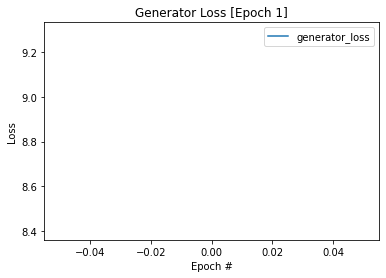

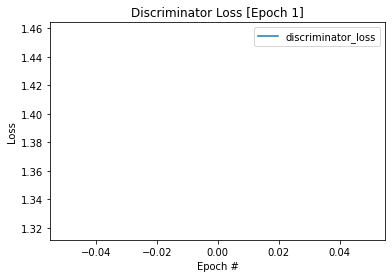

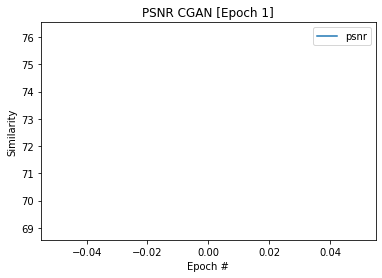

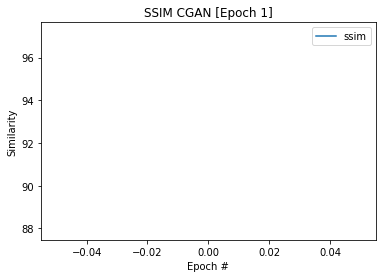

Epoch 1: gen loss: 8.84701919555664, disc loss: 1.3878828287124634, PSNR 72.55090125538707, SSIM 92.55615836505882, time: 231.87s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


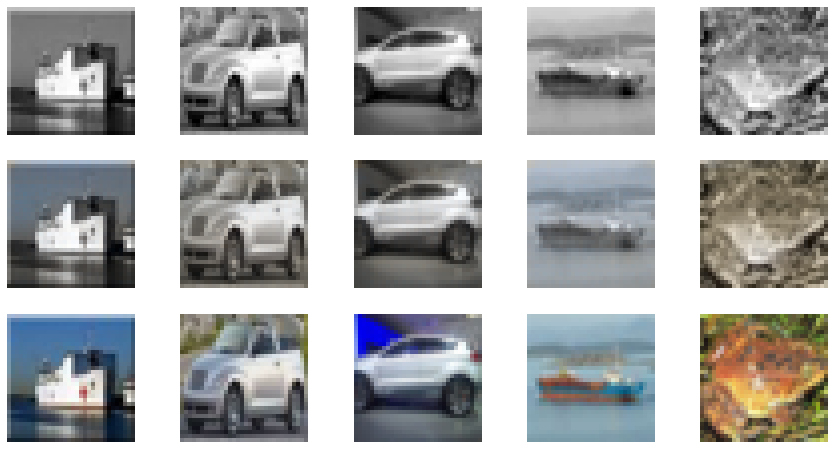

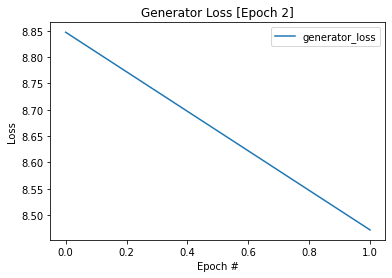

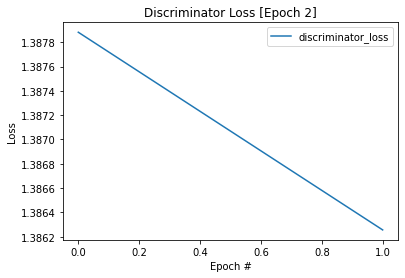

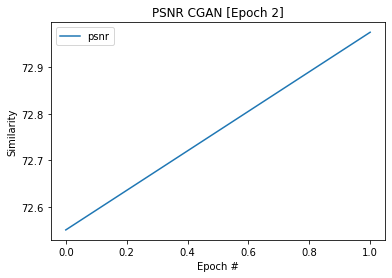

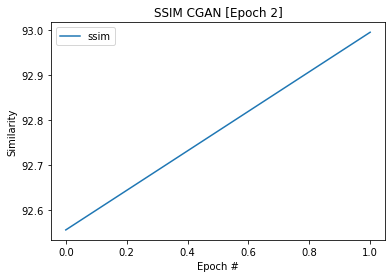

Epoch 2: gen loss: 8.472013473510742, disc loss: 1.3862557411193848, PSNR 72.97546068403692, SSIM 92.994283269523, time: 220.11s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


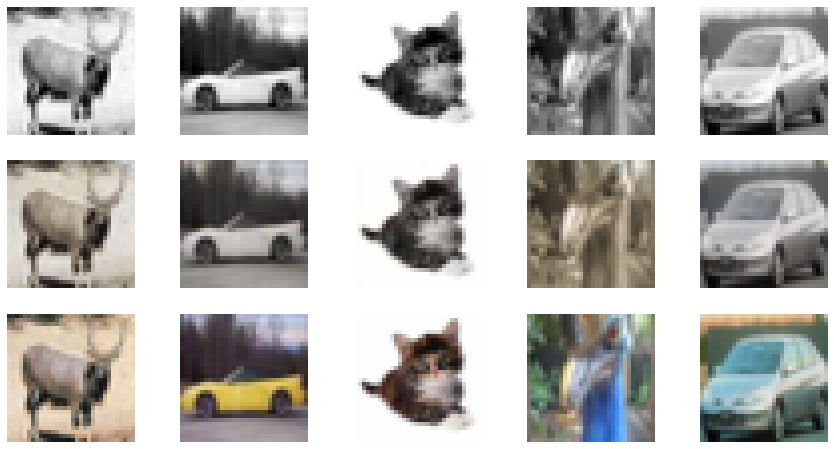

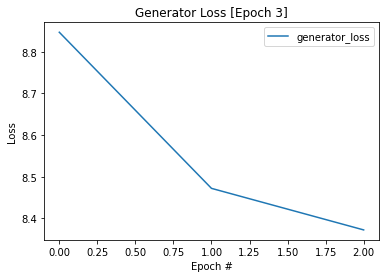

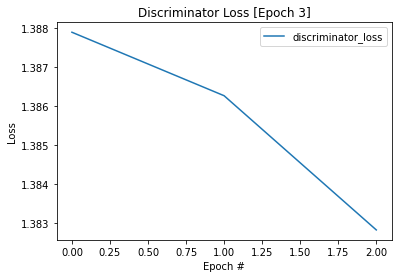

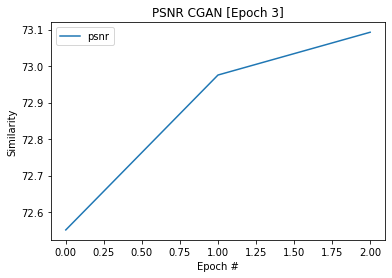

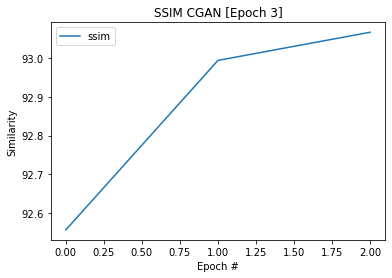

Epoch 3: gen loss: 8.3721923828125, disc loss: 1.382815957069397, PSNR 73.09275098434514, SSIM 93.06705240583908, time: 217.72s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


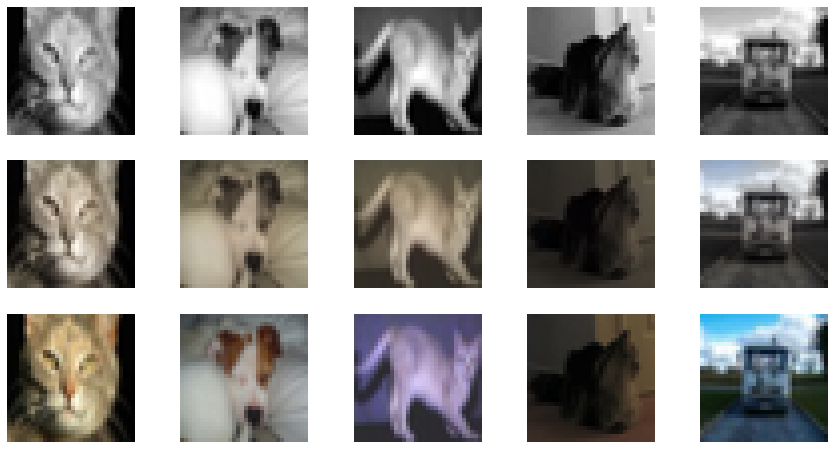

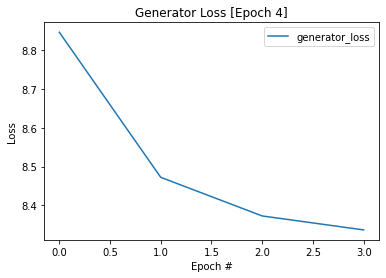

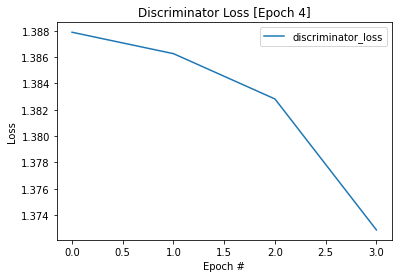

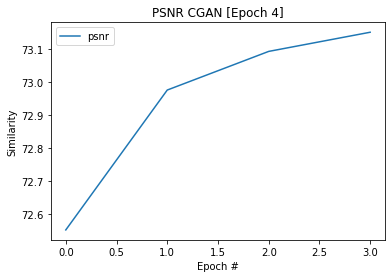

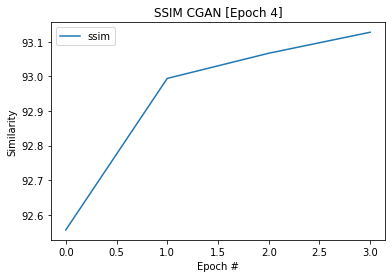

Epoch 4: gen loss: 8.3361177444458, disc loss: 1.3728712797164917, PSNR 73.15090390763169, SSIM 93.12780306949796, time: 217.32s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


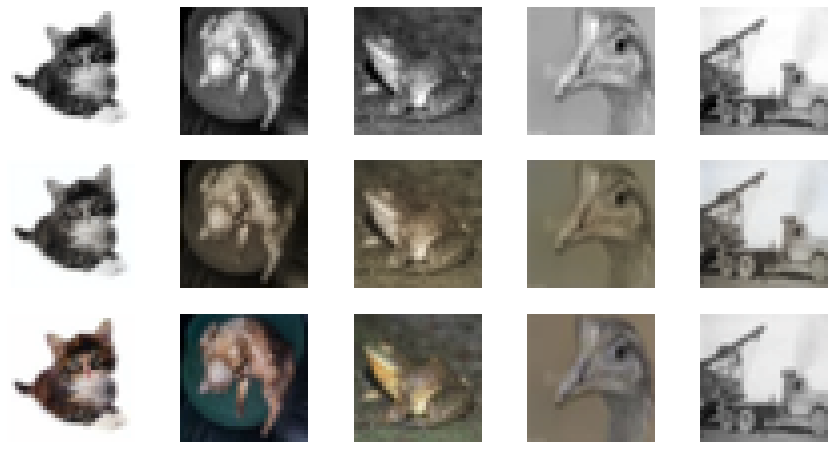

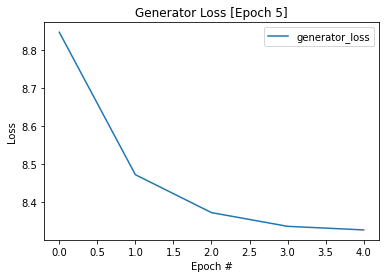

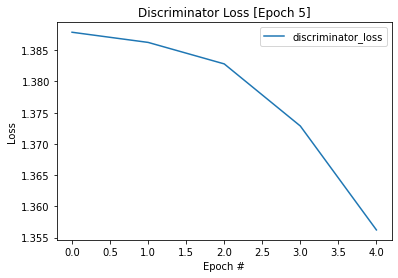

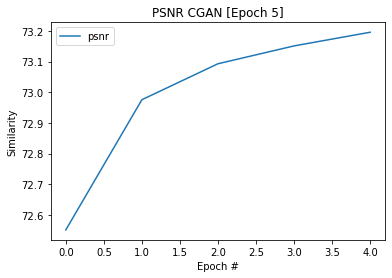

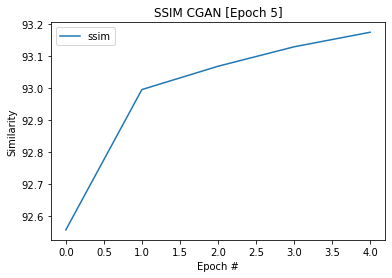

Epoch 5: gen loss: 8.32664680480957, disc loss: 1.3562365770339966, PSNR 73.19546183538704, SSIM 93.17326175330527, time: 216.49s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


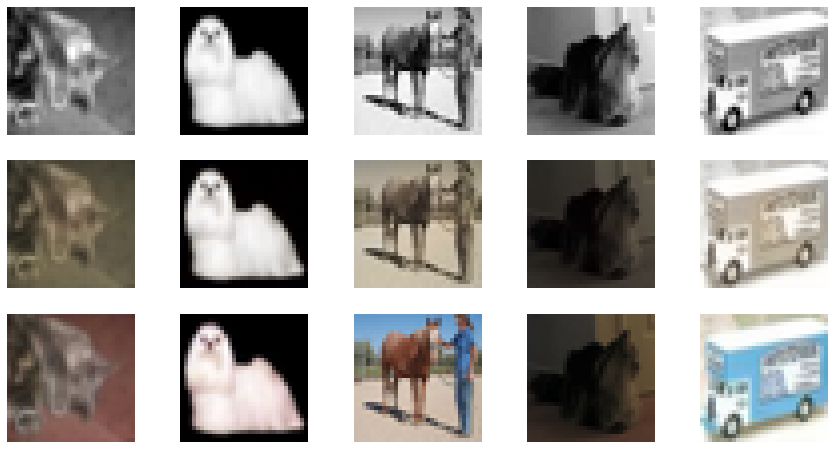

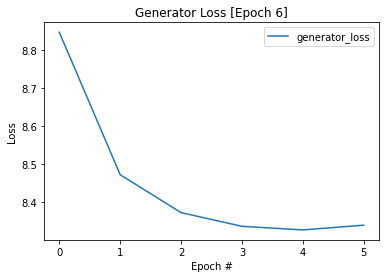

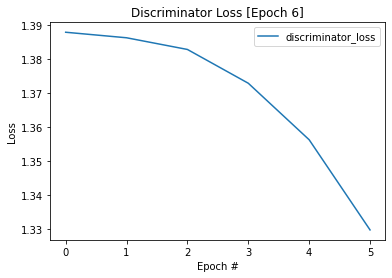

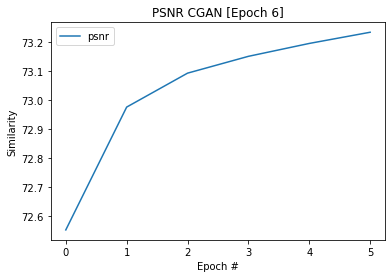

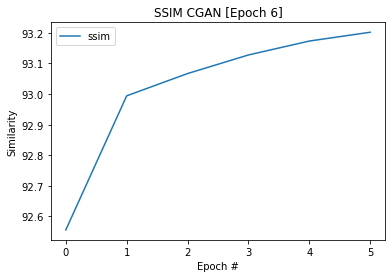

Epoch 6: gen loss: 8.33907413482666, disc loss: 1.3296985626220703, PSNR 73.2341541797043, SSIM 93.20205545324424, time: 218.31s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


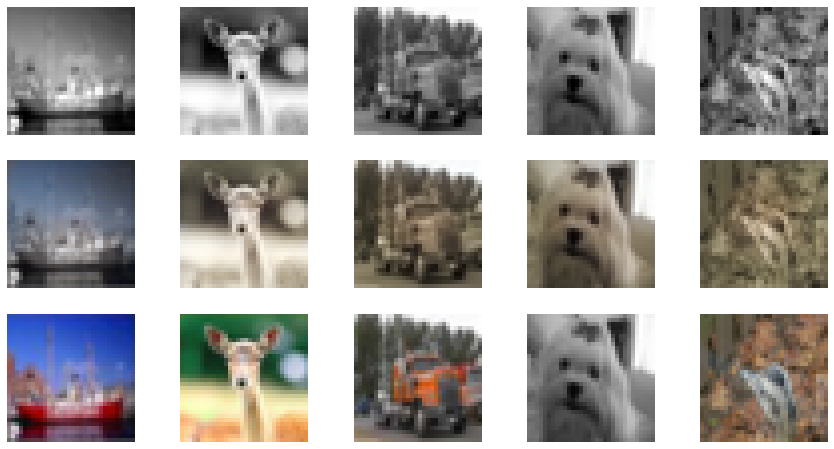

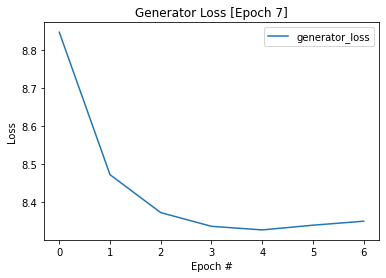

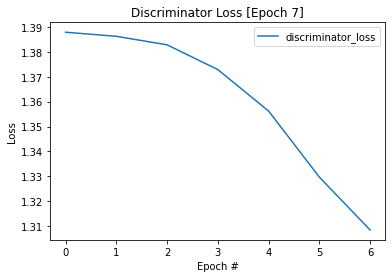

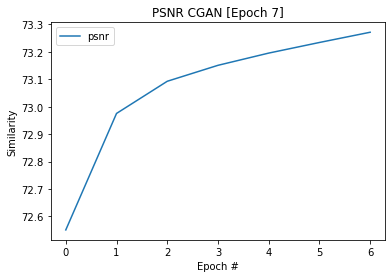

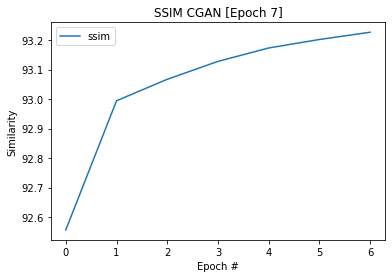

Epoch 7: gen loss: 8.349542617797852, disc loss: 1.3084512948989868, PSNR 73.27146807057696, SSIM 93.22664021212505, time: 216.71s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


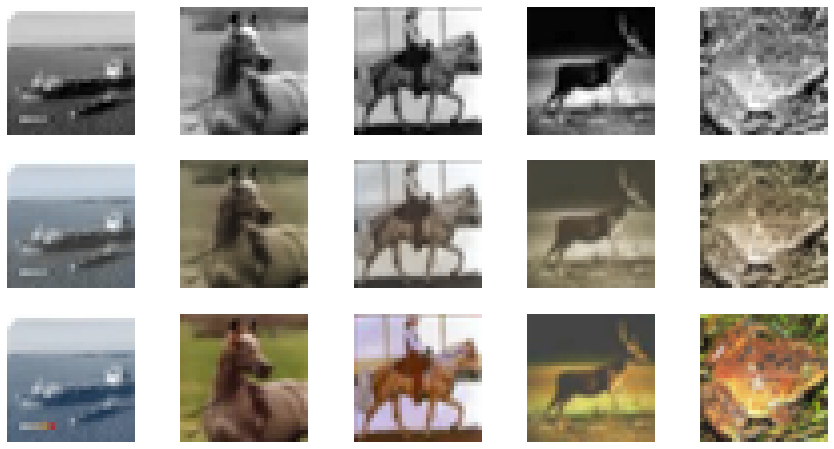

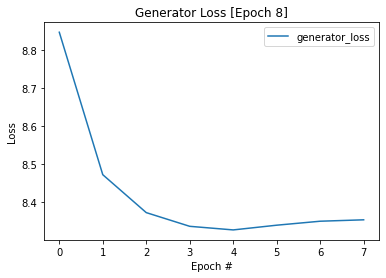

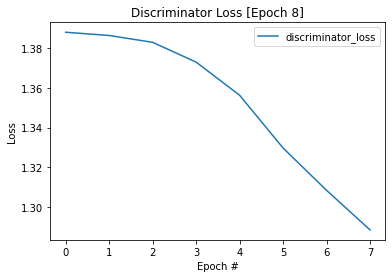

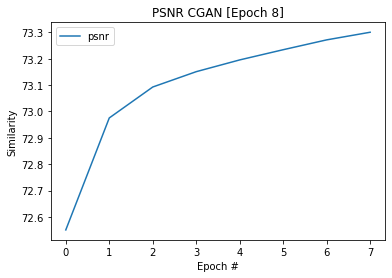

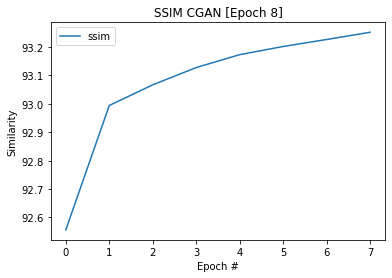

Epoch 8: gen loss: 8.353240013122559, disc loss: 1.2885500192642212, PSNR 73.30037710557404, SSIM 93.25214973838101, time: 217.71s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


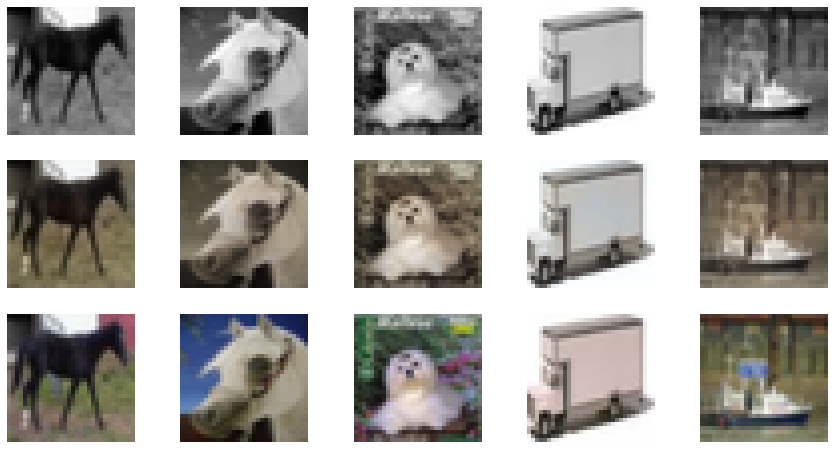

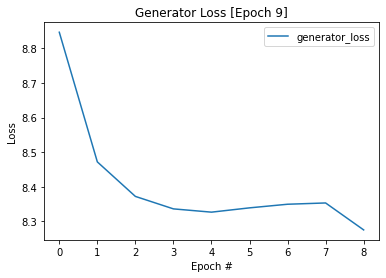

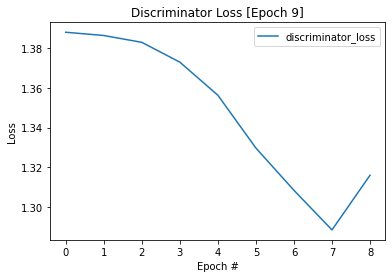

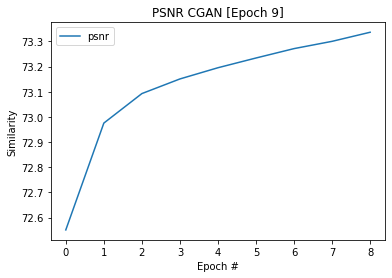

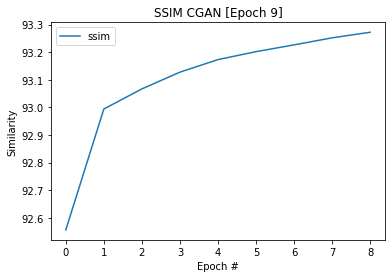

Epoch 9: gen loss: 8.27527904510498, disc loss: 1.316020131111145, PSNR 73.33648651039972, SSIM 93.27239441985333, time: 217.26s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


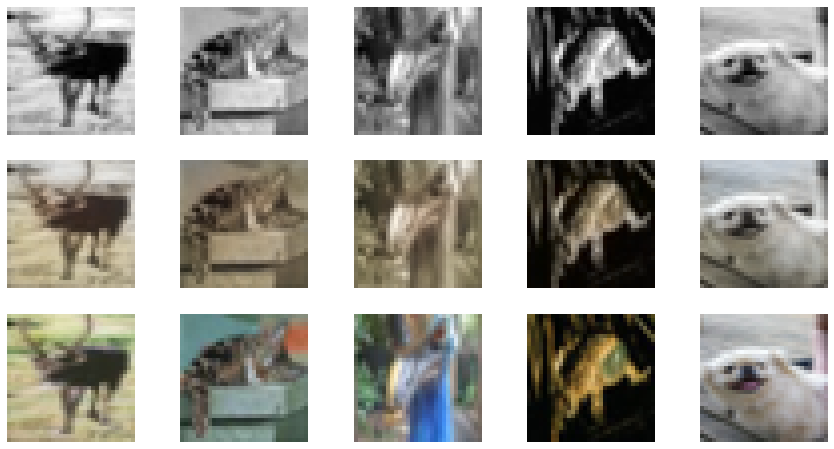

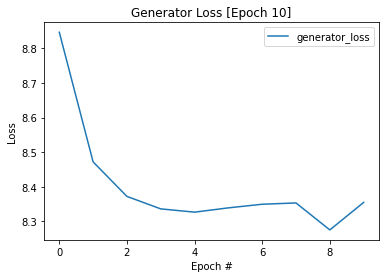

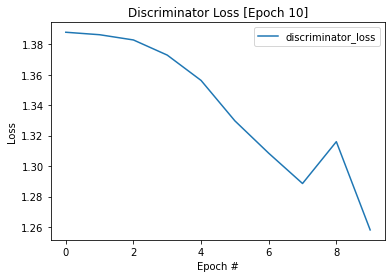

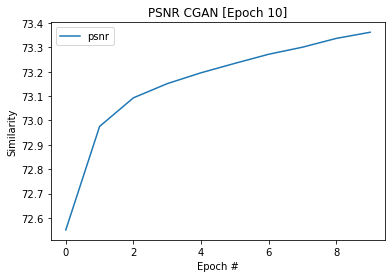

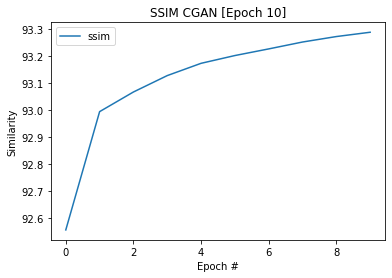

Epoch 10: gen loss: 8.354849815368652, disc loss: 1.2580703496932983, PSNR 73.36171233173637, SSIM 93.28836754206445, time: 216.50s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


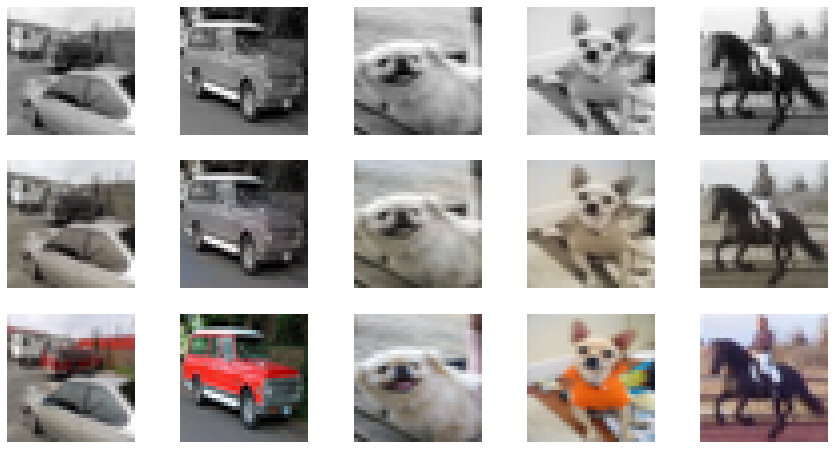

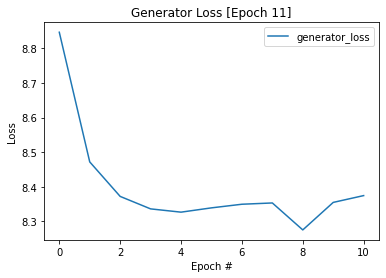

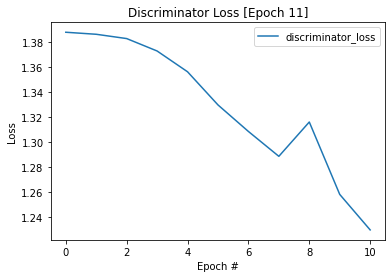

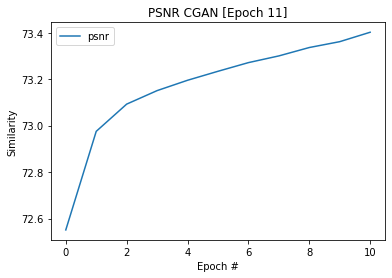

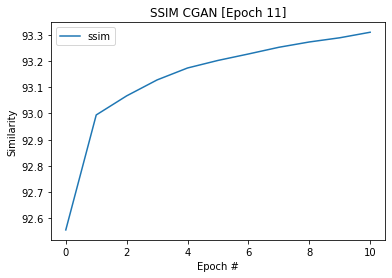

Epoch 11: gen loss: 8.374554634094238, disc loss: 1.2296310663223267, PSNR 73.40231248583673, SSIM 93.3094847332329, time: 217.28s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


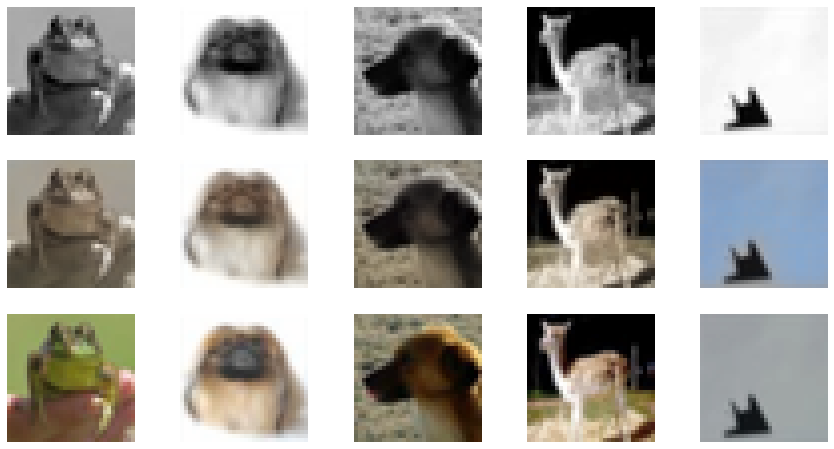

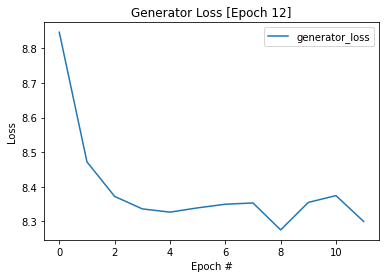

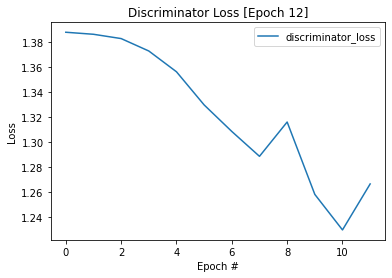

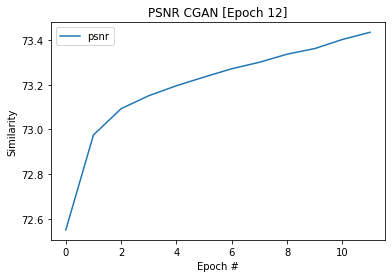

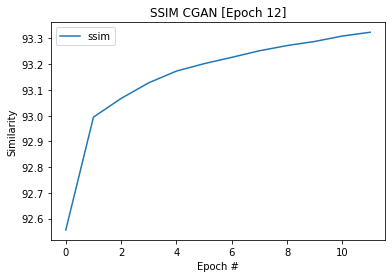

Epoch 12: gen loss: 8.299666404724121, disc loss: 1.2664400339126587, PSNR 73.43452876646975, SSIM 93.32412272749676, time: 215.73s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


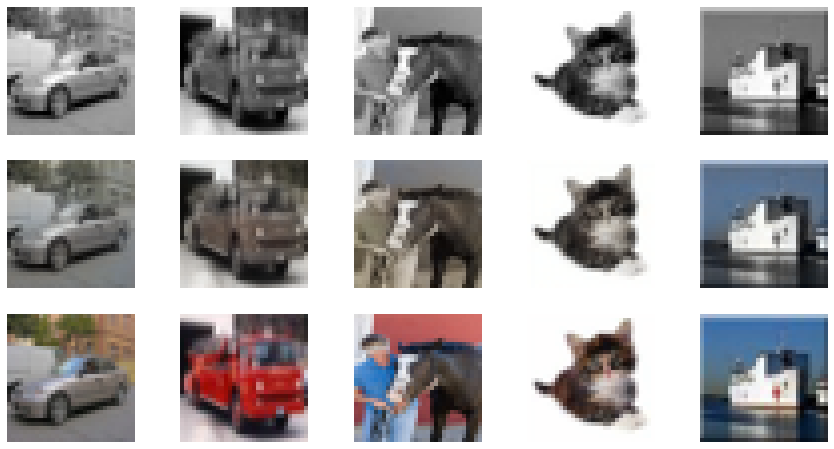

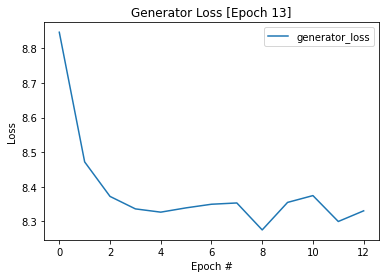

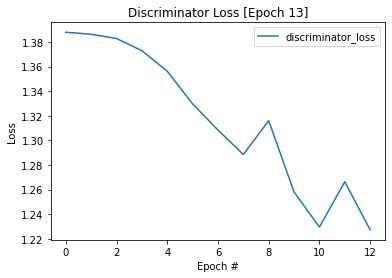

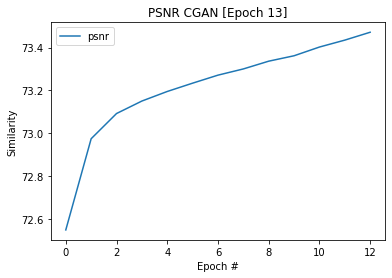

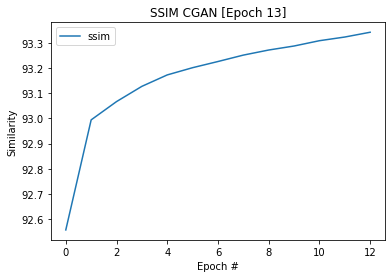

Epoch 13: gen loss: 8.33050537109375, disc loss: 1.2272907495498657, PSNR 73.47121304327298, SSIM 93.3431675944923, time: 215.72s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


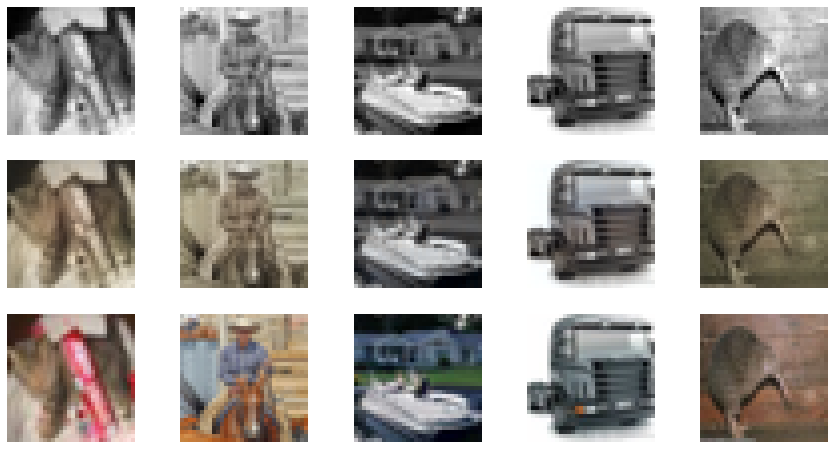

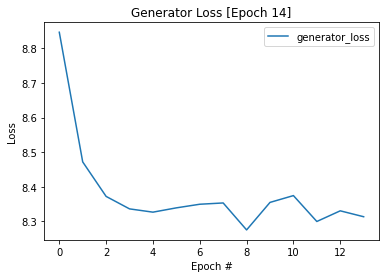

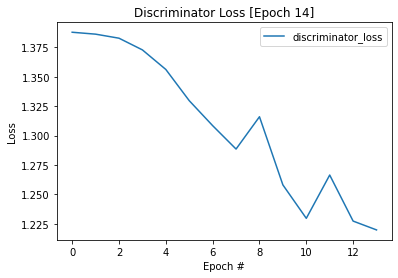

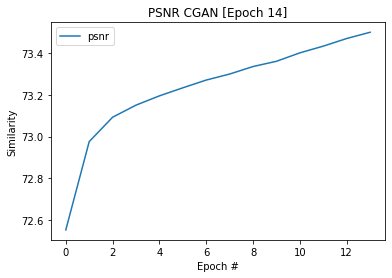

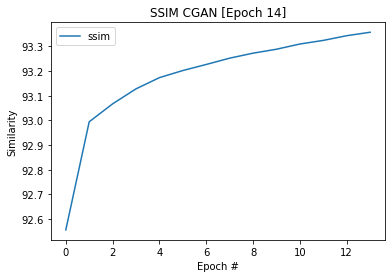

Epoch 14: gen loss: 8.313421249389648, disc loss: 1.2197808027267456, PSNR 73.50128842332269, SSIM 93.35715363511056, time: 216.18s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


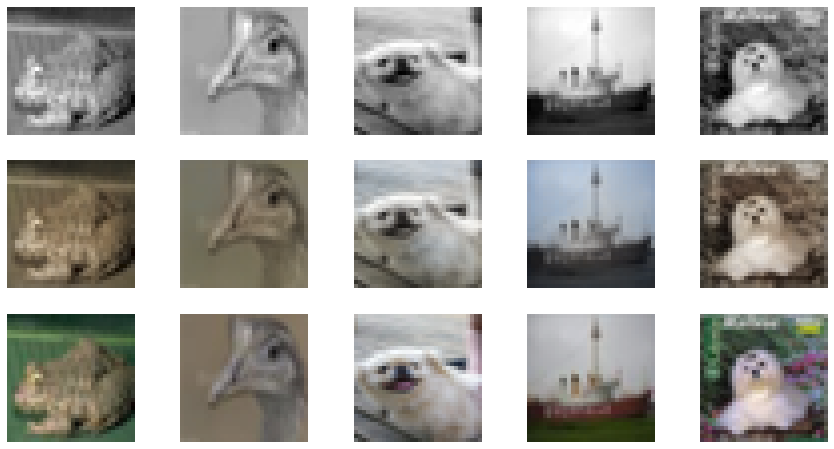

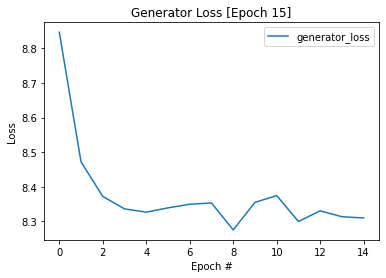

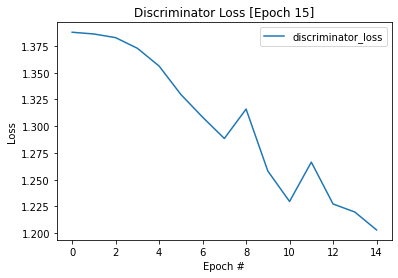

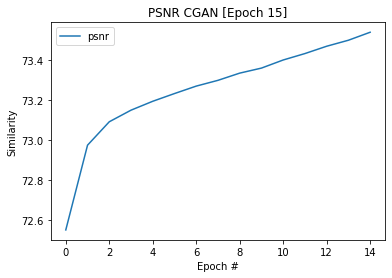

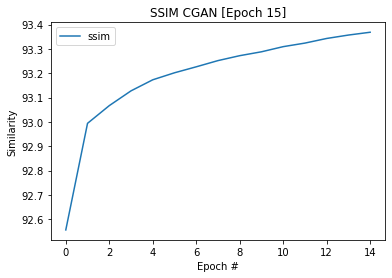

Epoch 15: gen loss: 8.309829711914062, disc loss: 1.2030330896377563, PSNR 73.54132748785368, SSIM 93.36872379263234, time: 217.32s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


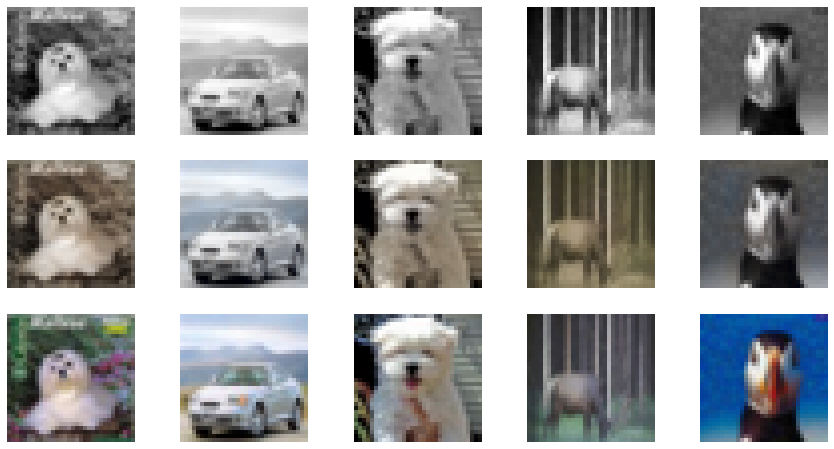

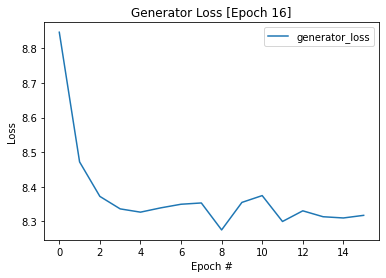

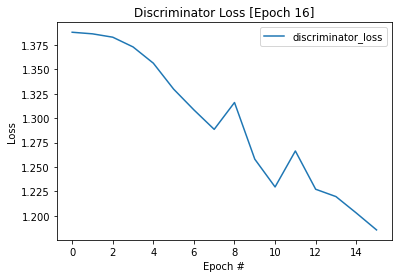

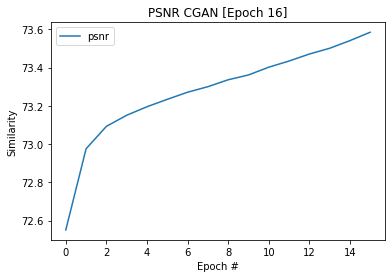

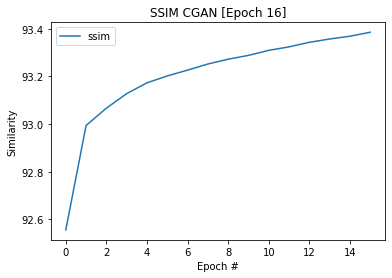

Epoch 16: gen loss: 8.317425727844238, disc loss: 1.1856831312179565, PSNR 73.58532403464513, SSIM 93.38548326390928, time: 217.95s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


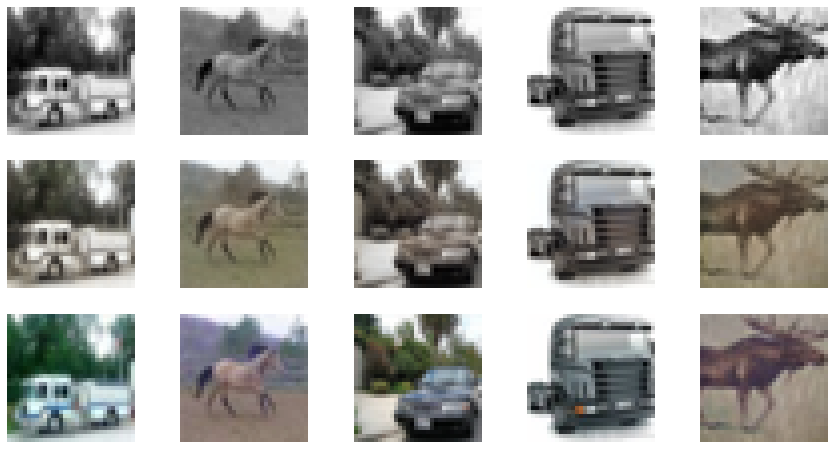

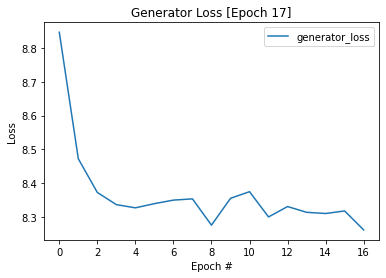

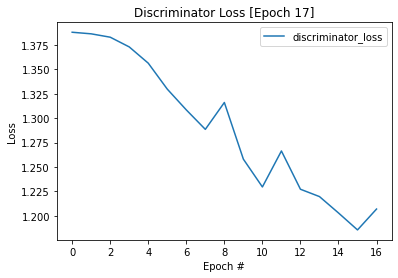

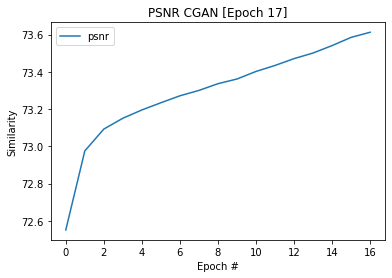

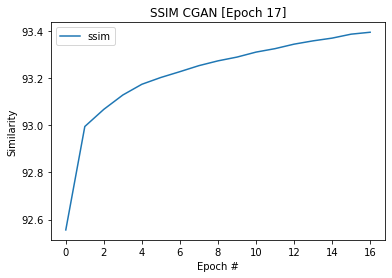

Epoch 17: gen loss: 8.261209487915039, disc loss: 1.2070281505584717, PSNR 73.61288135823648, SSIM 93.39361813551346, time: 217.28s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


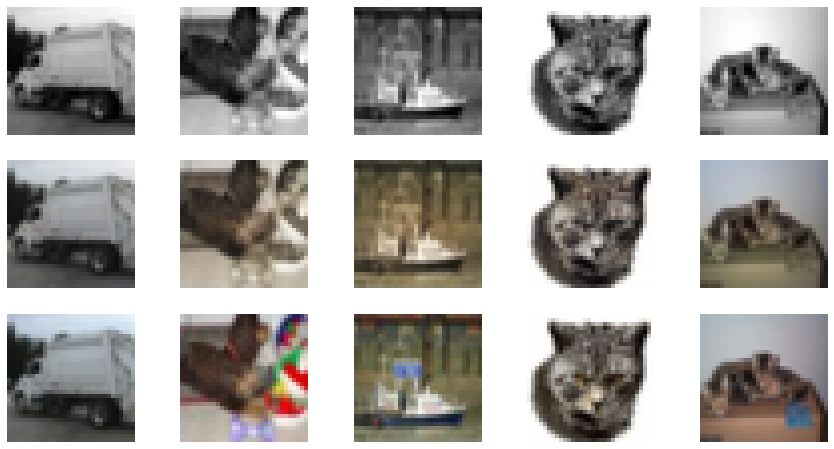

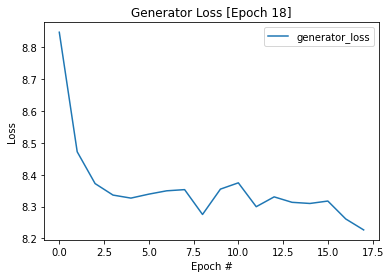

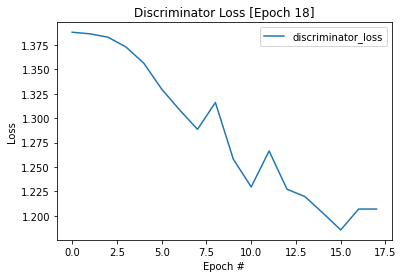

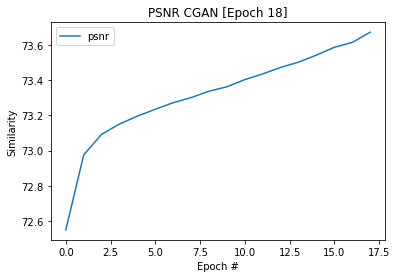

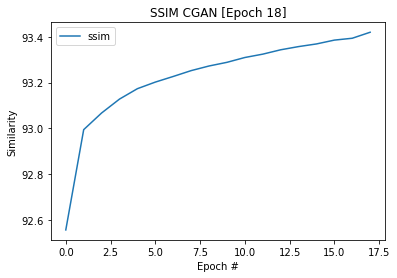

Epoch 18: gen loss: 8.226835250854492, disc loss: 1.207032561302185, PSNR 73.67060478858527, SSIM 93.41985670028235, time: 217.97s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


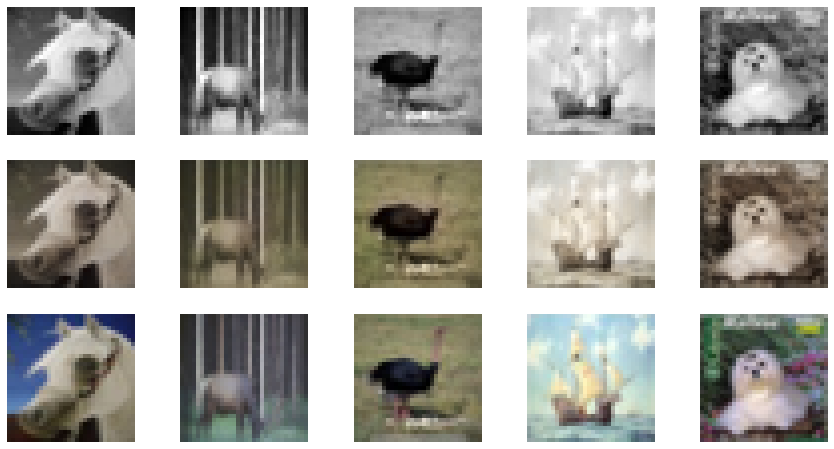

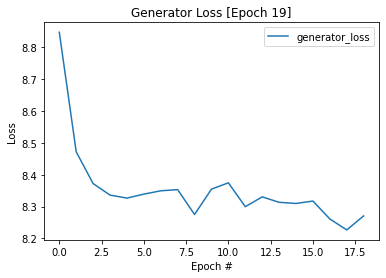

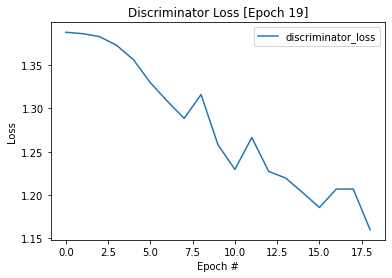

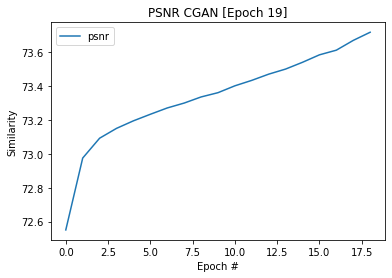

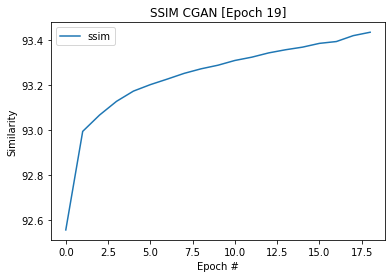

Epoch 19: gen loss: 8.27082347869873, disc loss: 1.1598578691482544, PSNR 73.71881932581239, SSIM 93.43496569758358, time: 215.67s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


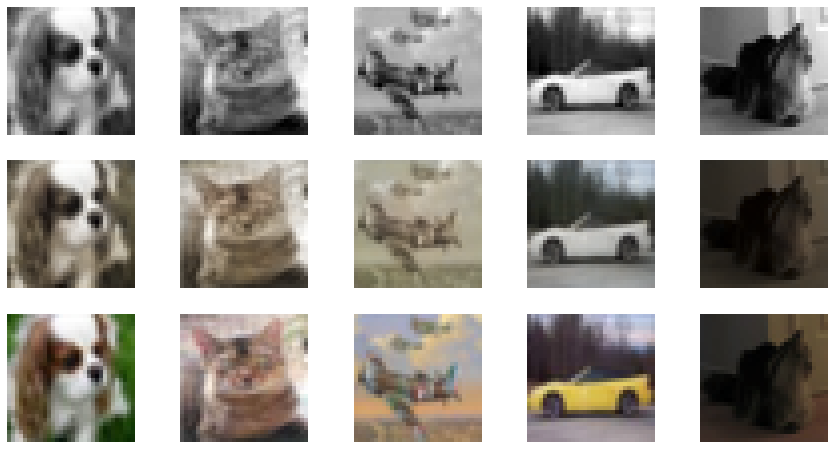

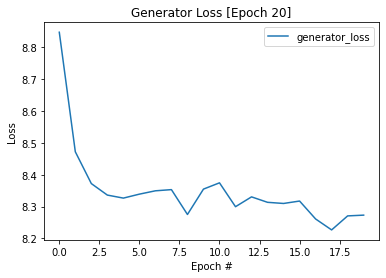

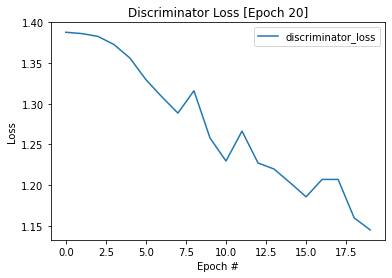

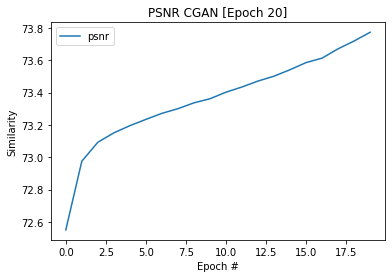

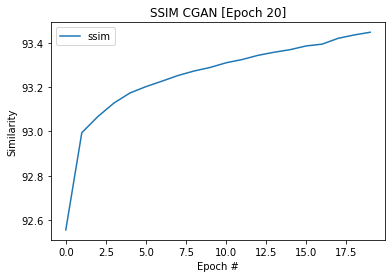

Epoch 20: gen loss: 8.273193359375, disc loss: 1.1449971199035645, PSNR 73.77291340879526, SSIM 93.44730414969996, time: 216.26s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


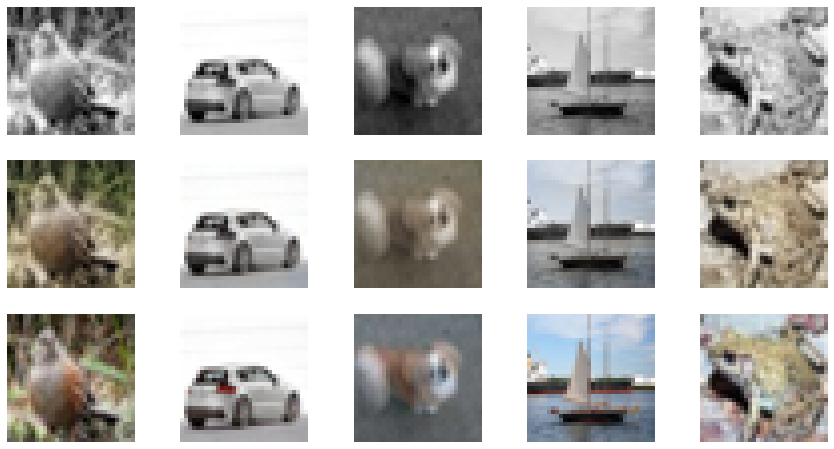

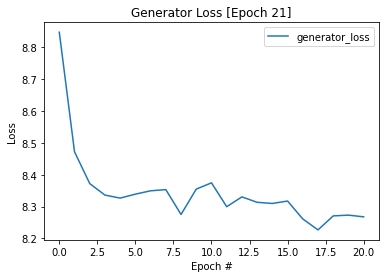

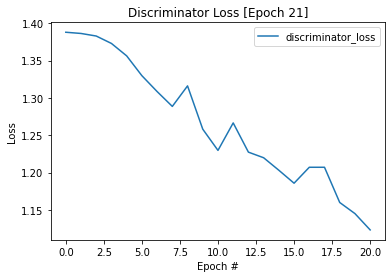

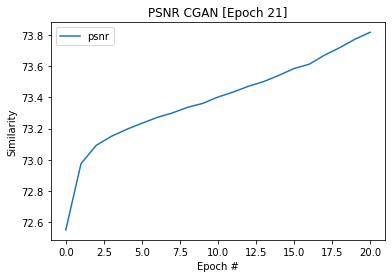

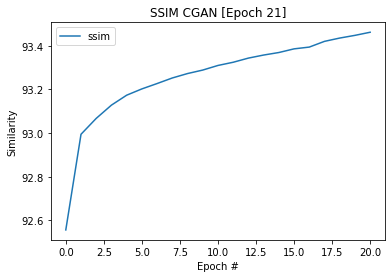

Epoch 21: gen loss: 8.26788330078125, disc loss: 1.1231228113174438, PSNR 73.81758947113742, SSIM 93.46159522017805, time: 216.90s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


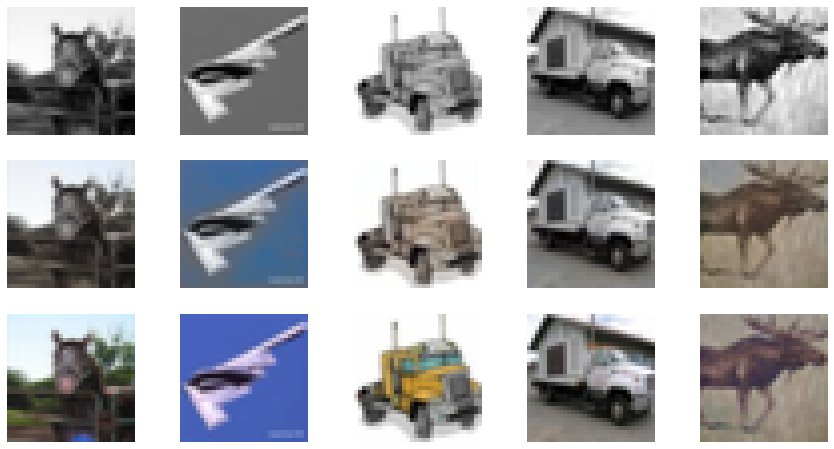

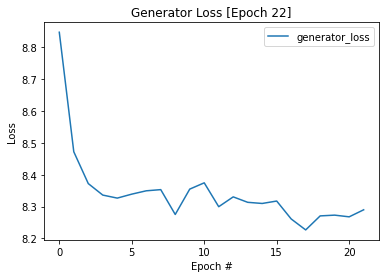

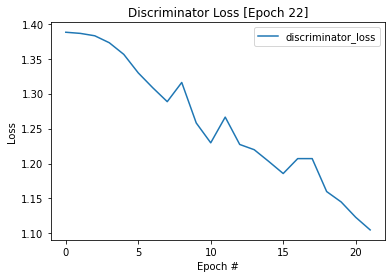

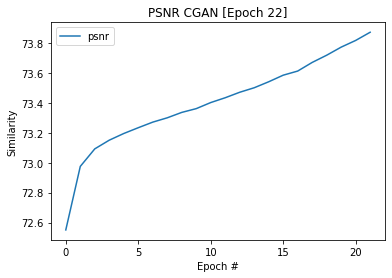

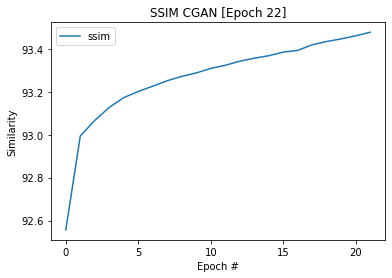

Epoch 22: gen loss: 8.289965629577637, disc loss: 1.1049907207489014, PSNR 73.87241307793843, SSIM 93.47829748303265, time: 218.48s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


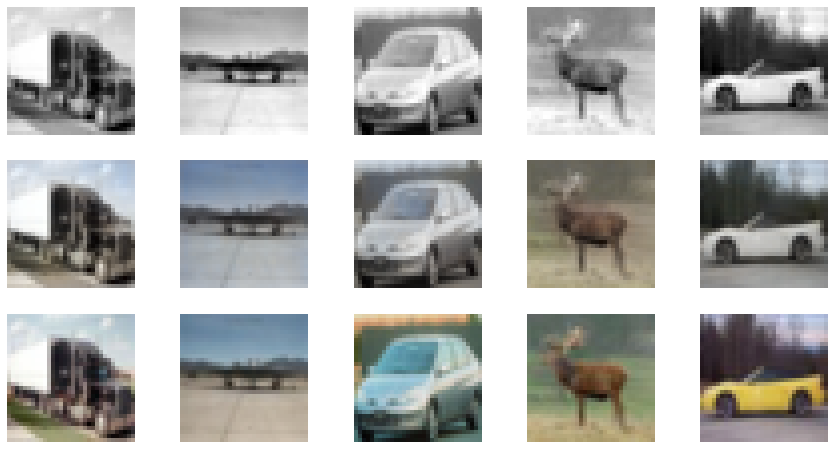

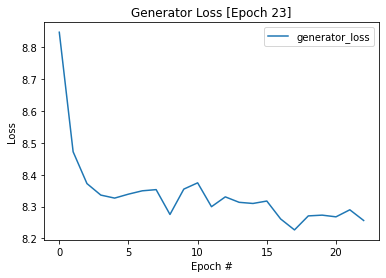

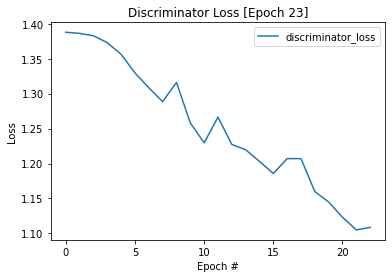

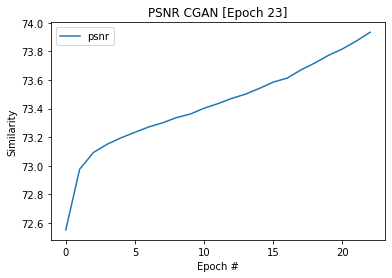

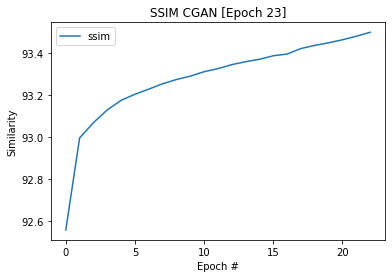

Epoch 23: gen loss: 8.25641918182373, disc loss: 1.1085947751998901, PSNR 73.93396081760042, SSIM 93.49740626915936, time: 217.70s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


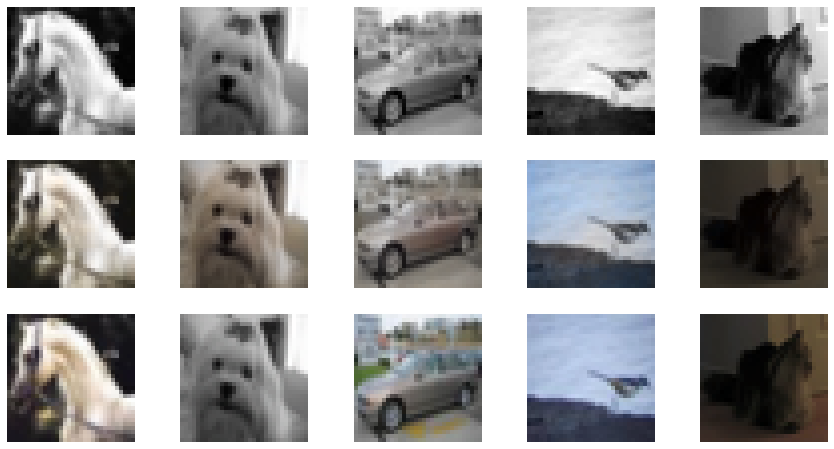

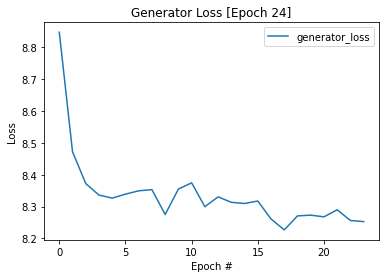

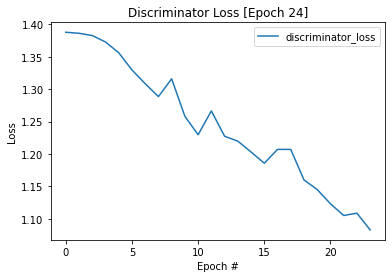

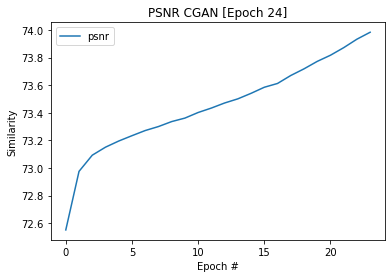

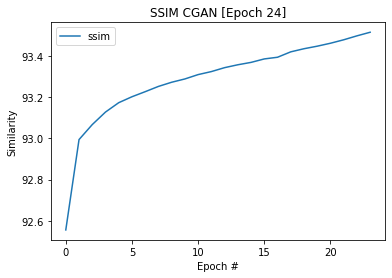

Epoch 24: gen loss: 8.252820014953613, disc loss: 1.0827345848083496, PSNR 73.9842877566476, SSIM 93.51491718311581, time: 218.08s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


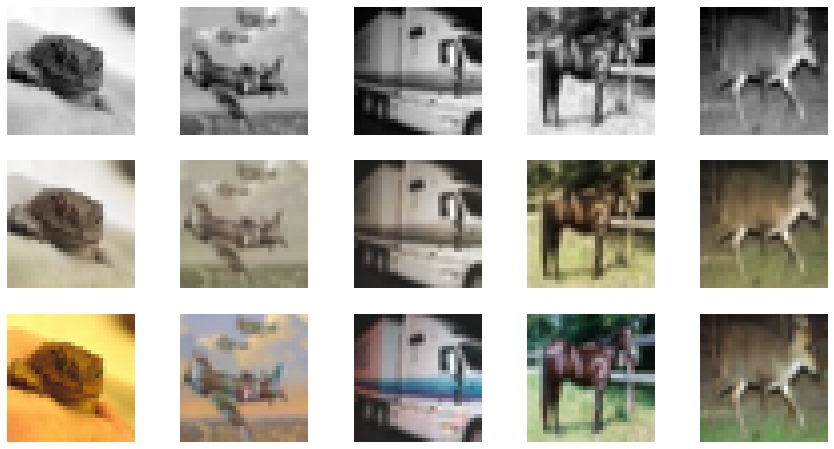

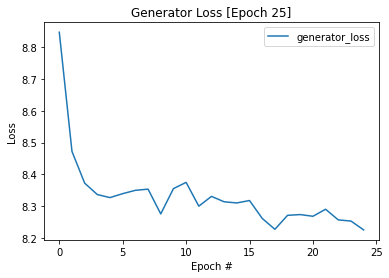

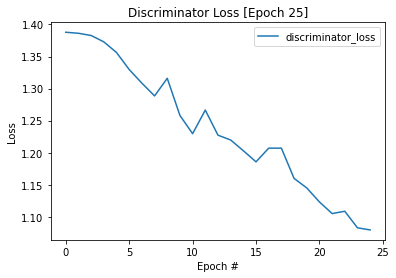

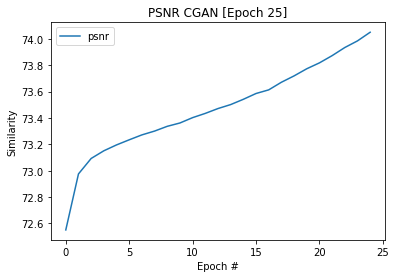

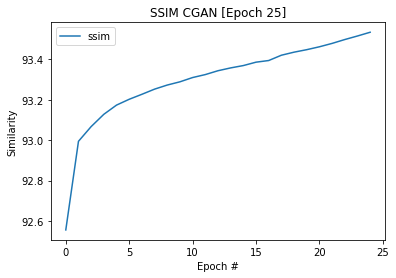

Epoch 25: gen loss: 8.22492790222168, disc loss: 1.079477071762085, PSNR 74.04984666299603, SSIM 93.5334596534719, time: 217.30s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


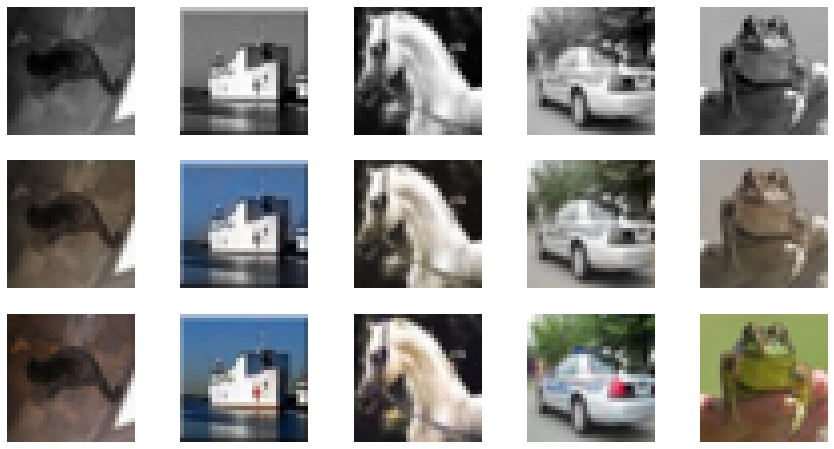

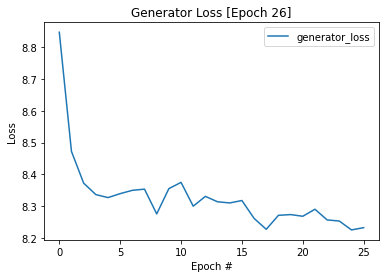

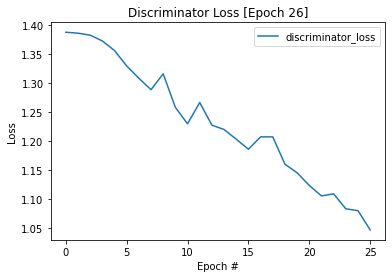

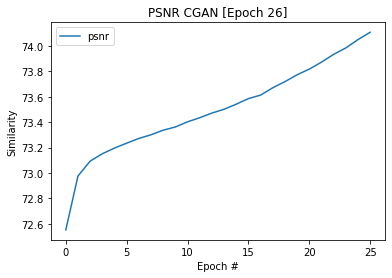

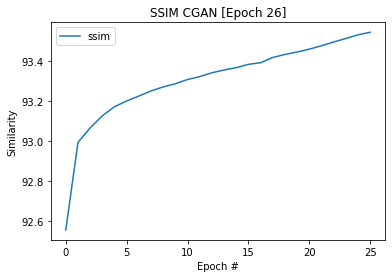

Epoch 26: gen loss: 8.232030868530273, disc loss: 1.0462281703948975, PSNR 74.10801439152085, SSIM 93.54626422963972, time: 218.77s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


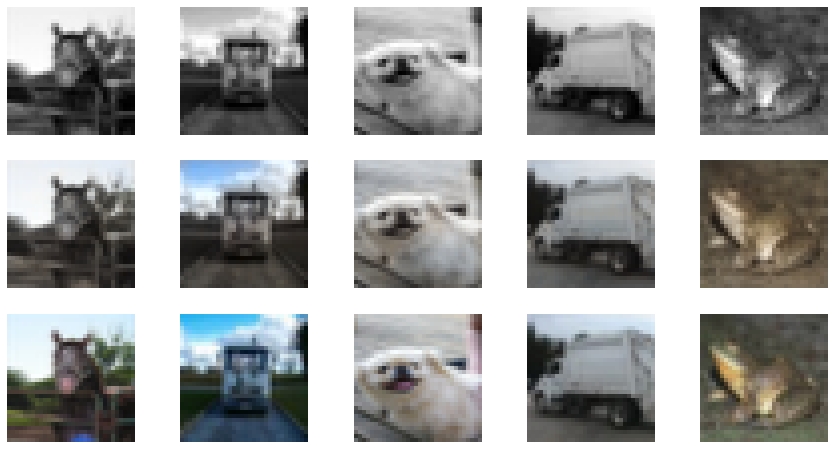

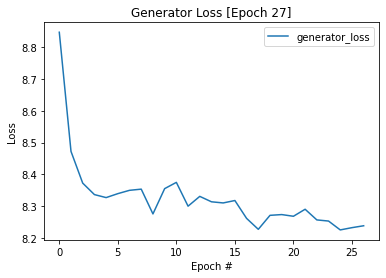

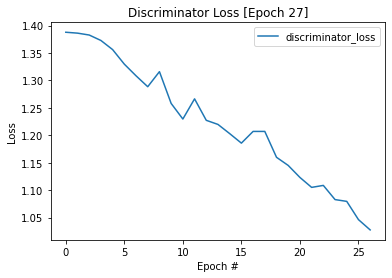

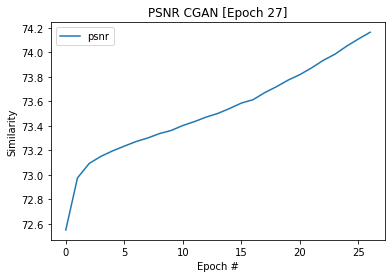

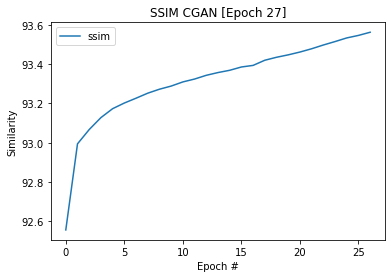

Epoch 27: gen loss: 8.238001823425293, disc loss: 1.0274291038513184, PSNR 74.16284622787741, SSIM 93.56239091901278, time: 217.67s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


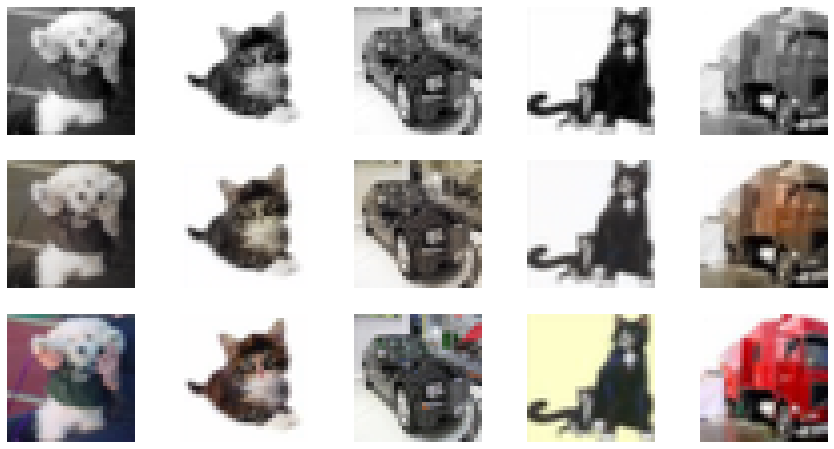

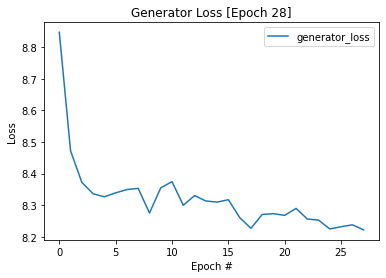

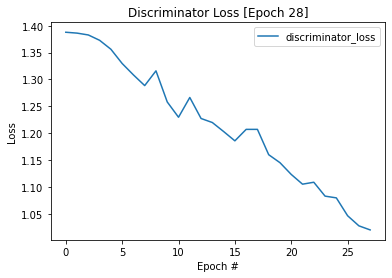

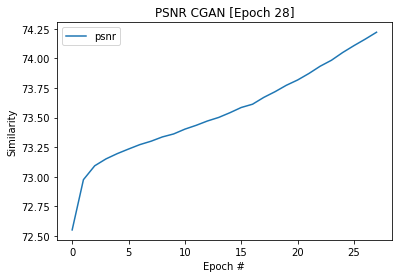

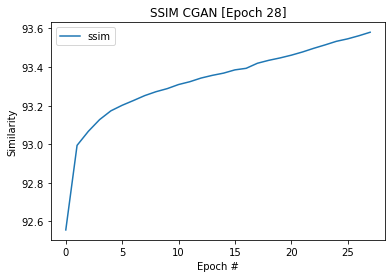

Epoch 28: gen loss: 8.221891403198242, disc loss: 1.0198242664337158, PSNR 74.2209855407505, SSIM 93.58055132706676, time: 216.83s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


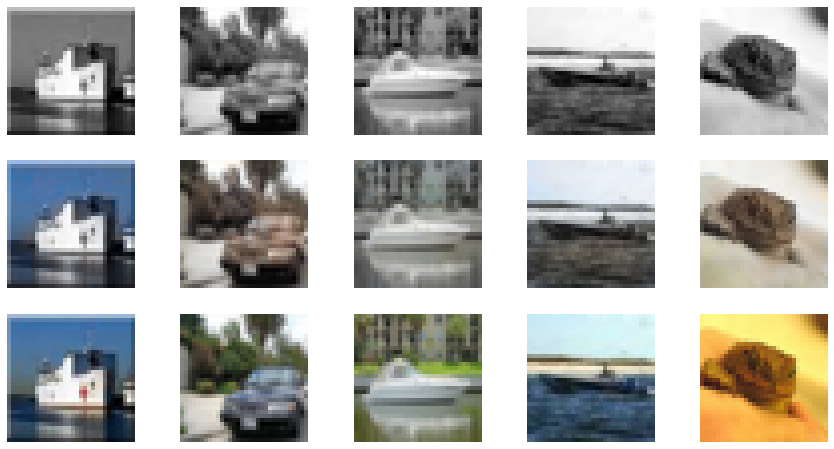

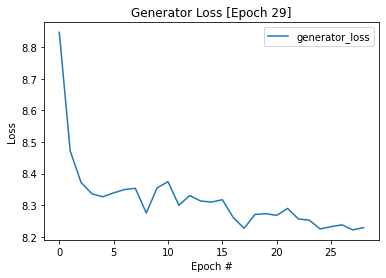

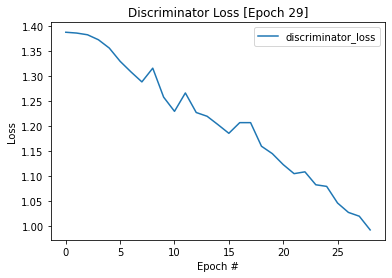

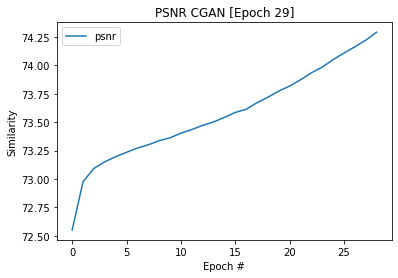

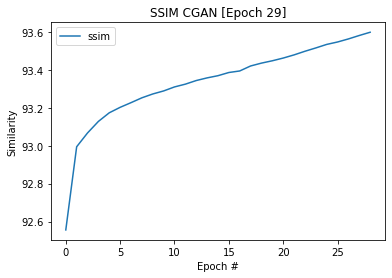

Epoch 29: gen loss: 8.229119300842285, disc loss: 0.9924112558364868, PSNR 74.29142303010478, SSIM 93.59762049466784, time: 217.97s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


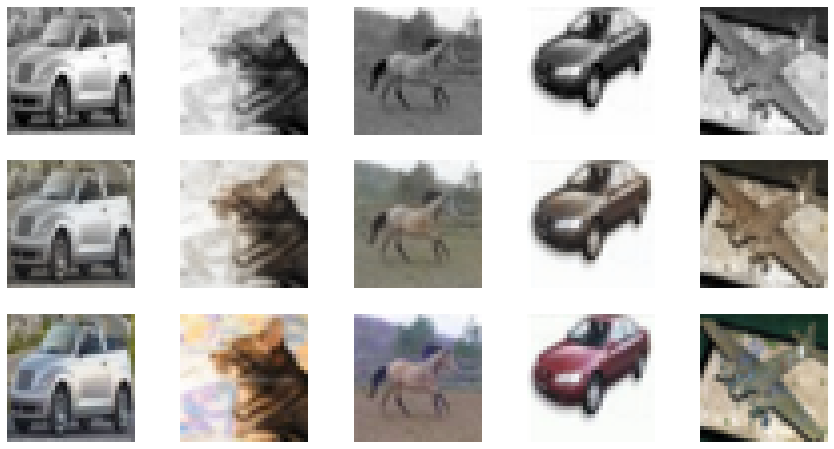

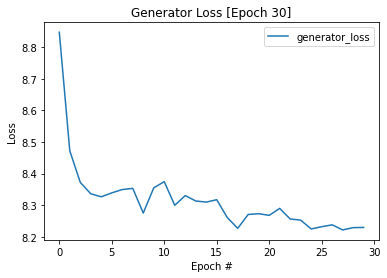

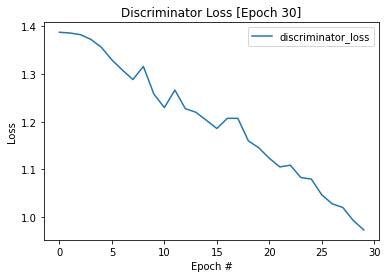

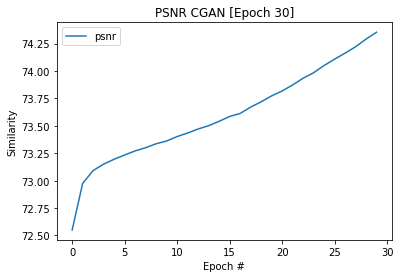

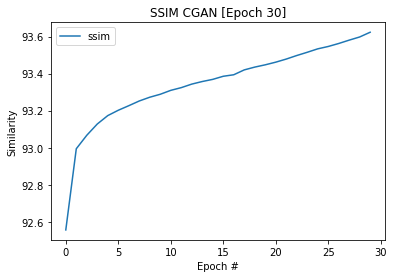

Epoch 30: gen loss: 8.229721069335938, disc loss: 0.9726577997207642, PSNR 74.35363566272669, SSIM 93.6231711230974, time: 217.69s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


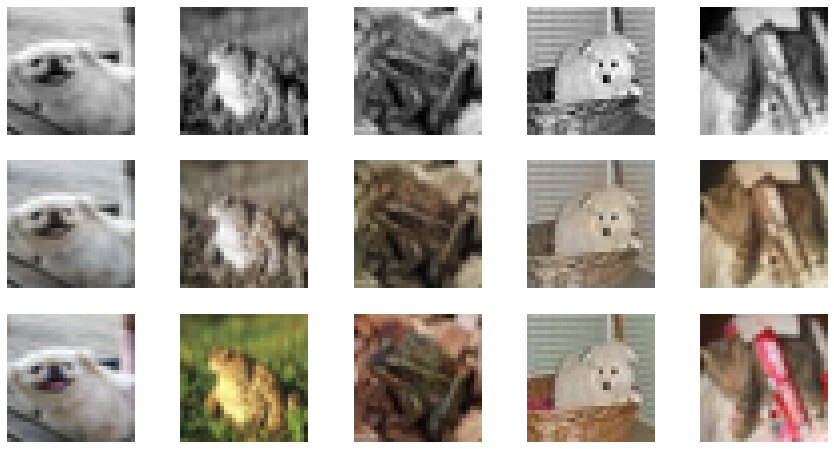

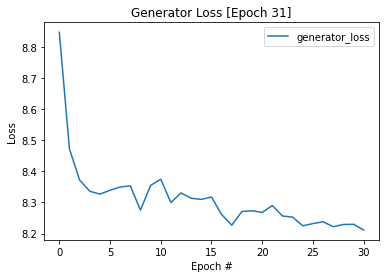

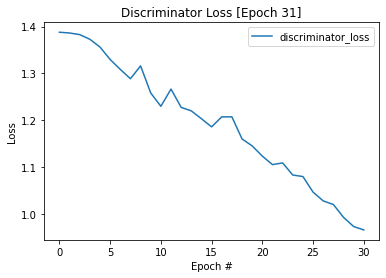

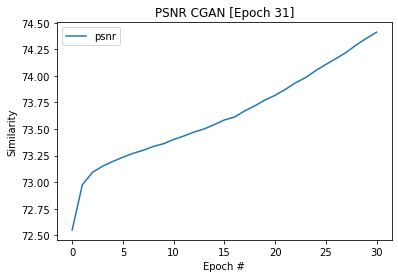

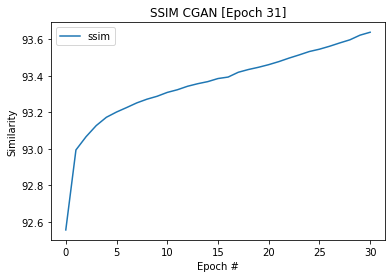

Epoch 31: gen loss: 8.211688995361328, disc loss: 0.9654298424720764, PSNR 74.41106368965637, SSIM 93.63918272306735, time: 218.10s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


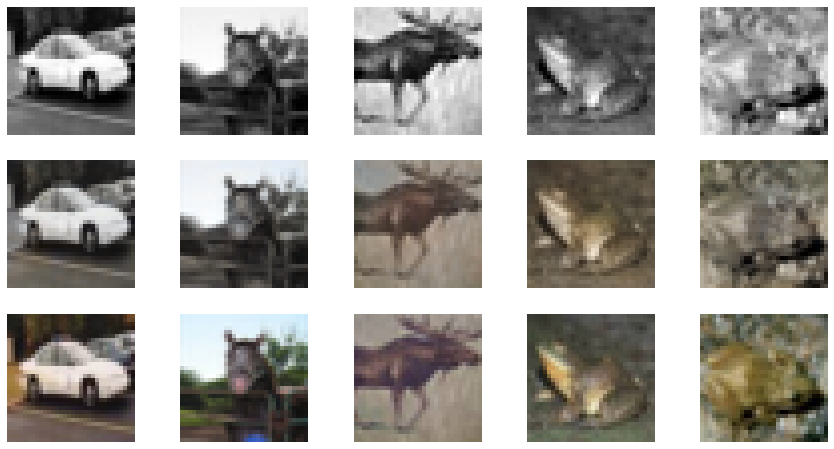

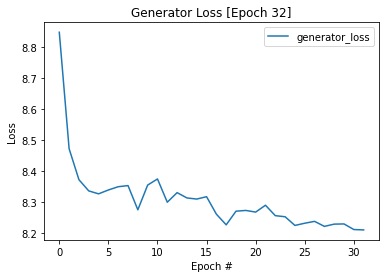

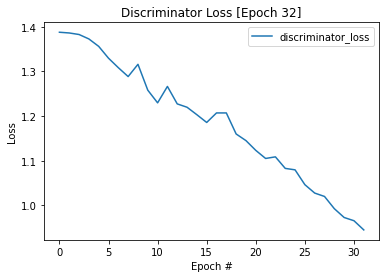

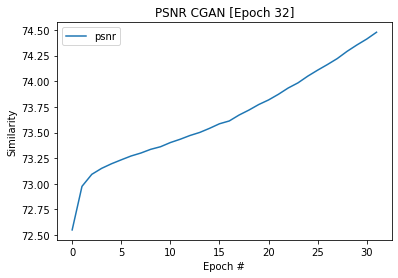

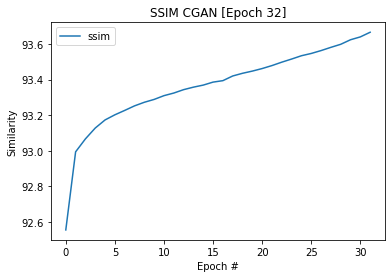

Epoch 32: gen loss: 8.210474967956543, disc loss: 0.944828987121582, PSNR 74.47760772651301, SSIM 93.66528678343248, time: 217.73s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


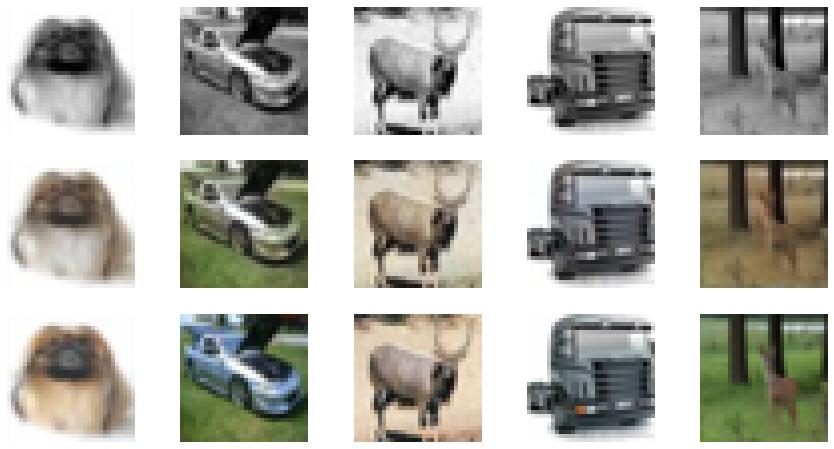

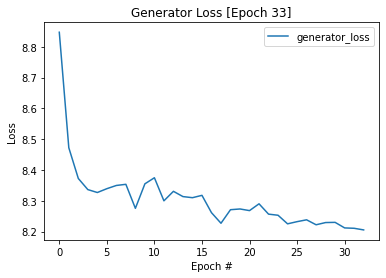

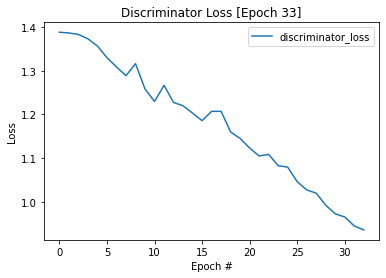

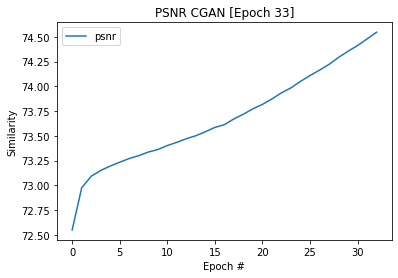

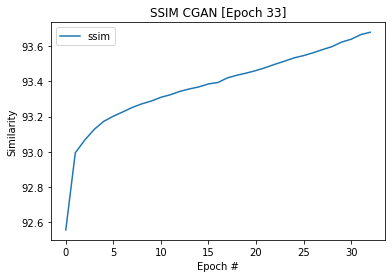

Epoch 33: gen loss: 8.205195426940918, disc loss: 0.9358915686607361, PSNR 74.54560244986426, SSIM 93.6790501166763, time: 216.37s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


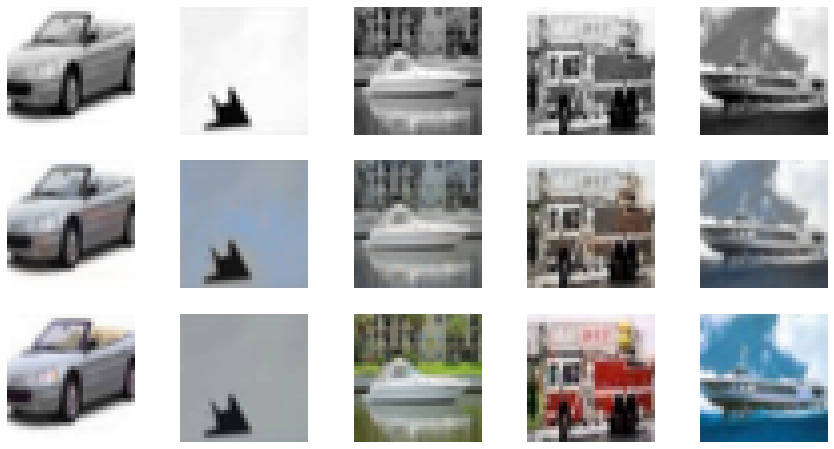

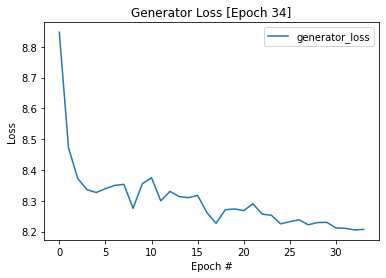

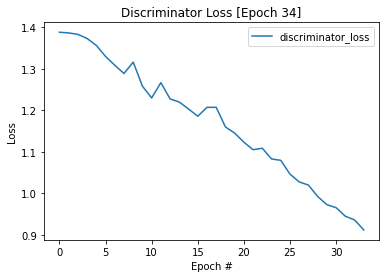

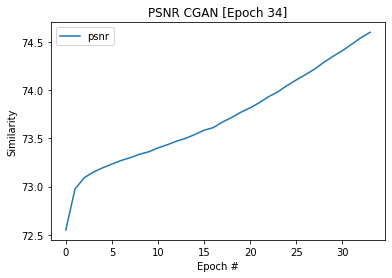

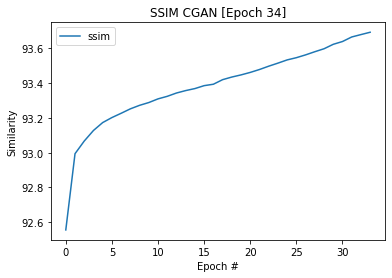

Epoch 34: gen loss: 8.20691204071045, disc loss: 0.9118836522102356, PSNR 74.60206159059811, SSIM 93.69251746966953, time: 215.75s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


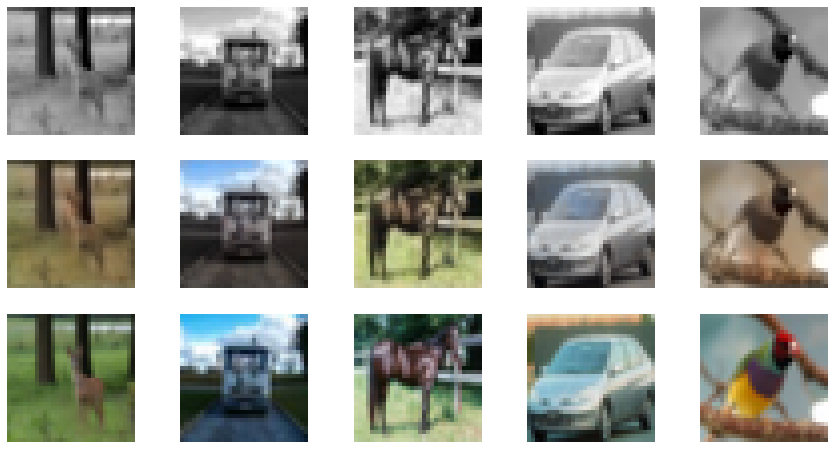

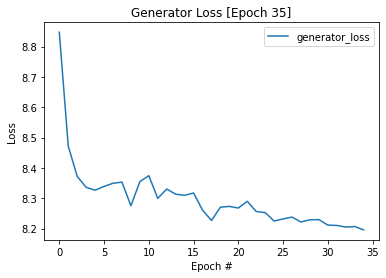

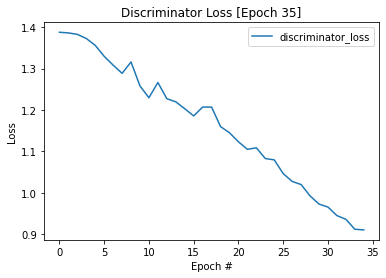

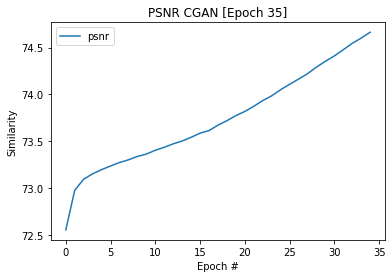

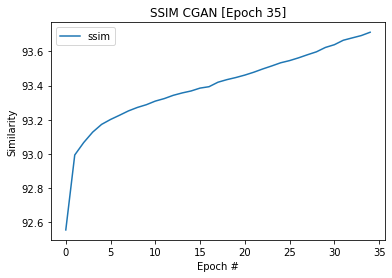

Epoch 35: gen loss: 8.19577407836914, disc loss: 0.9102417230606079, PSNR 74.66428160549351, SSIM 93.71208963813903, time: 215.36s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


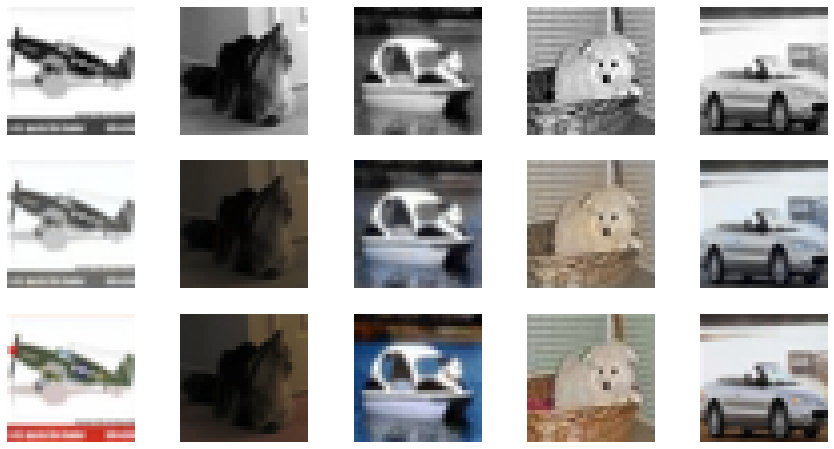

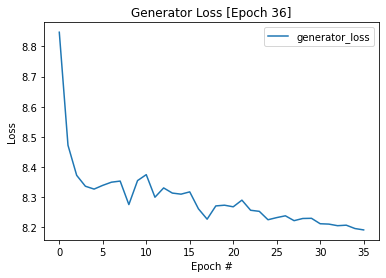

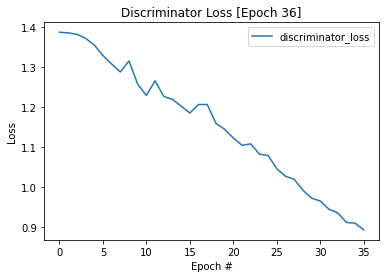

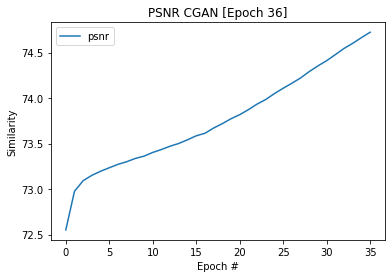

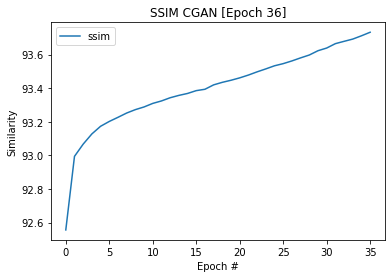

Epoch 36: gen loss: 8.191194534301758, disc loss: 0.8931825757026672, PSNR 74.72333304946893, SSIM 93.73320949258486, time: 216.70s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


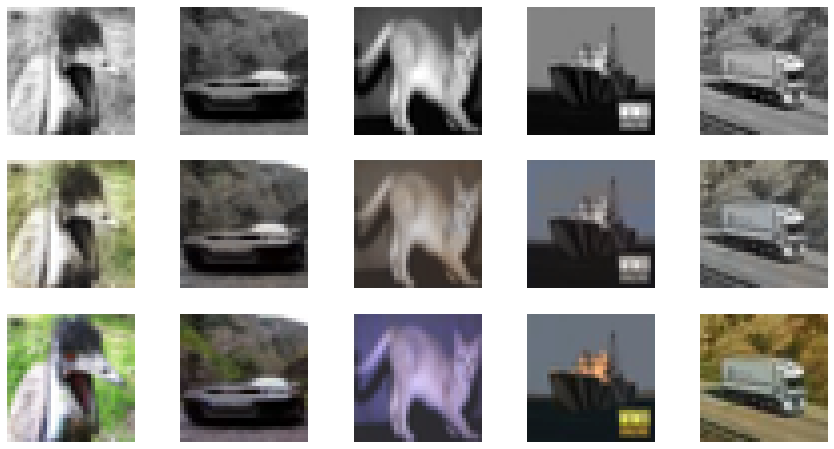

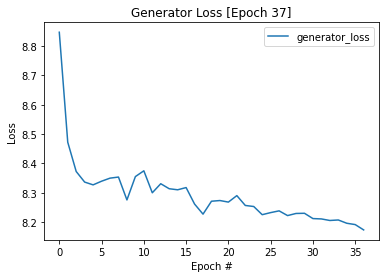

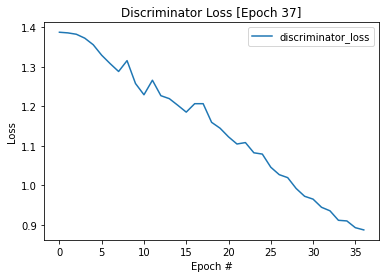

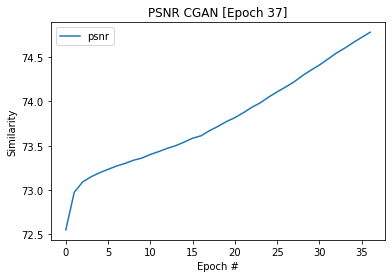

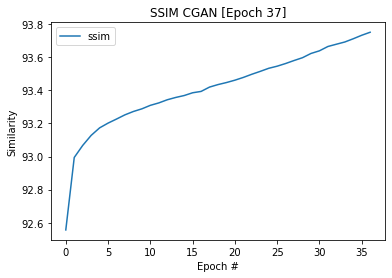

Epoch 37: gen loss: 8.173016548156738, disc loss: 0.887516975402832, PSNR 74.78076416396422, SSIM 93.75151956992542, time: 216.65s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


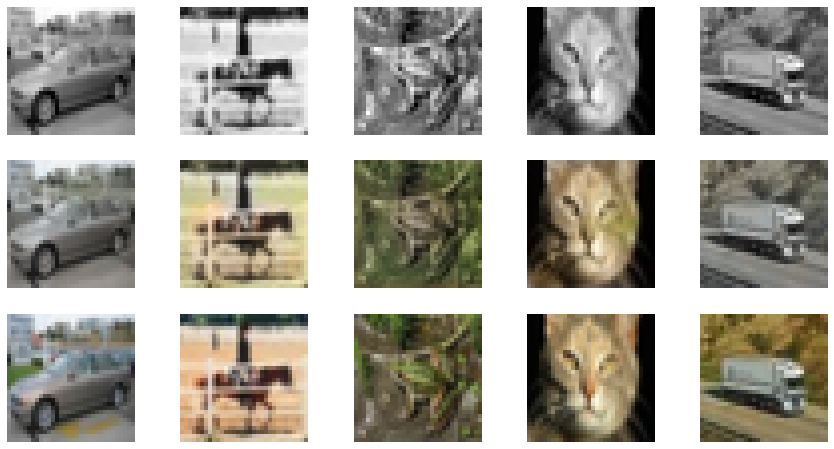

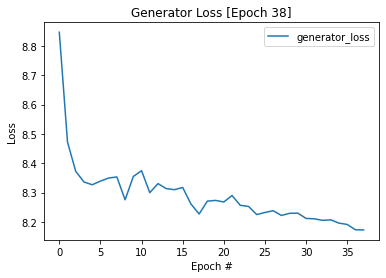

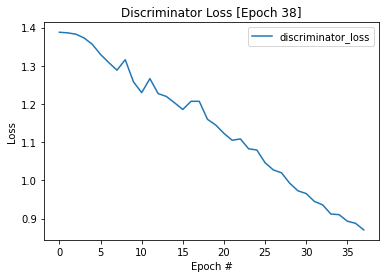

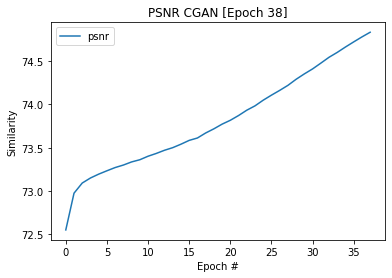

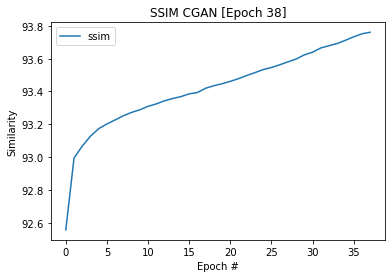

Epoch 38: gen loss: 8.172530174255371, disc loss: 0.8702887296676636, PSNR 74.83479253341561, SSIM 93.7610600213799, time: 215.20s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


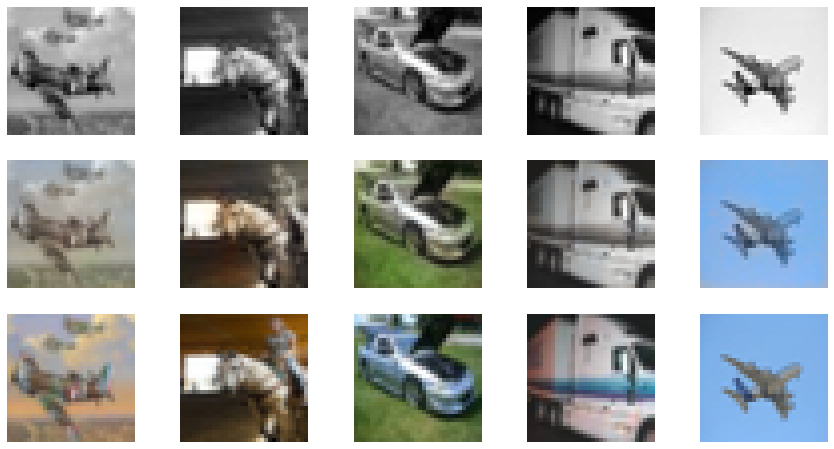

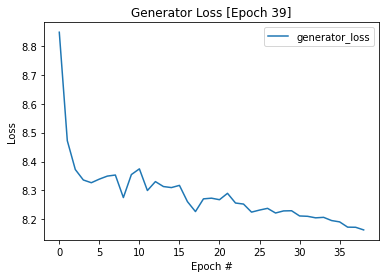

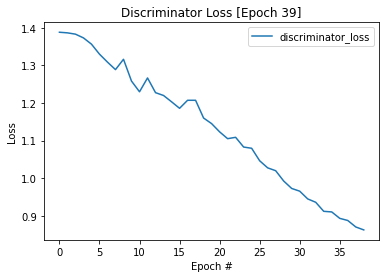

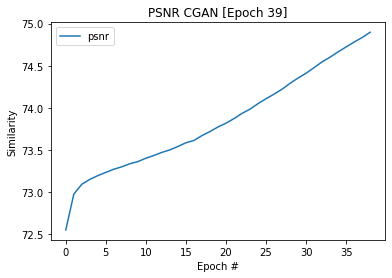

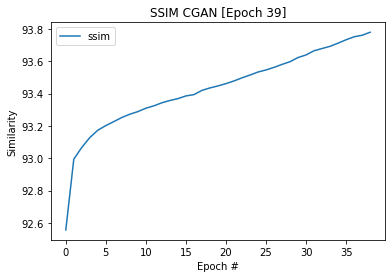

Epoch 39: gen loss: 8.163416862487793, disc loss: 0.8624449372291565, PSNR 74.89742398677902, SSIM 93.77962944118727, time: 214.46s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


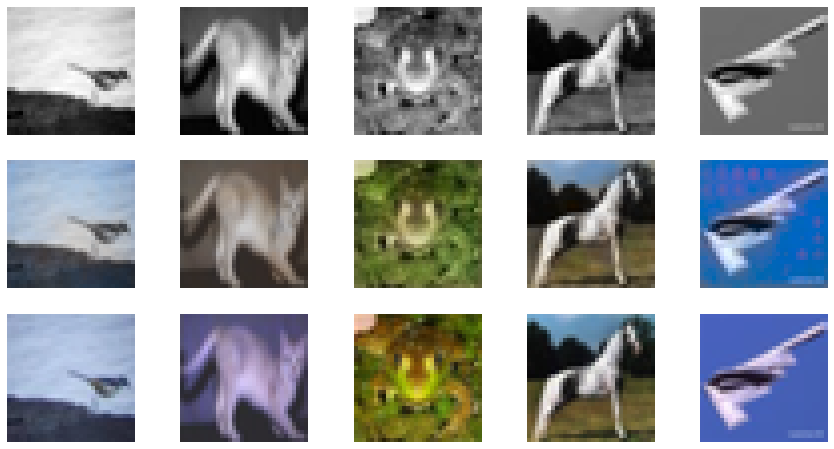

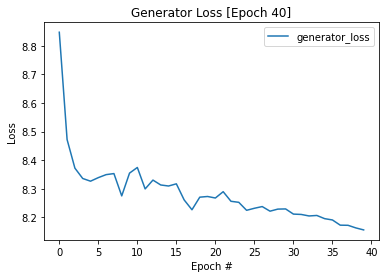

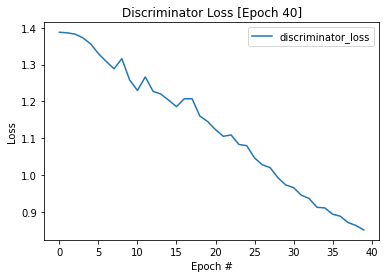

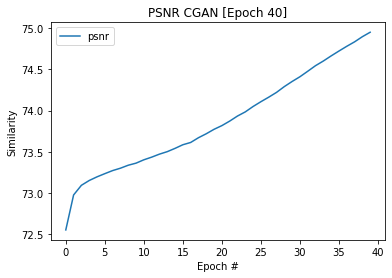

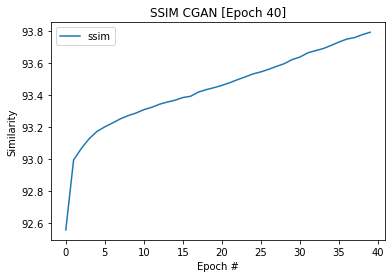

Epoch 40: gen loss: 8.156416893005371, disc loss: 0.8504074215888977, PSNR 74.95158513943066, SSIM 93.79452052404264, time: 216.70s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


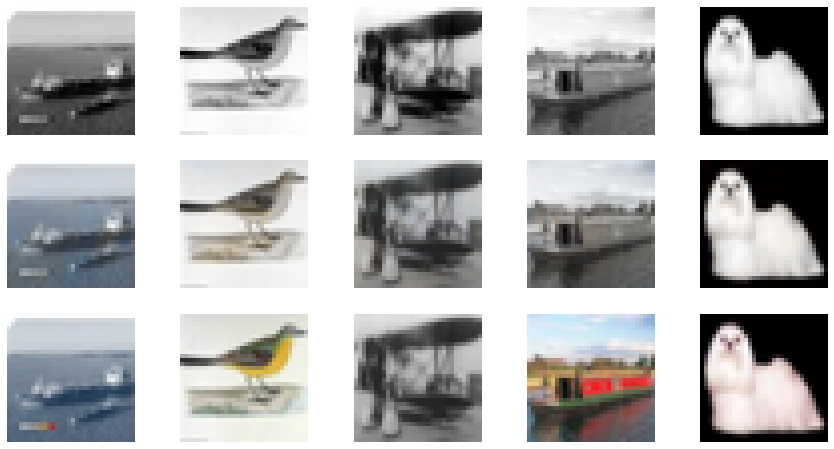

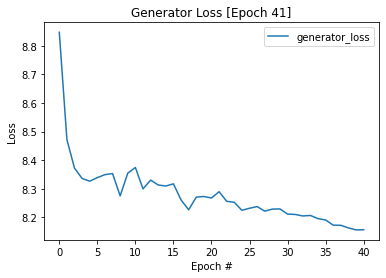

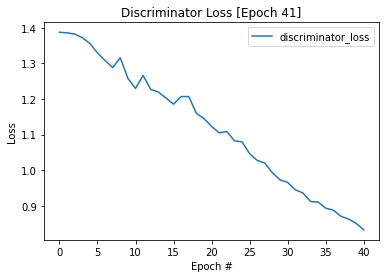

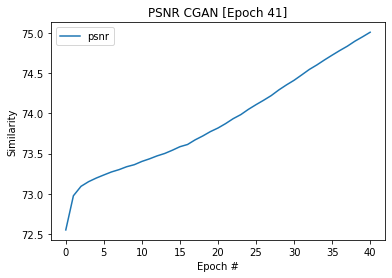

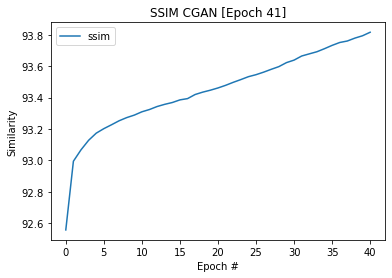

Epoch 41: gen loss: 8.157047271728516, disc loss: 0.8319308757781982, PSNR 75.00836108442333, SSIM 93.81693162591608, time: 216.83s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz

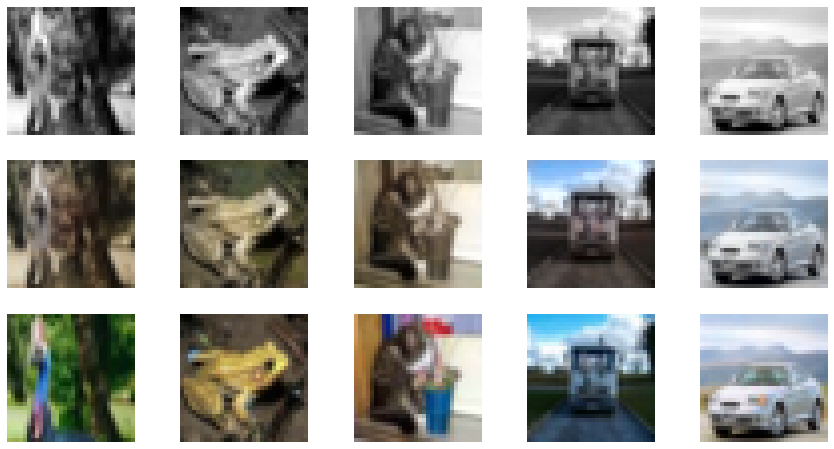

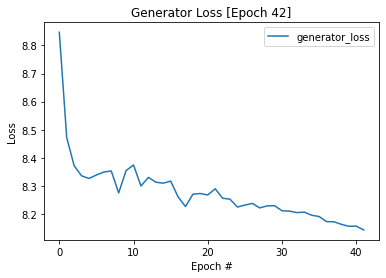

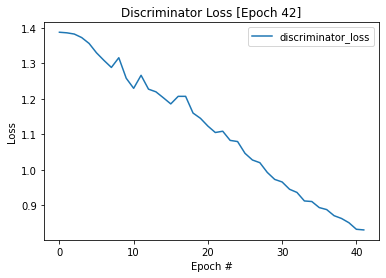

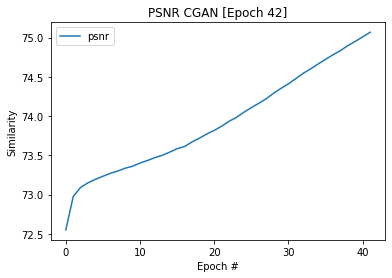

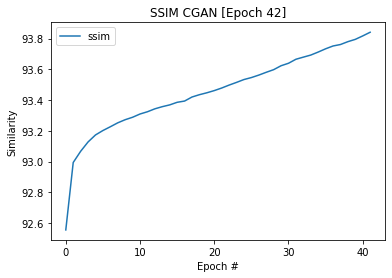

Epoch 42: gen loss: 8.143569946289062, disc loss: 0.8301421999931335, PSNR 75.06750940307975, SSIM 93.84081880947657, time: 217.13s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


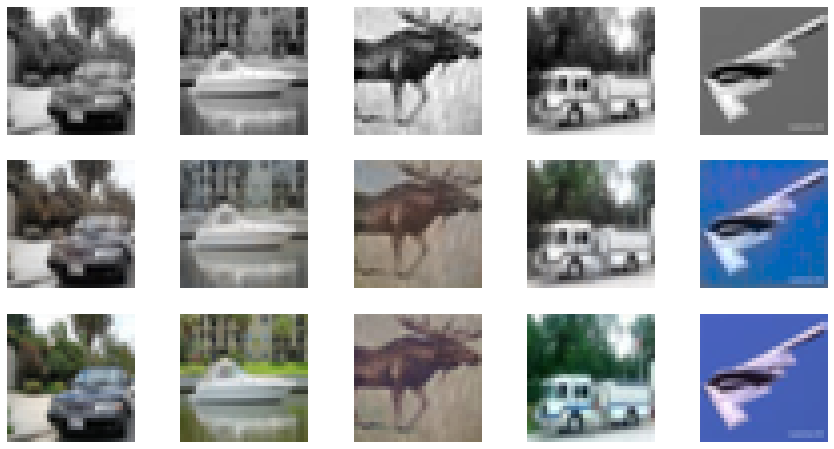

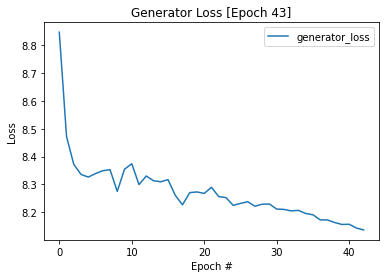

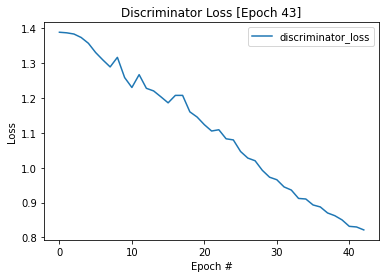

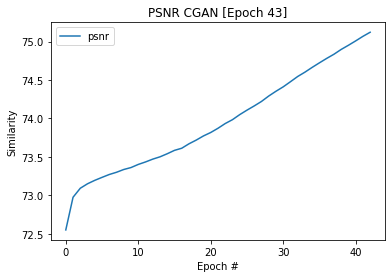

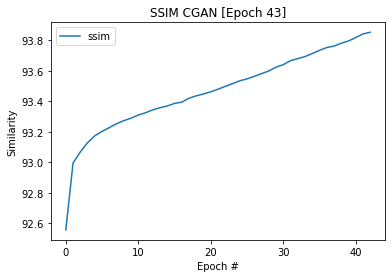

Epoch 43: gen loss: 8.136760711669922, disc loss: 0.821696400642395, PSNR 75.12099619677684, SSIM 93.85197063936084, time: 216.30s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


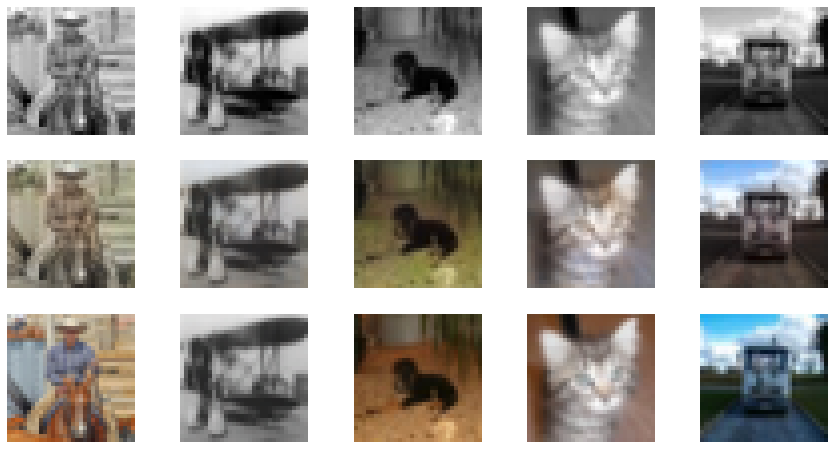

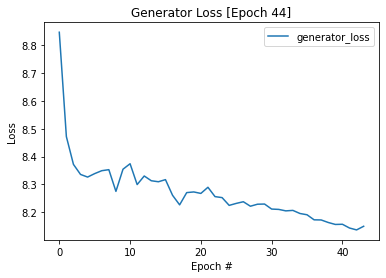

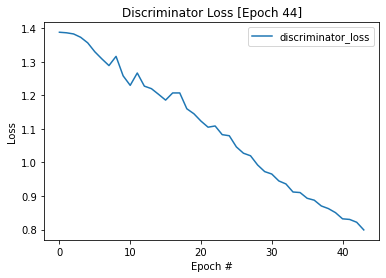

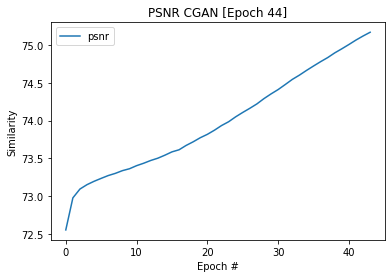

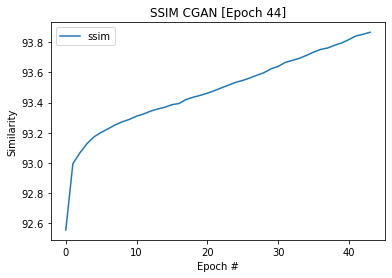

Epoch 44: gen loss: 8.149806022644043, disc loss: 0.7989048361778259, PSNR 75.17079246313666, SSIM 93.86531215547583, time: 216.88s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz

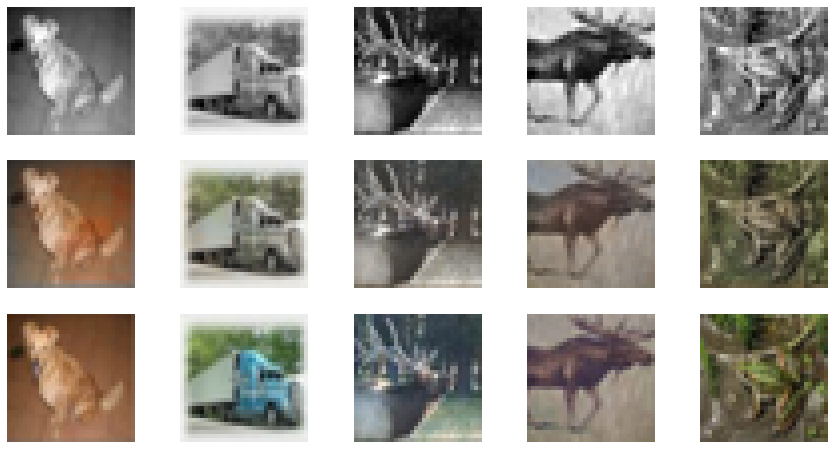

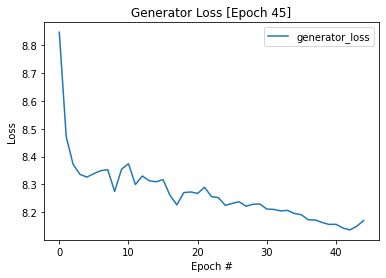

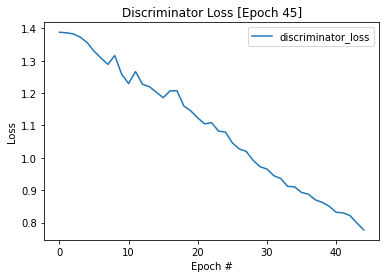

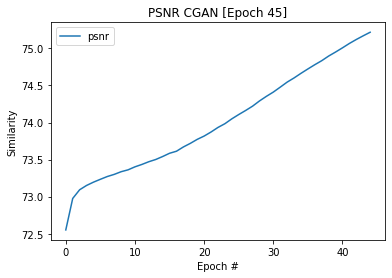

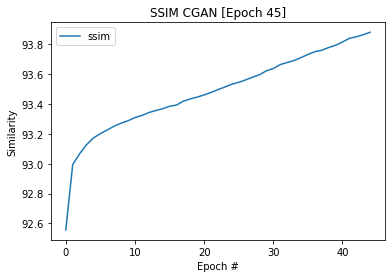

Epoch 45: gen loss: 8.170585632324219, disc loss: 0.7773905992507935, PSNR 75.21868539659457, SSIM 93.88217780354157, time: 217.84s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz

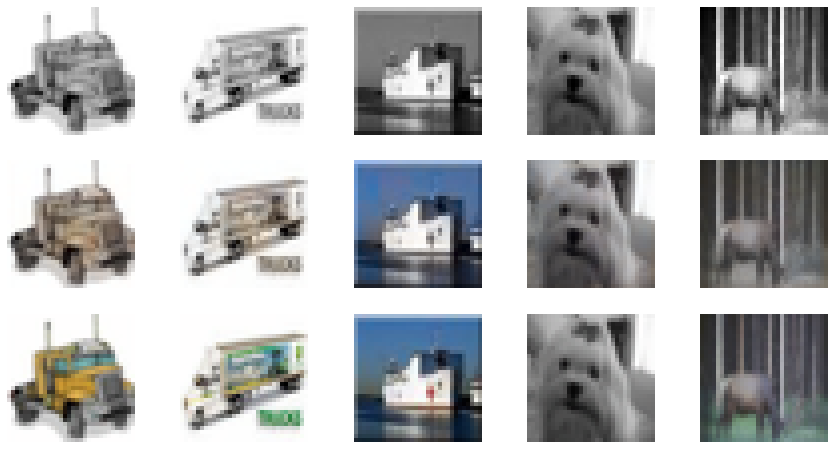

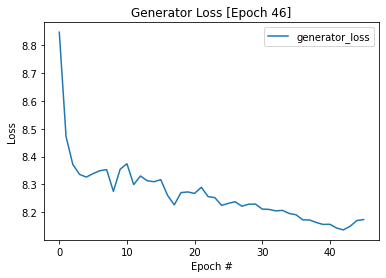

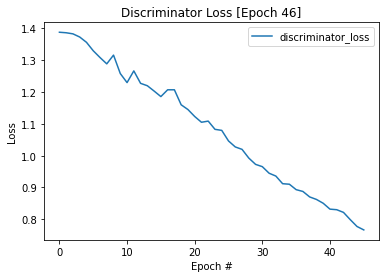

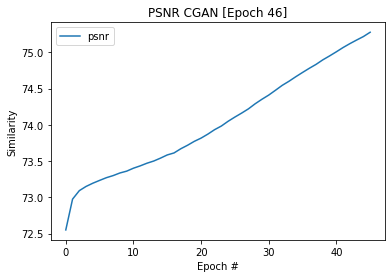

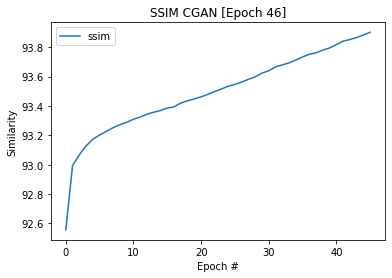

Epoch 46: gen loss: 8.173943519592285, disc loss: 0.7666342854499817, PSNR 75.27828380144007, SSIM 93.90131648496576, time: 216.79s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz

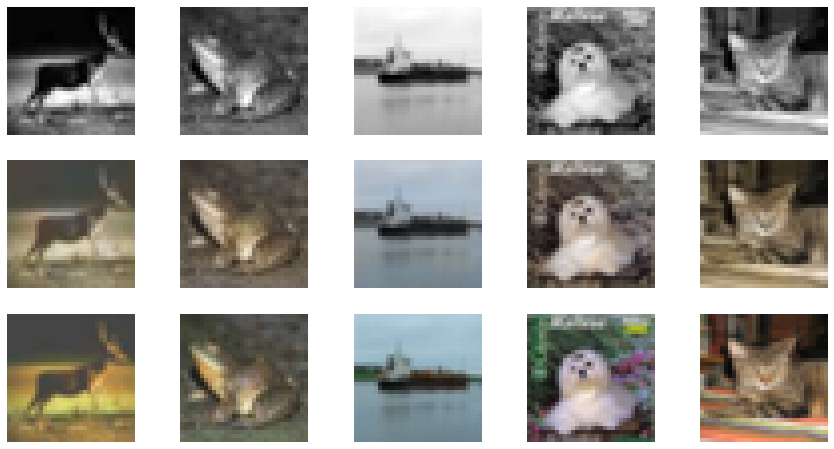

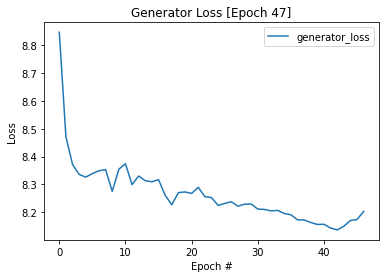

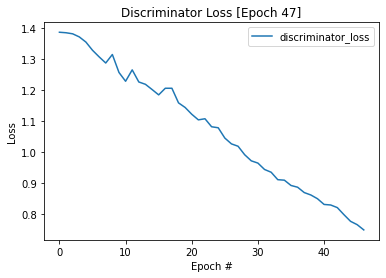

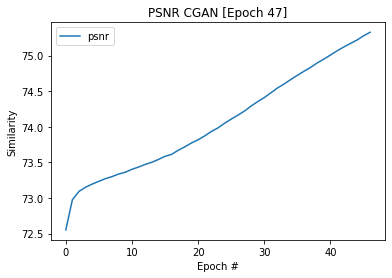

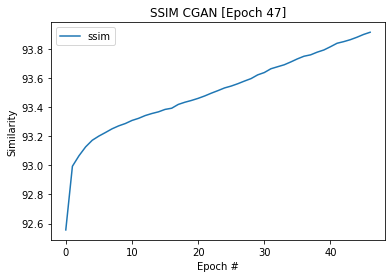

Epoch 47: gen loss: 8.203347206115723, disc loss: 0.749666690826416, PSNR 75.32877566798088, SSIM 93.91663113253135, time: 215.71s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz

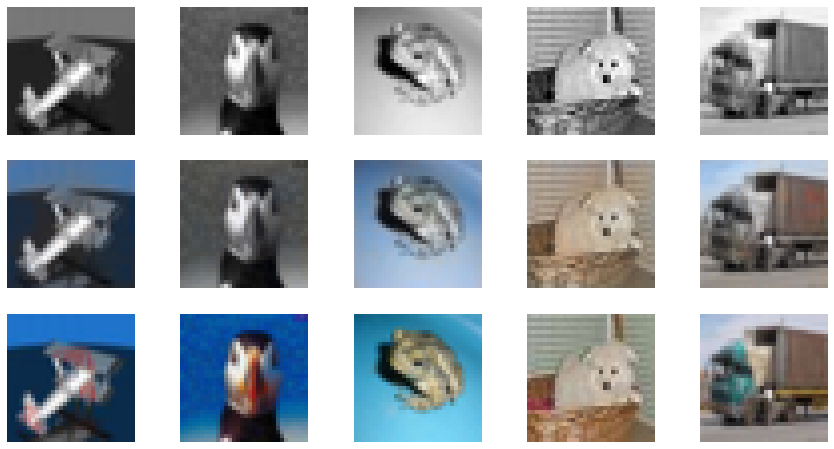

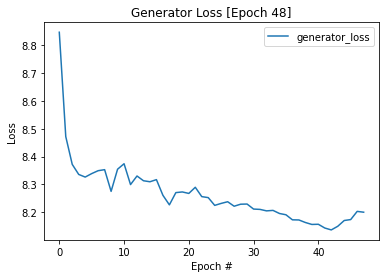

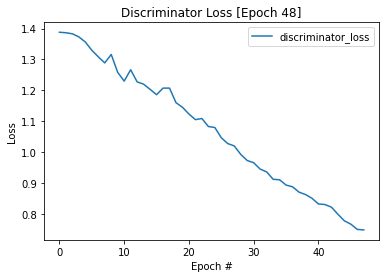

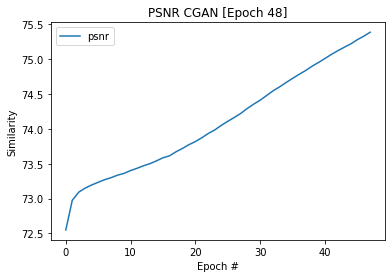

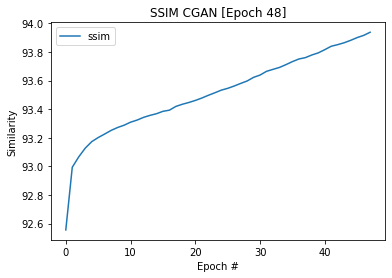

Epoch 48: gen loss: 8.200410842895508, disc loss: 0.7479732036590576, PSNR 75.38621919782466, SSIM 93.93858361887457, time: 217.07s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz

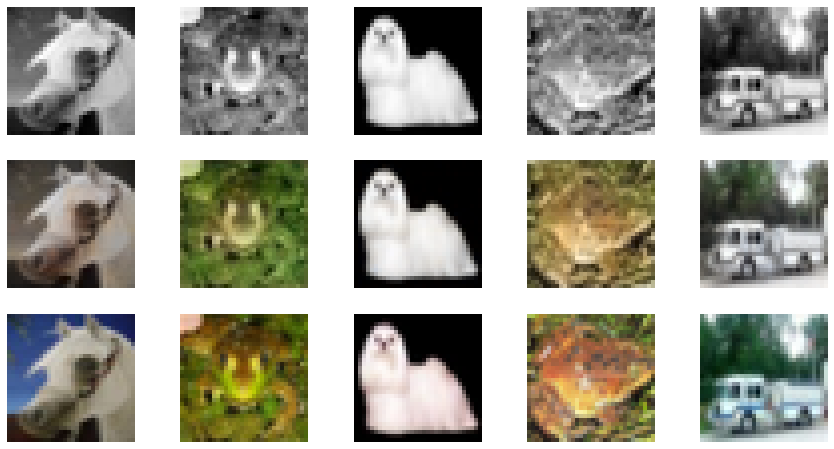

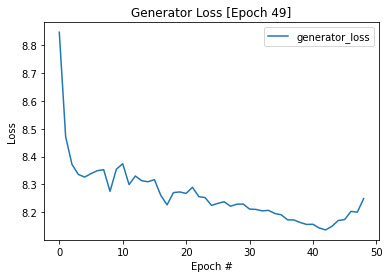

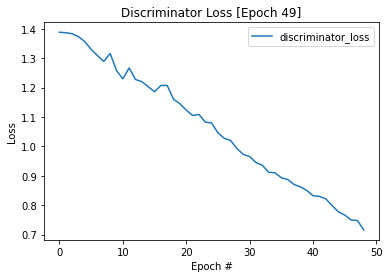

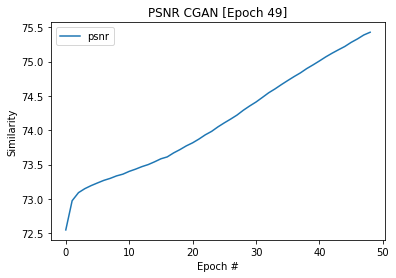

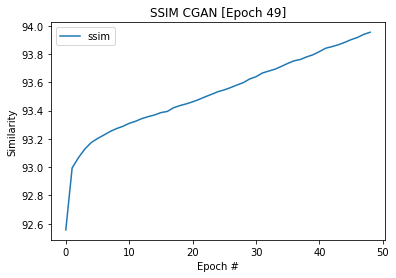

Epoch 49: gen loss: 8.24939250946045, disc loss: 0.7160118818283081, PSNR 75.42585185412412, SSIM 93.95355409156198, time: 217.58s


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz

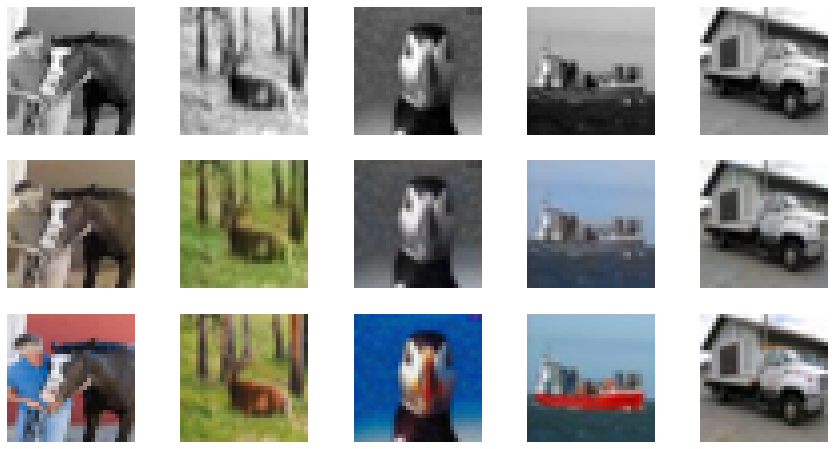

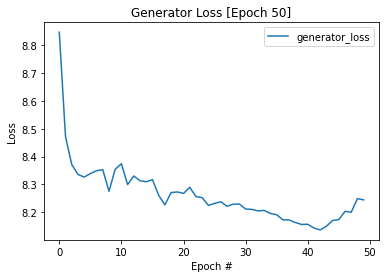

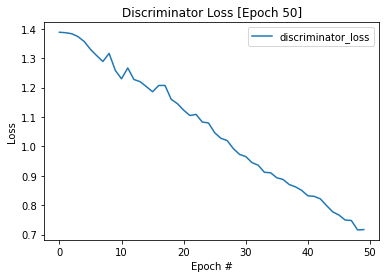

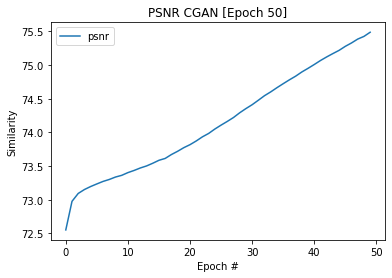

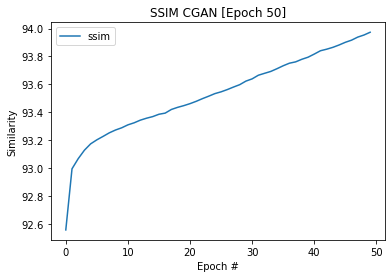

Epoch 50: gen loss: 8.244564056396484, disc loss: 0.7171279191970825, PSNR 75.48771541609341, SSIM 93.97350893621689, time: 216.33s


In [ ]:
gen_loss_list = []
disc_loss_list = []
psnr_list = []
ssim_list = []
psnr_val_o=ssim_val_o=0
print("Training Started")
total_epoch=50
for e in range(total_epoch):
    start_time = time()
    
    gen_loss_total = disc_loss_total =batch_no= 0
    psnr_val_o=ssim_val_o=0
    for input_image, target in train_dataset:
        psnr_val=ssim_val=0
        gen_loss, disc_loss = train_step(input_image, target, e)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss
        time_taken = time() - start_time
        batch_no=batch_no+1
        
        #check Visualize
        fake_color = generator(input_image, training=False)
        real_color = target
        L = input_image
        fake_imgs = lab_to_rgb(L, fake_color)
        real_imgs = lab_to_rgb(L, real_color)
        for u in range(int(BATCH_SIZE)):
            psnr_val=float(psnr_val+ PSNR(real_imgs[u],fake_imgs[u]))
            ssim_val=float(ssim_val+ SSIM_ex(real_imgs[u],fake_imgs[u]))
    
        #print('Epoch {} ({}/{}) gen loss: {}, disc loss: {}, PSNR {}, SSIM {}, time: {:.2f}s'.format(e+1,batch_no,int(total_sample/BATCH_SIZE), gen_loss, disc_loss,psnr_val/BATCH_SIZE,ssim_val/BATCH_SIZE, time_taken))
        psnr_val_o=float(psnr_val_o+psnr_val)
        ssim_val_o=float(ssim_val_o+ssim_val)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(np.squeeze(L[i,:,:,:].numpy()),cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
        
    plt.show()
    #if True:
    #fig.savefig(f"color_{time()}.png")

    gen_loss_list.append(gen_loss_total.numpy() /float(total_sample/ BATCH_SIZE))
    disc_loss_list.append(disc_loss_total.numpy() /float(total_sample/ BATCH_SIZE))
    psnr_list.append(psnr_val_o/float(total_sample))
    ssim_list.append(ssim_val_o/float(total_sample))
    on_epoch_end(e,gen_loss_list,disc_loss_list,psnr_list,ssim_list)
    #checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Epoch {}: gen loss: {}, disc loss: {}, PSNR {}, SSIM {}, time: {:.2f}s'.format(
        e + 1, gen_loss_total /float(total_sample/ BATCH_SIZE), disc_loss_total /float(total_sample/ BATCH_SIZE),psnr_val_o/float(total_sample),ssim_val_o/float(total_sample),time_taken))

In [ ]:
import csv
header = ["Generator Loss", "Discriminator Loss", "PSNR", "SSIM"]

with open(os.path.join(WORKDIR, "cifar10_loss_PM_100.csv"), "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(len(gen_loss_list)):
        content = [gen_loss_list[i], disc_loss_list[i], psnr_list[i], ssim_list[i]]
        writer.writerow(content)

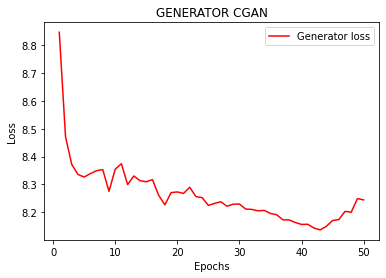

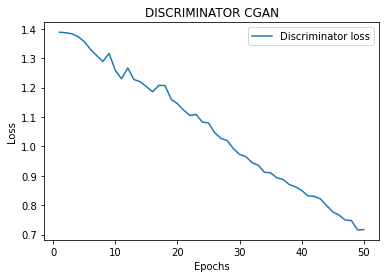

In [ ]:
total_epoch=len(gen_loss_list)
plt.plot(range(1,total_epoch+1,1), gen_loss_list, 'r', label='Generator loss')
plt.title('GENERATOR CGAN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(1,total_epoch+1,1), disc_loss_list, '-', label='Discriminator loss')
plt.title('DISCRIMINATOR CGAN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

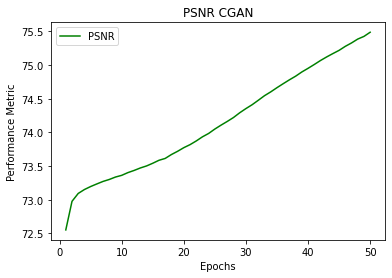

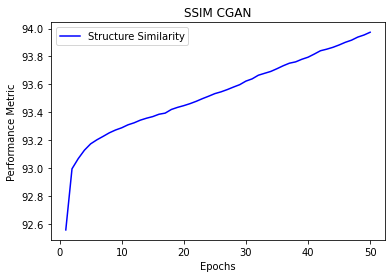

In [ ]:
plt.plot(range(1,total_epoch+1,1), psnr_list, 'g', label='PSNR')
plt.title('PSNR CGAN')
plt.xlabel('Epochs')
plt.ylabel('Performance Metric')
plt.legend()
plt.show()
plt.plot(range(1,total_epoch+1,1), ssim_list, 'b', label='Structure Similarity')
plt.title('SSIM CGAN')
plt.xlabel('Epochs')
plt.ylabel('Performance Metric')
plt.legend()
plt.show()

In [ ]:
generator.save(os.path.join(WORKDIR, 'EX100Egenerator-model-cifar10.h5'))
discriminator.save(os.path.join(WORKDIR, 'EX100Edisciminator-model-cifar10.h5'))

## **Evaluation module**

In [ ]:
generator = tf.keras.models.load_model(os.path.join(WORKDIR, 'EX100Egenerator-model-cifar10.h5'))

In [ ]:
samples=train_images.shape[0]
print("Total "+str(samples)+" in the train data")
L, ab_real = generate_dataset(train_images)
print(L.shape, ab_real.shape)
ab_fake = generator(L, training=False)

fake_imgs = lab_to_rgb(L, ab_fake)
real_imgs = lab_to_rgb(L, ab_real)
print(real_imgs.shape,fake_imgs.shape)
psnr_val=[]
ssim_val=[]
for u in range(samples):
    psnr_val.append(PSNR(real_imgs[u],fake_imgs[u]))
    ssim_val.append(SSIM_ex(real_imgs[u],fake_imgs[u]))


print("Average PSNR: "+str(sum(psnr_val)/samples)+" , Minimum PSNR: "+str(min(psnr_val))+" , Maximum PSNR: "+str(max(psnr_val))+ " for "+str(samples)+" samples.")
print("Average SSIM: "+str(sum(ssim_val)/samples)+" , Minimum SSIM: "+str(min(ssim_val))+" , Maximum SSIM: "+str(max(ssim_val))+ " for "+str(samples)+" samples.")


Total 50000 in the train data
(50000, 32, 32, 1) (50000, 32, 32, 2)


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(50000, 32, 32, 3) (50000, 32, 32, 3)
Average PSNR: 74.85452891661559 , Minimum PSNR: 53.63267037618477 , Maximum PSNR: 99.8438491760602 for 50000 samples.
Average SSIM: 93.74934106947498 , Minimum SSIM: 16.047257215126002 , Maximum SSIM: 99.95878042756567 for 50000 samples.


In [ ]:
samples=test_images.shape[0]
print("Total "+str(samples)+" in the test data")
L, ab_real = generate_dataset(test_images)
print(L.shape, ab_real.shape)
ab_fake = generator(L, training=False)

fake_imgs = lab_to_rgb(L, ab_fake)
real_imgs = lab_to_rgb(L, ab_real)
print(real_imgs.shape,fake_imgs.shape)
psnr_val=[]
ssim_val=[]
for u in range(samples):
    psnr_val.append(PSNR(real_imgs[u],fake_imgs[u]))
    ssim_val.append(SSIM_ex(real_imgs[u],fake_imgs[u]))


print("Average PSNR: "+str(sum(psnr_val)/samples)+" , Minimum PSNR: "+str(min(psnr_val))+" , Maximum PSNR: "+str(max(psnr_val))+ " for "+str(samples)+" samples.")
print("Average SSIM: "+str(sum(ssim_val)/samples)+" , Minimum SSIM: "+str(min(ssim_val))+" , Maximum SSIM: "+str(max(ssim_val))+ " for "+str(samples)+" samples.")


Total 10000 in the test data
(10000, 32, 32, 1) (10000, 32, 32, 2)
(10000, 32, 32, 3) (10000, 32, 32, 3)
Average PSNR: 72.5897497399602 , Minimum PSNR: 56.08558857309322 , Maximum PSNR: 95.28670639118778 for 10000 samples.
Average SSIM: 92.5878148073485 , Minimum SSIM: 41.59023724741852 , Maximum SSIM: 99.91219300289065 for 10000 samples.


# Downstream Classification Task

In [ ]:
generator = tf.keras.models.load_model(os.path.join(WORKDIR, 'EX100Egenerator-model-cifar10.h5'))
discriminator = tf.keras.models.load_model(os.path.join(WORKDIR, 'EX100Edisciminator-model-cifar10.h5'))

(10000, 32, 32, 3)
(10000, 1)


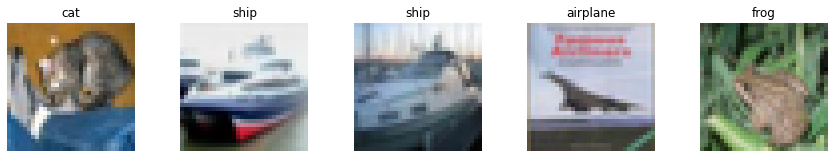

In [ ]:
class_list = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(15, 8))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(test_images[i,:,:,:])
    ax.axis("off")
    ax.title.set_text(class_list[int(y_test[i])])
        
print(test_images.shape)       
print(y_test.shape) 

In [ ]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test)
print(integer_encoded.shape)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_c = onehot_encoder.fit_transform(integer_encoded)
print(y_c.shape)

(10000,)
(10000, 10)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.model_selection import train_test_split
numb_of_sample=test_images.shape[0]
print('numb_of_sample: ',numb_of_sample)

print("Image Data: " ,test_images.shape)
x_c,_= generate_dataset(test_images)
x_train_c,x_test_c,y_train_c,y_test_c=train_test_split(x_c,y_c, test_size=0.2, train_size=0.2,
                                                       random_state=None, shuffle=True, stratify=y_c)
x_train_c = tf.stack(x_train_c)
y_train_c = tf.stack(y_train_c)


print("Xtrain: " ,x_train_c.shape)
print("Xtest: " ,x_test_c.shape)

print("Ytrain: " ,y_train_c.shape)
print("Ytest: " ,y_test_c.shape)

numb_of_sample:  10000
Image Data:  (10000, 32, 32, 3)
Xtrain:  (2000, 32, 32, 1)
Xtest:  (2000, 32, 32, 1)
Ytrain:  (2000, 10)
Ytest:  (2000, 10)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
def show_results(x_test_c,y_test_c,class_list,finetune_model,history):    
    
    
    # Plot the training and validation loss + accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()


    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(epochs, loss,'-r', label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    print ("Testing Results")
    Y_pred = finetune_model.predict(x_test_c)
    y_label=np.argmax(y_test_c, axis=1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_label, y_pred))
    cm = confusion_matrix(y_label, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot()
    plt.show()
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    #f1-score
    fa=sum(FP)+sum(FN)
    #print(float(1/2(sum(FP)+sum(FN))))
    F1_SC= float(sum(TP)/float(sum(TP)+float(1/2*(sum(FP)+sum(FN)))))
    
    print("Accuracy: ",round(sum(ACC)/len(class_list),4))
    print("F1-Score: ",round(F1_SC/len(class_list),4))
    print("Sensitivity: ",round(sum(TPR)/len(class_list),4))
    print("Specificity: ",round(sum(TNR)/len(class_list),4))
    print("Precision: ",round(sum(PPV)/len(class_list),4))
    print("Negative predictive value: ",round(sum(NPV)/len(class_list),4))
    print("Fall out: ",round(sum(FPR)/len(class_list),4))
    print("False negative rate: ",round(sum(FNR)/len(class_list),4))
    print("False discovery rate: ",round(sum(FDR)/len(class_list),4))
    print ("[Testing Completed]")
    return F1_SC*100,PPV*100,TPR*100 # f1 score, Precision, Sensitivity

    
def f1_prec_rec(ond,thd,figsiz,t_st):
    data = {ond:thd};
    dataFrame = pd.DataFrame(data=data, index=class_list);
    fig, ax = plt.subplots(figsize=(60,50))
    dataFrame.plot.bar(ax=ax,rot=90, title=t_st)
    plt.show(block=True)   
    
    
def compare_results(history_weighted, history_baseline):    
    
    
    # Plot the training and validation loss + accuracy
    acc_b = history_baseline.history['accuracy']
    acc_w = history_weighted.history['accuracy']
    epochs = range(len(acc_w))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc_b,color='green', label='From Baseline (MobileNet)')
    plt.plot(epochs, acc_w,color='blue', label='From colorization weights')
    plt.legend()
    plt.title('Training Accuracy')
    plt.show()


    loss_b = history_baseline.history['loss']
    loss_w = history_weighted.history['loss']
    epochs = range(len(acc_w))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(epochs, loss_b,color='green', label='From Baseline (MobileNet)')
    plt.plot(epochs, loss_w,color='blue', label='From colorization weights')
    plt.legend()
    plt.title('Training Loss')
    plt.show()
    

## Pre-text Weighted Model

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        print(layer.name)
        layer.trainable = False
    x = base_model.get_layer("concatenate").output
    x = Flatten()(x)
    for fc in fc_layers:    
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)
        
    predictions = Dense(num_classes, activation='sigmoid')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024,1024]
dropout = 0.3

finetune_model = build_finetune_model(generator, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))
finetune_model.summary()

input_1
sequential
sequential_1
sequential_2
sequential_3
sequential_4
sequential_5
concatenate
sequential_6
concatenate_1
sequential_7
concatenate_2
sequential_8
concatenate_3
conv2d_transpose_4
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 32)   512         ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 8, 8, 64)     33024       ['sequential[0][0]']             
                                                                                              

In [ ]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        lr=5e-5
        return lr

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
import matplotlib.pyplot as plt

NUM_EPOCHS = 4
BATCH_SIZE = 32

finetune_model.compile(Adam(learning_rate=3e-4), loss='binary_crossentropy',
                       metrics=['accuracy'])

filepath=os.path.join(WORKDIR, "downstream/Ex100E_model_weights_cifar10_TRANSFER.h5")
checkpoint = ModelCheckpoint(filepath, monitor=["accuracy"], verbose=1, mode='max')
lrscheduler_callback=LearningRateScheduler(scheduler)
callbacks_list = [checkpoint,lrscheduler_callback]

In [ ]:
history_color_weighted = finetune_model.fit(x_train_c, y_train_c, epochs=NUM_EPOCHS, workers=8, validation_split = 0.2,
                             steps_per_epoch=(x_train_c.shape[0]*0.2)//BATCH_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False, callbacks=callbacks_list)

Epoch 1/4
 9/12 [=====================>........] - ETA: 0s - loss: 0.4307 - accuracy: 0.1146
Epoch 1: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream/Ex100E_model_weights_cifar10_TRANSFER.h5
12/12 [==============================] - 2s 93ms/step - loss: 0.4107 - accuracy: 0.1406 - val_loss: 0.3203 - val_accuracy: 0.2600 - lr: 3.0000e-04
Epoch 2/4
 9/12 [=====================>........] - ETA: 0s - loss: 0.3074 - accuracy: 0.2708
Epoch 2: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream/Ex100E_model_weights_cifar10_TRANSFER.h5
12/12 [==============================] - 0s 30ms/step - loss: 0.3033 - accuracy: 0.2760 - val_loss: 0.2826 - val_accuracy: 0.3400 - lr: 3.0000e-04
Epoch 3/4
 9/12 [=====================>........] - ETA: 0s - loss: 0.2787 - accuracy: 0.2986
Epoch 3: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream/Ex100E_model_weights_cifar10_TRANSFER.h5
12/12 [==============================] - 0s 30ms/step - loss: 0.2802 - accuracy

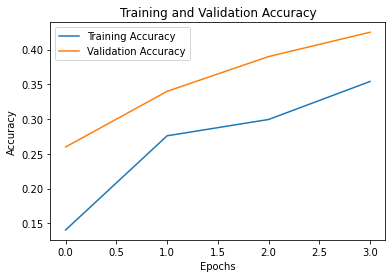

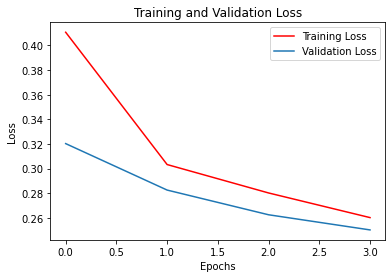

Testing Results
63/63 [==============================] - 0s 4ms/step
Confusion Matrix
[[137  12  13   4   4  11   4   4   7   4]
 [ 28 132   4   4   2   4   3   5   7  11]
 [ 34  12  35   7  35  44  14  14   4   1]
 [ 16  13   6  20  20  82  17  20   1   5]
 [ 15  11  15   5  90  14  16  32   1   1]
 [ 12   4   7  16  15 104  14  25   1   2]
 [  7  13  10  12  28  25  87  12   3   3]
 [ 10   8   8  13  16  32   9  87   3  14]
 [ 91  35   4   4   3   7   2   2  40  12]
 [ 25  97   1   4   0   6   6  12   5  44]]


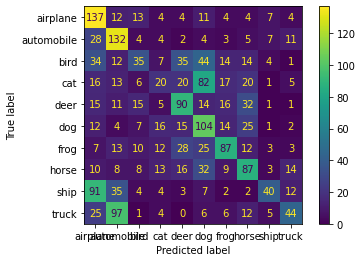

Accuracy:  0.8776
F1-Score:  0.0388
Sensitivity:  0.388
Specificity:  0.932
Precision:  0.3984
Negative predictive value:  0.933
Fall out:  0.068
False negative rate:  0.612
False discovery rate:  0.6016
[Testing Completed]


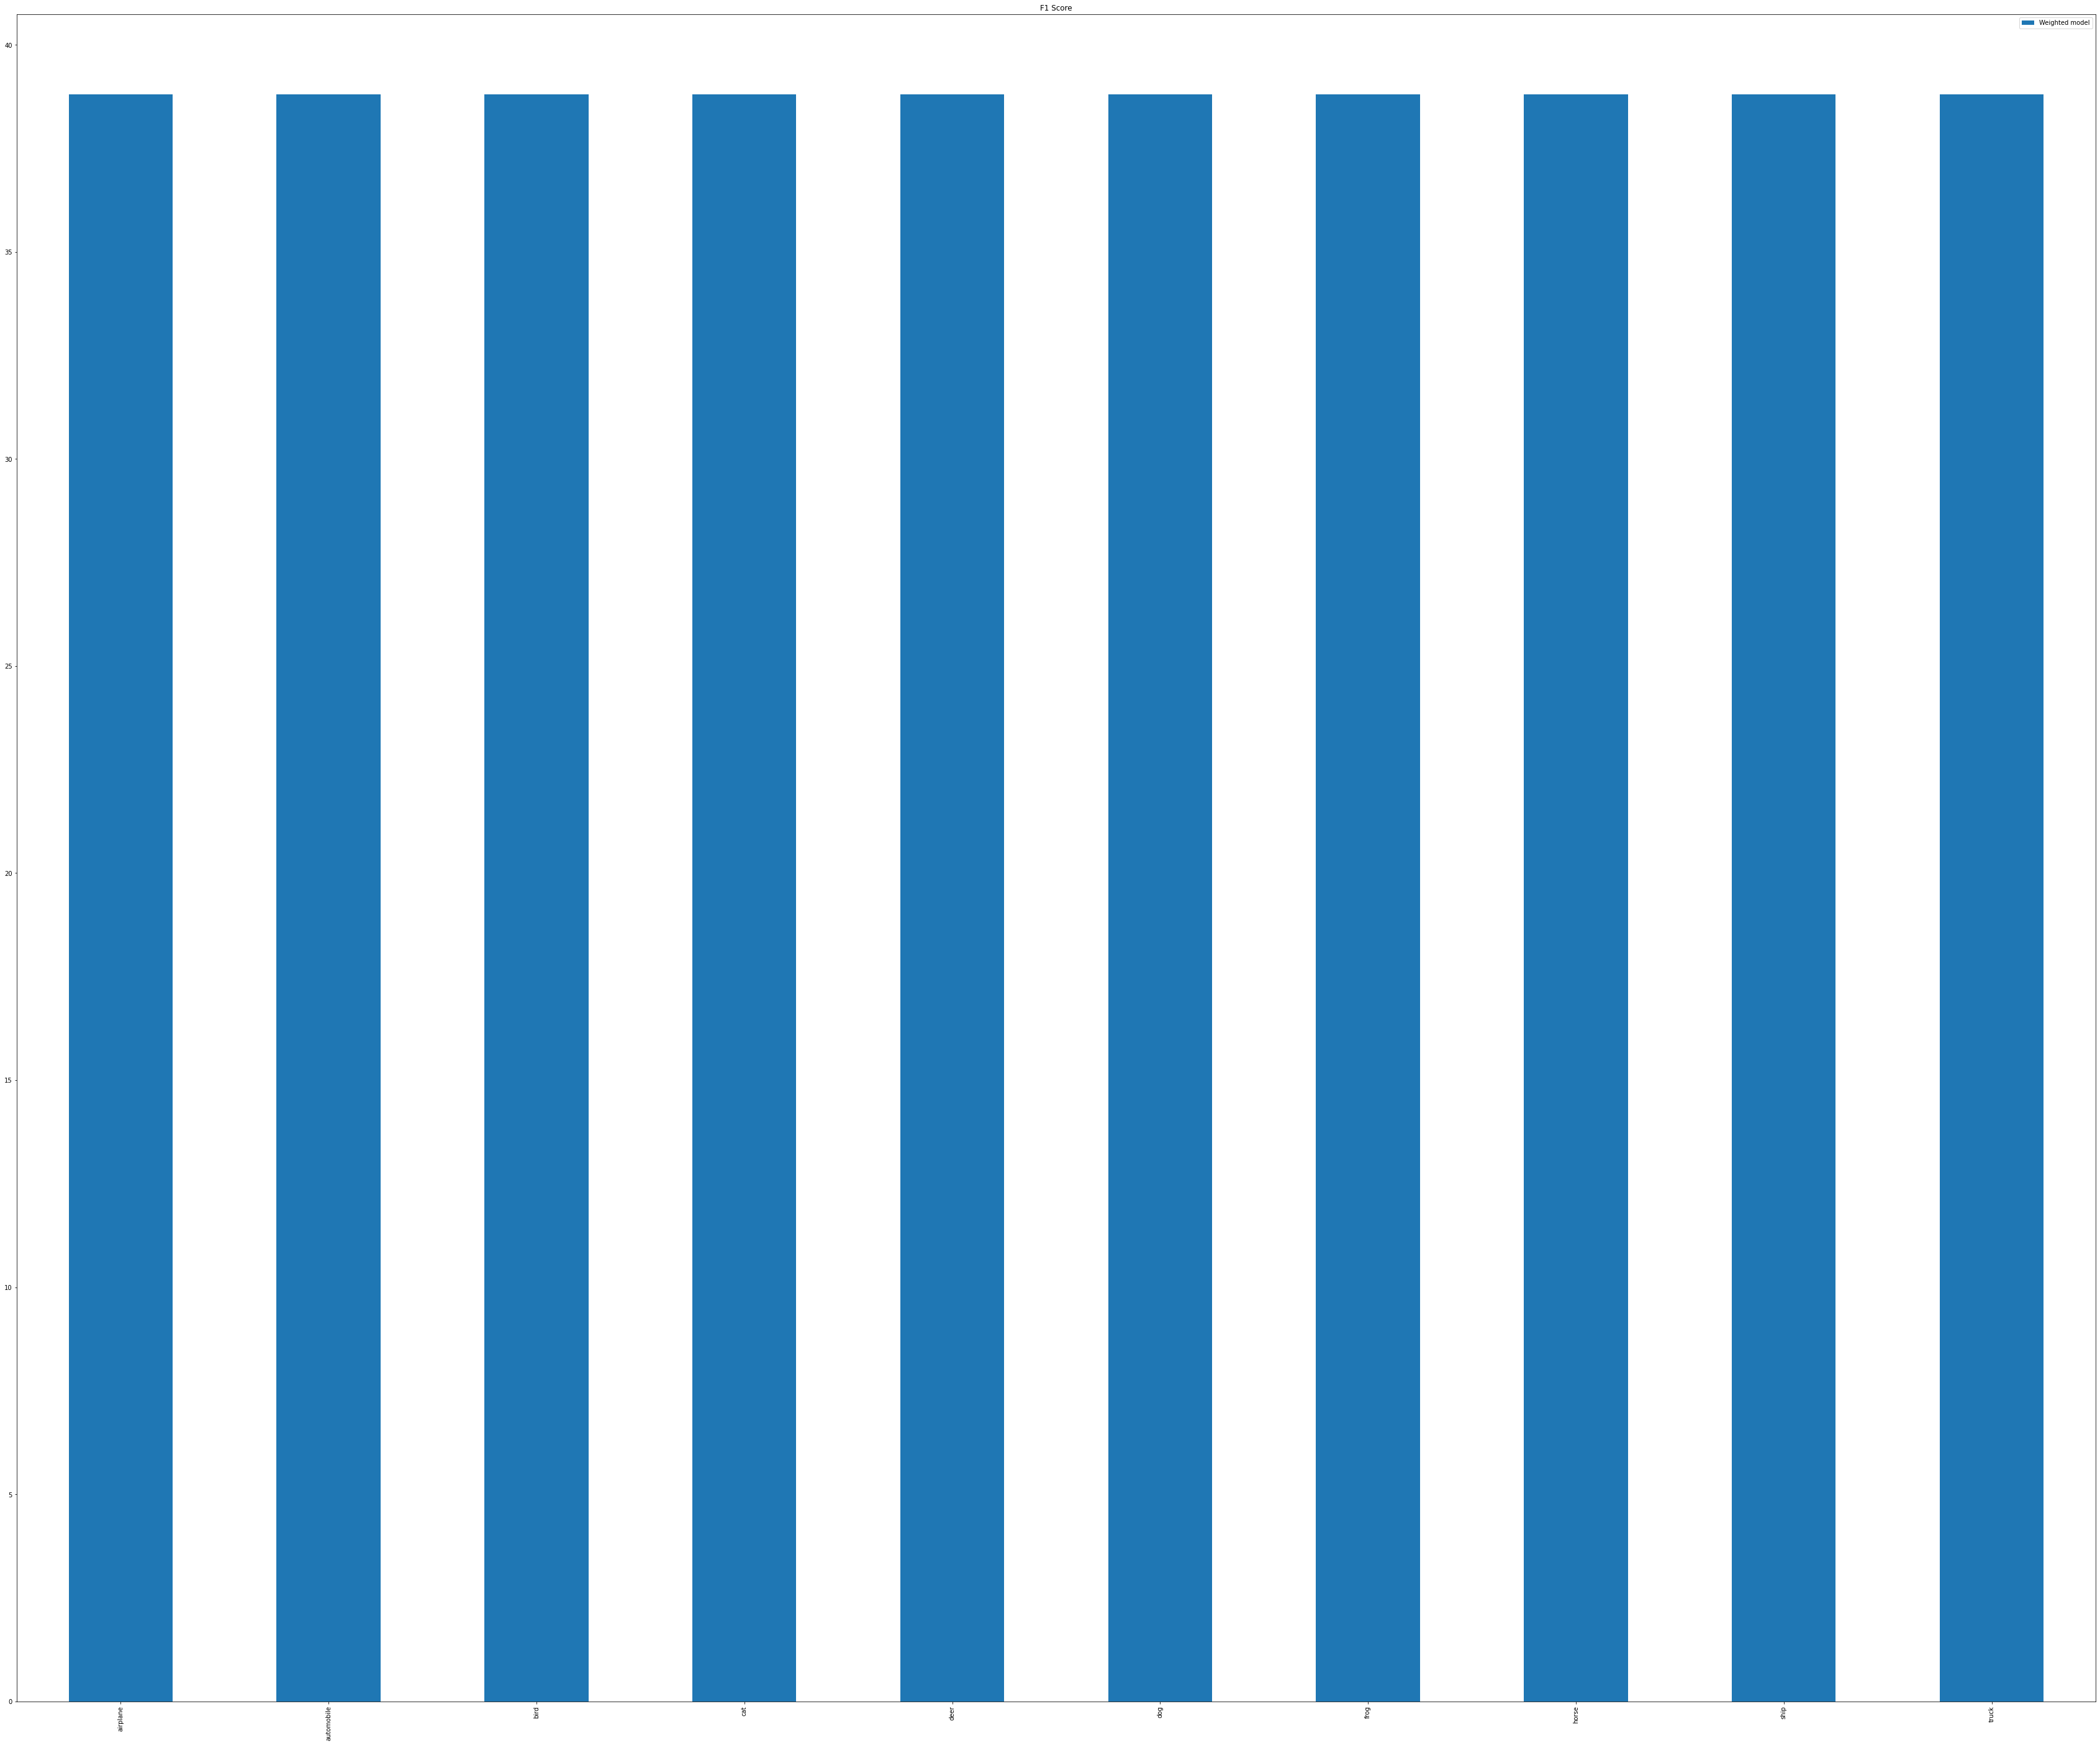

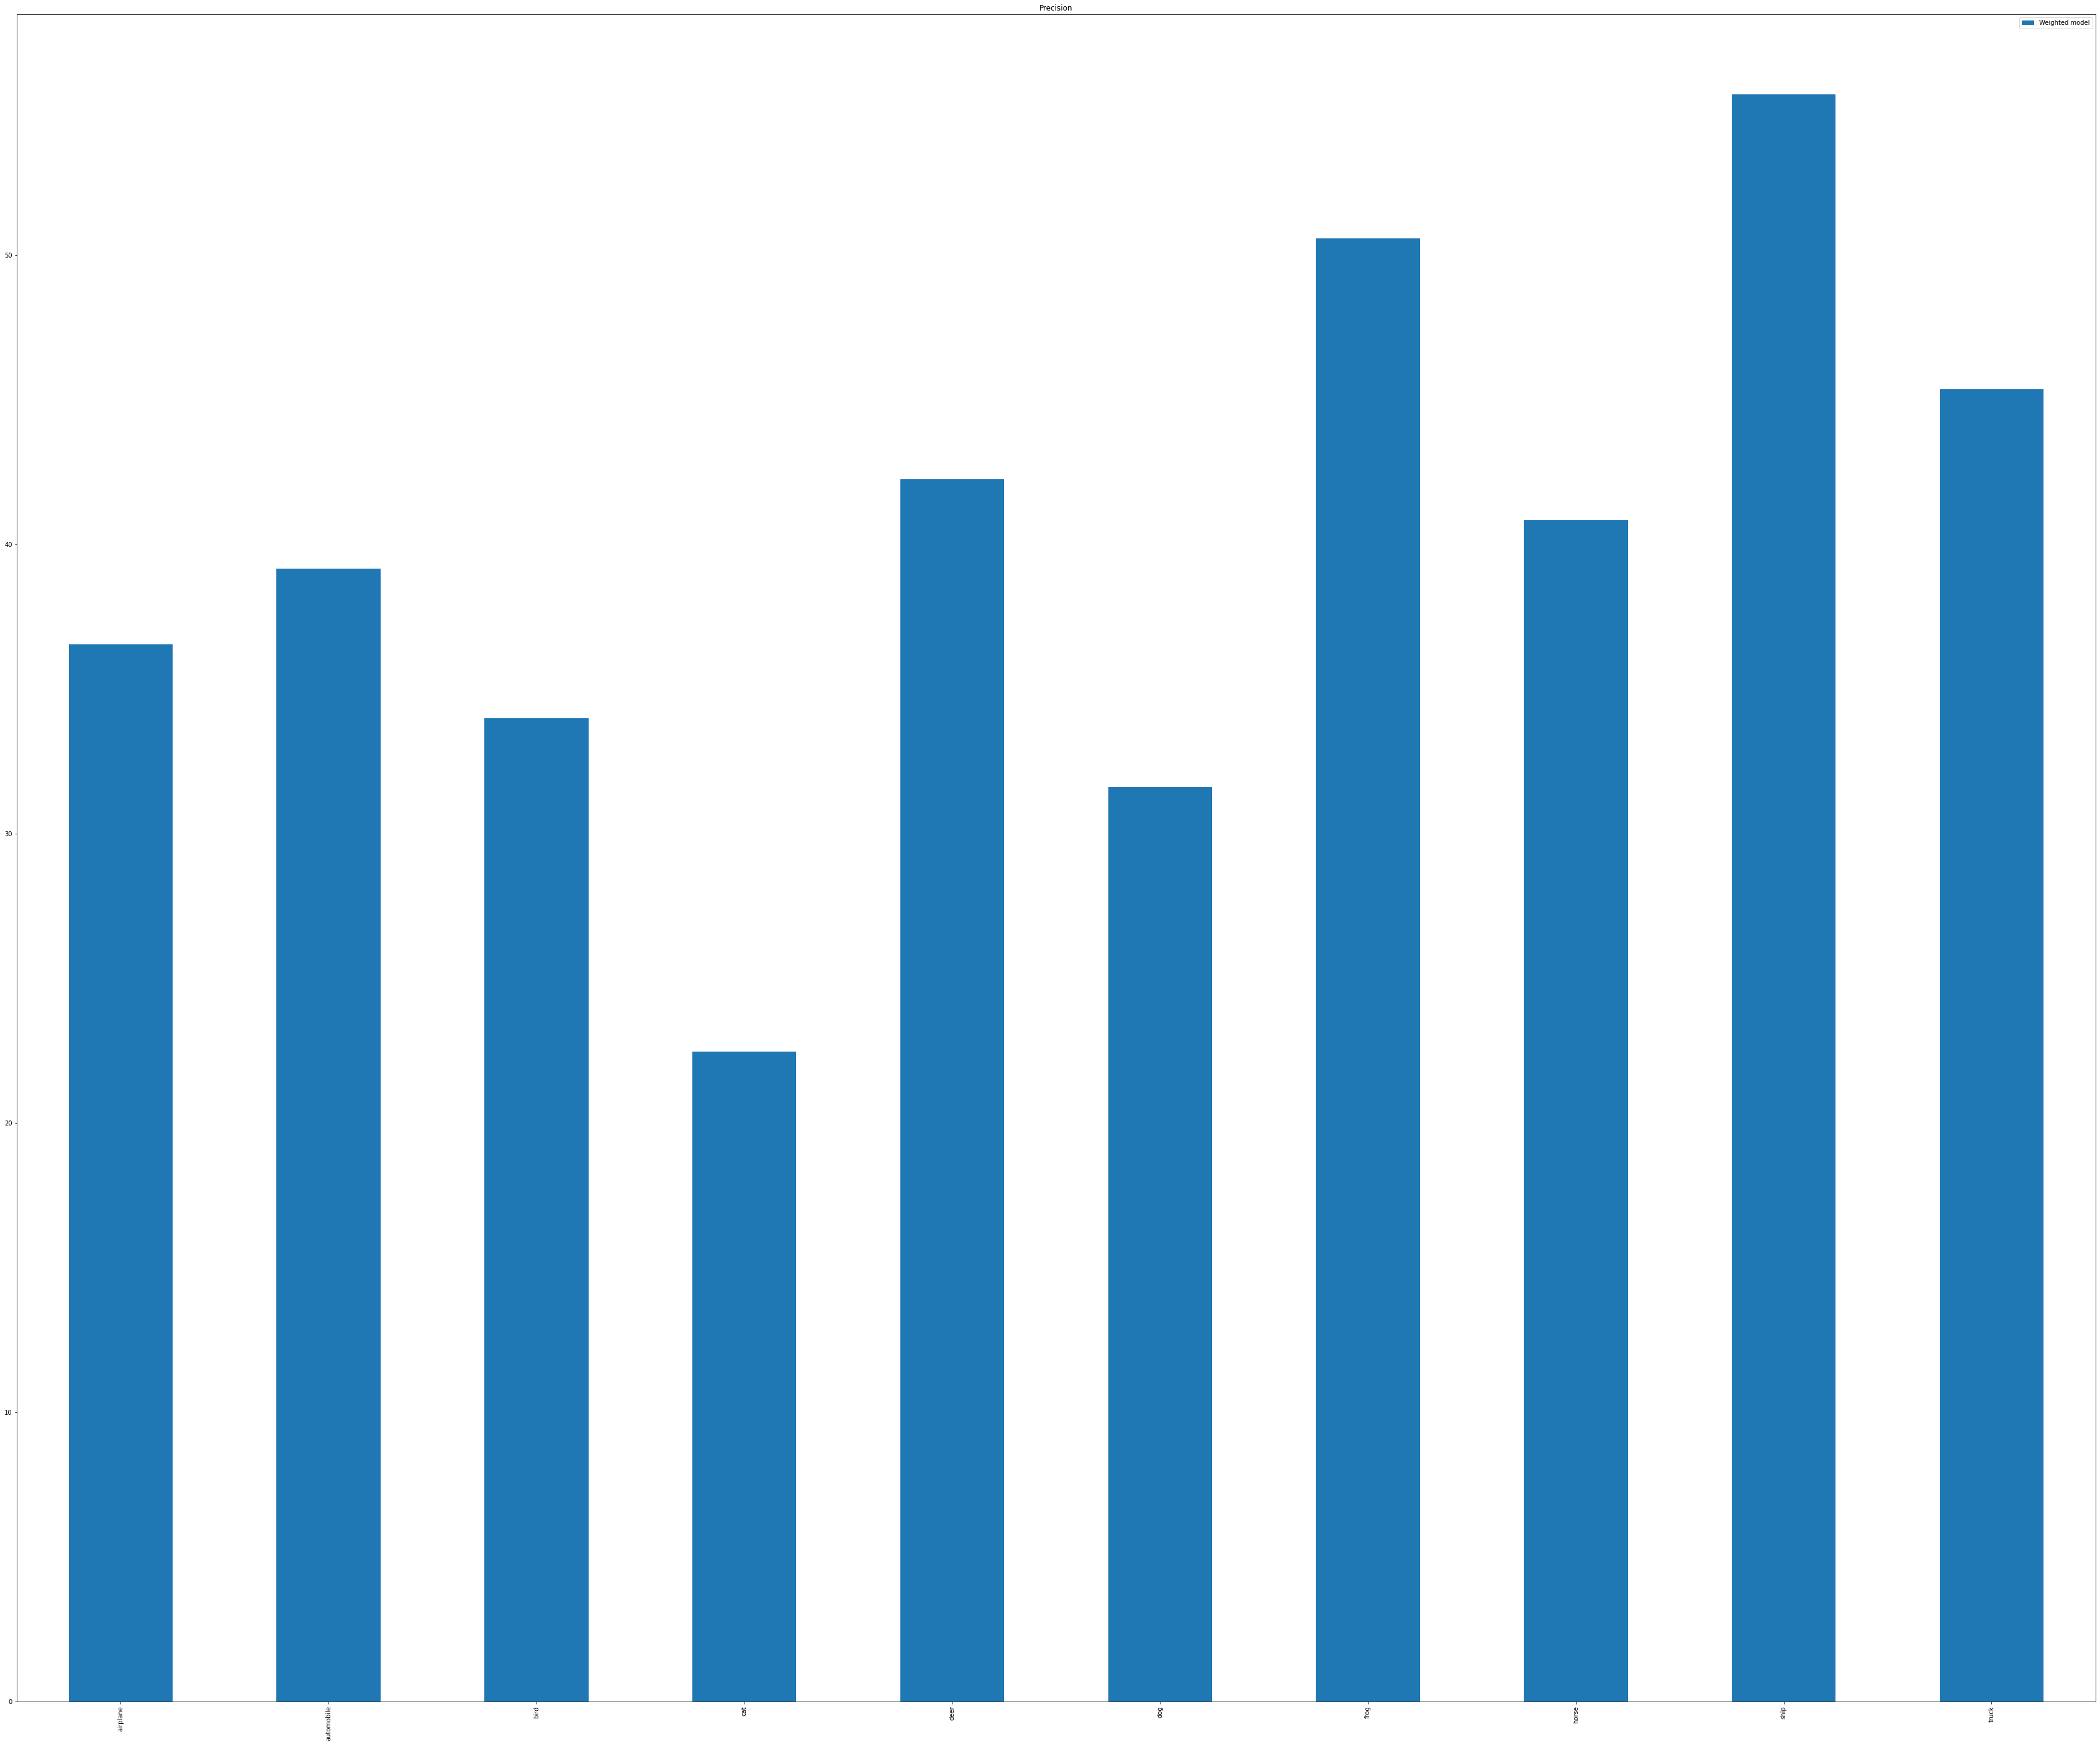

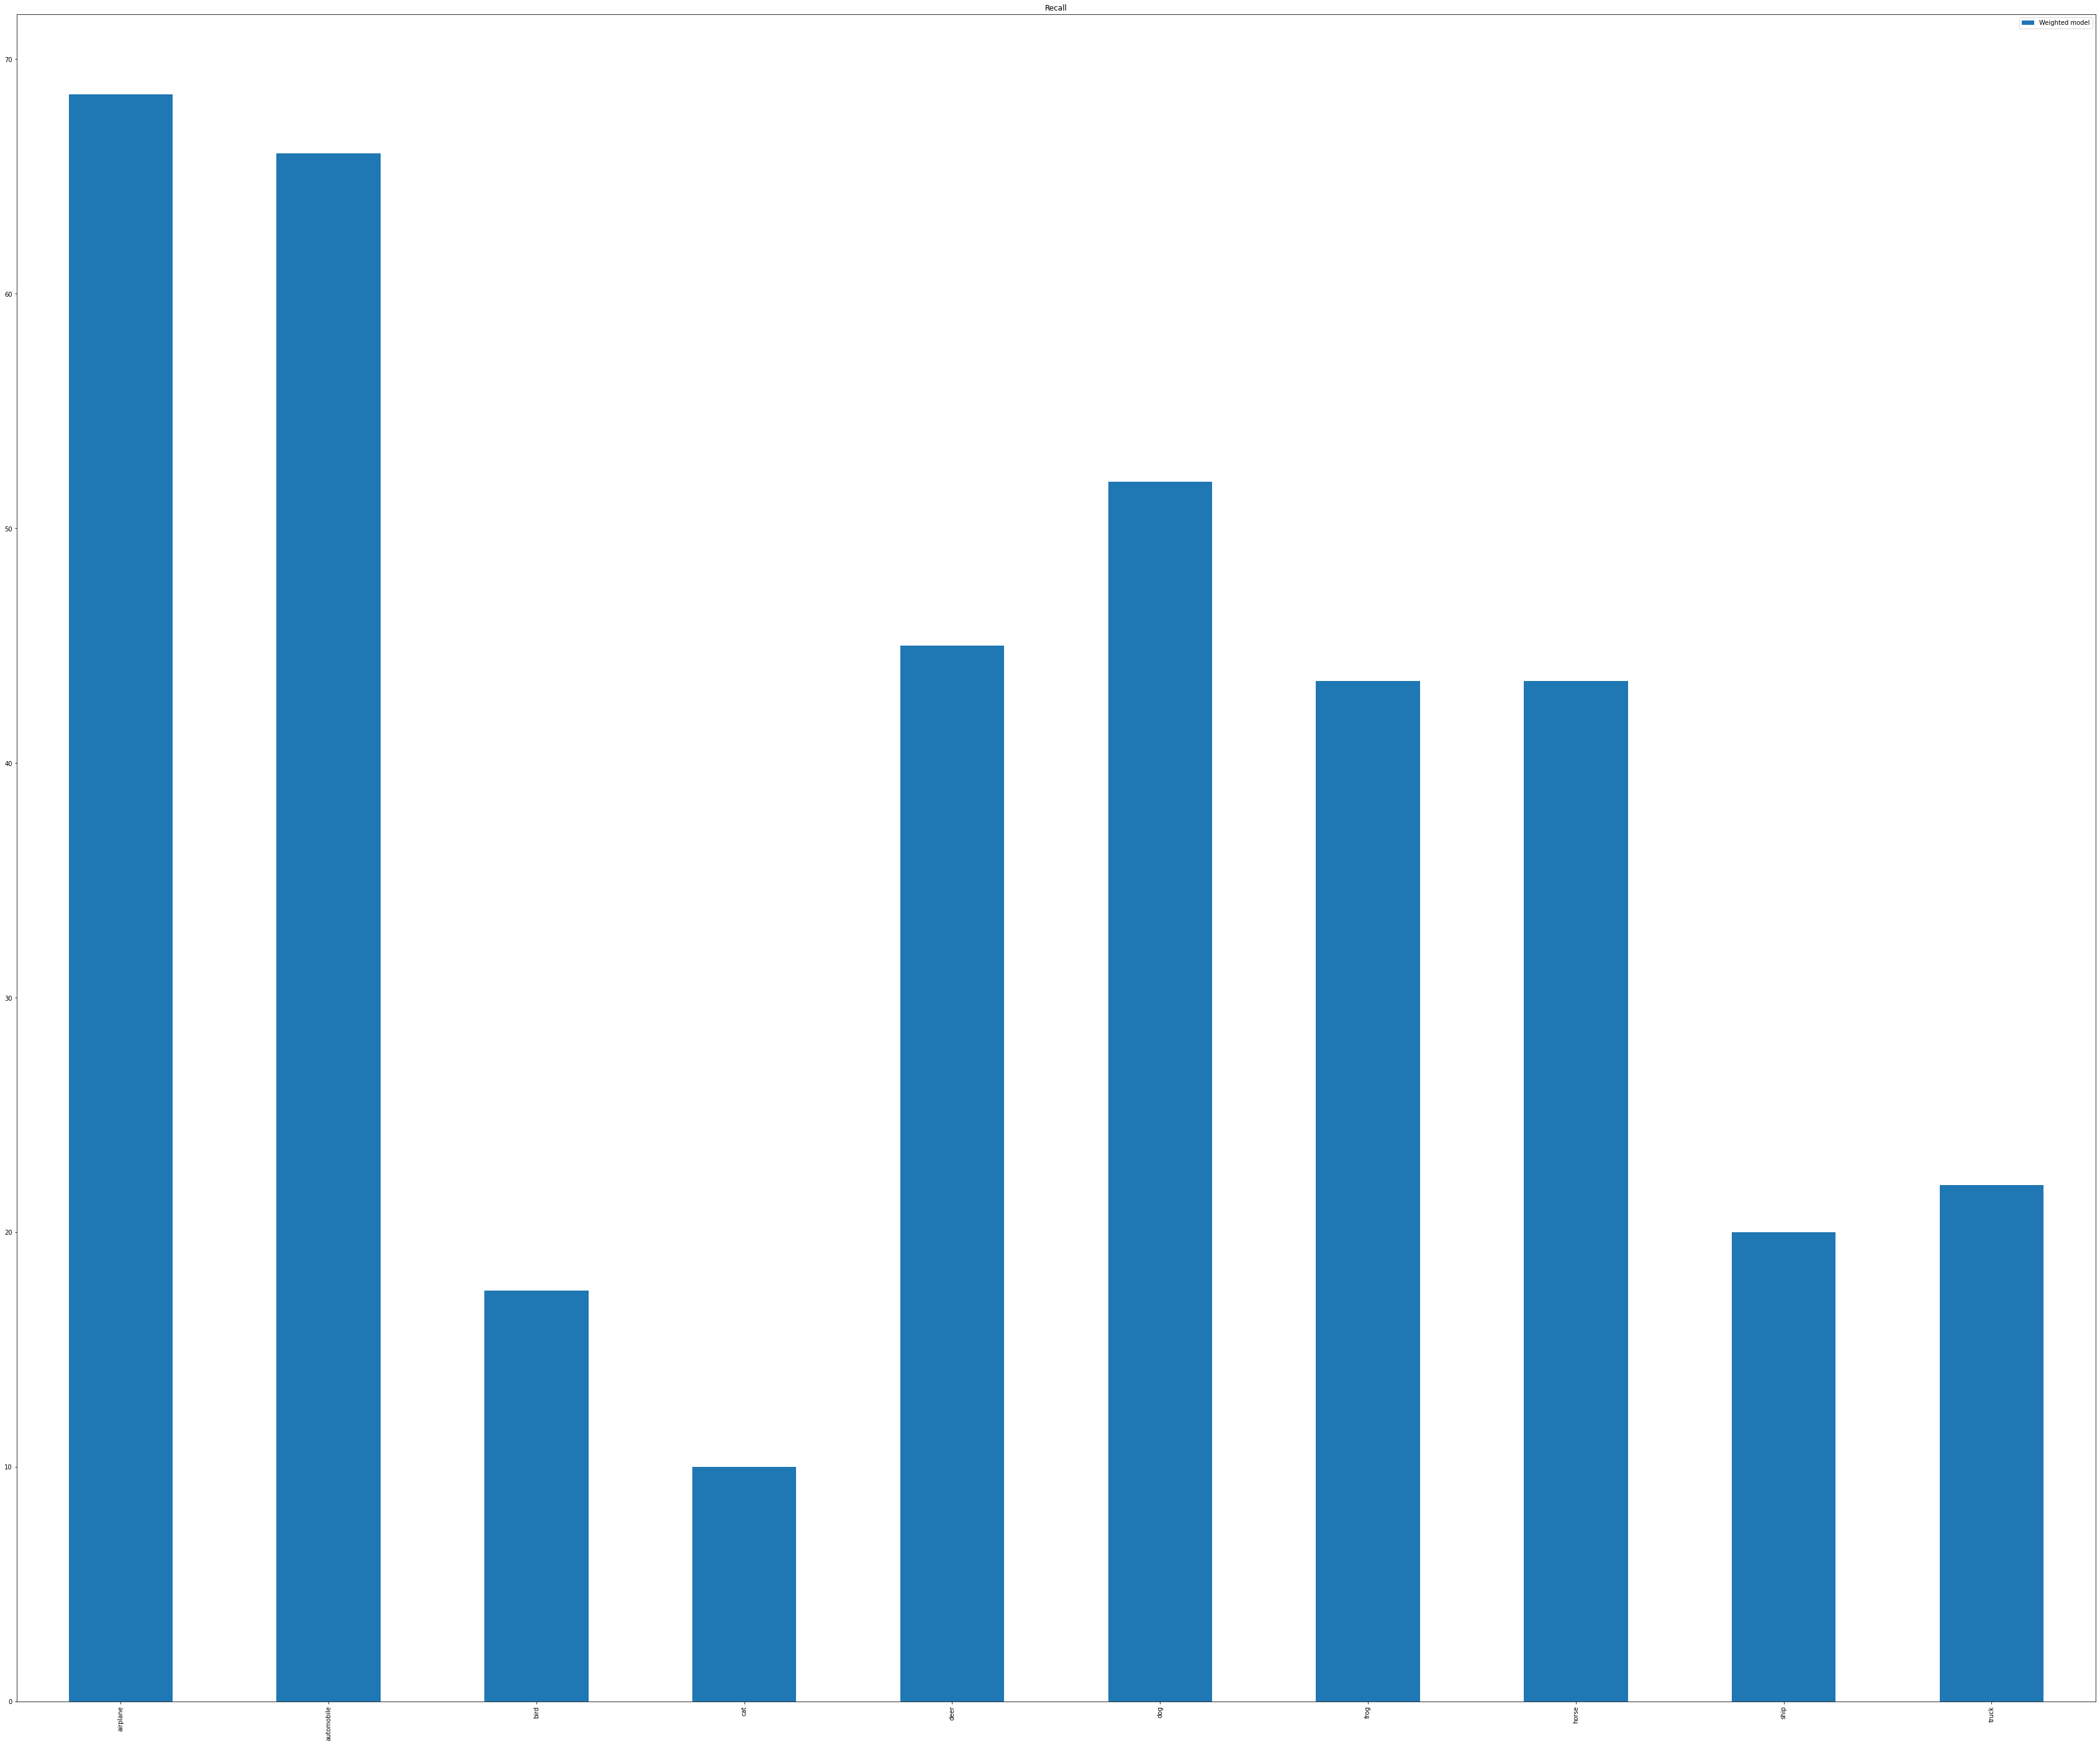

In [ ]:
import matplotlib.pyplot as plt
f1_score, precision,sensitivity=show_results(x_test_c,y_test_c,class_list,finetune_model,history_color_weighted)
plt.rc('font', size=10) 
figure_size=(60,60)
color=plt.cm.Blues
pd.DataFrame(data={"F1 Score":f1_score,"Precision": precision,"Recall":sensitivity}).to_excel(WORKDIR+'/f1_pre_rec_weighted_model.xlsx', index=True)
f1_prec_rec('Weighted model',f1_score,figure_size,"F1 Score")
f1_prec_rec('Weighted model',precision,figure_size,"Precision")
f1_prec_rec('Weighted model',sensitivity,figure_size,"Recall")

## MobileNet Model

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import MobileNet
HEIGHT = 32
WIDTH = 32
base_model = MobileNet(weights=None, 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 1))

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.3

finetune_model = build_finetune_model(base_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))
finetune_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
import matplotlib.pyplot as plt

NUM_EPOCHS = 4
BATCH_SIZE = 32
finetune_model.compile(Adam(learning_rate=3e-4), loss='binary_crossentropy',
                       metrics=['accuracy'])

filepath=os.path.join(WORKDIR, "downstream_comp/Exmodel_weights_cifar10_BASE.h5")
checkpoint = ModelCheckpoint(filepath, monitor=["accuracy"], verbose=1, mode='max')
lrscheduler_callback=LearningRateScheduler(scheduler)
callbacks_list = [checkpoint]

In [ ]:
history_baseline = finetune_model.fit(x_train_c, y_train_c, epochs=NUM_EPOCHS, workers=8, validation_split = 0.2,
                             steps_per_epoch=(x_train_c.shape[0]*0.2)//BATCH_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False, callbacks=callbacks_list)

Epoch 1/4
12/12 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.1068
Epoch 1: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream_comp/Exmodel_weights_cifar10_BASE.h5
12/12 [==============================] - 5s 161ms/step - loss: 0.4112 - accuracy: 0.1068 - val_loss: 0.6757 - val_accuracy: 0.0975
Epoch 2/4
10/12 [========================>.....] - ETA: 0s - loss: 0.3453 - accuracy: 0.1375
Epoch 2: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream_comp/Exmodel_weights_cifar10_BASE.h5
12/12 [==============================] - 1s 65ms/step - loss: 0.3487 - accuracy: 0.1198 - val_loss: 0.6691 - val_accuracy: 0.0950
Epoch 3/4
11/12 [==========================>...] - ETA: 0s - loss: 0.3408 - accuracy: 0.1335
Epoch 3: saving model to /content/drive/MyDrive/IMCOLOR/results/downstream_comp/Exmodel_weights_cifar10_BASE.h5
12/12 [==============================] - 1s 64ms/step - loss: 0.3413 - accuracy: 0.1328 - val_loss: 0.6490 - val_accuracy: 0

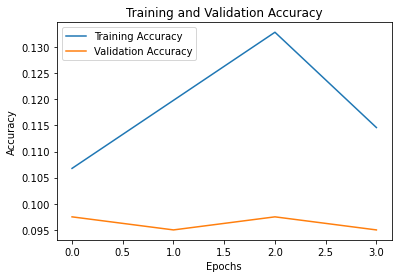

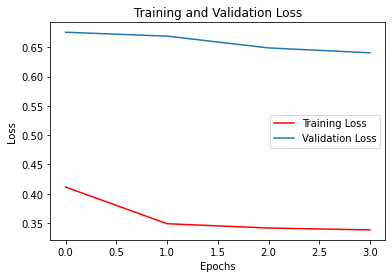

Testing Results
63/63 [==============================] - 1s 5ms/step
Confusion Matrix
[[  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]]


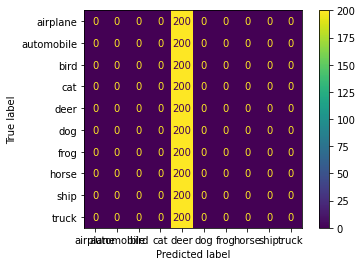

<ipython-input-54-b325a93f2447>:50: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
<ipython-input-54-b325a93f2447>:52: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
<ipython-input-54-b325a93f2447>:58: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


Accuracy:  0.82
F1-Score:  0.01
Sensitivity:  0.1
Specificity:  0.9
Precision:  nan
Negative predictive value:  nan
Fall out:  0.1
False negative rate:  0.9
False discovery rate:  nan
[Testing Completed]


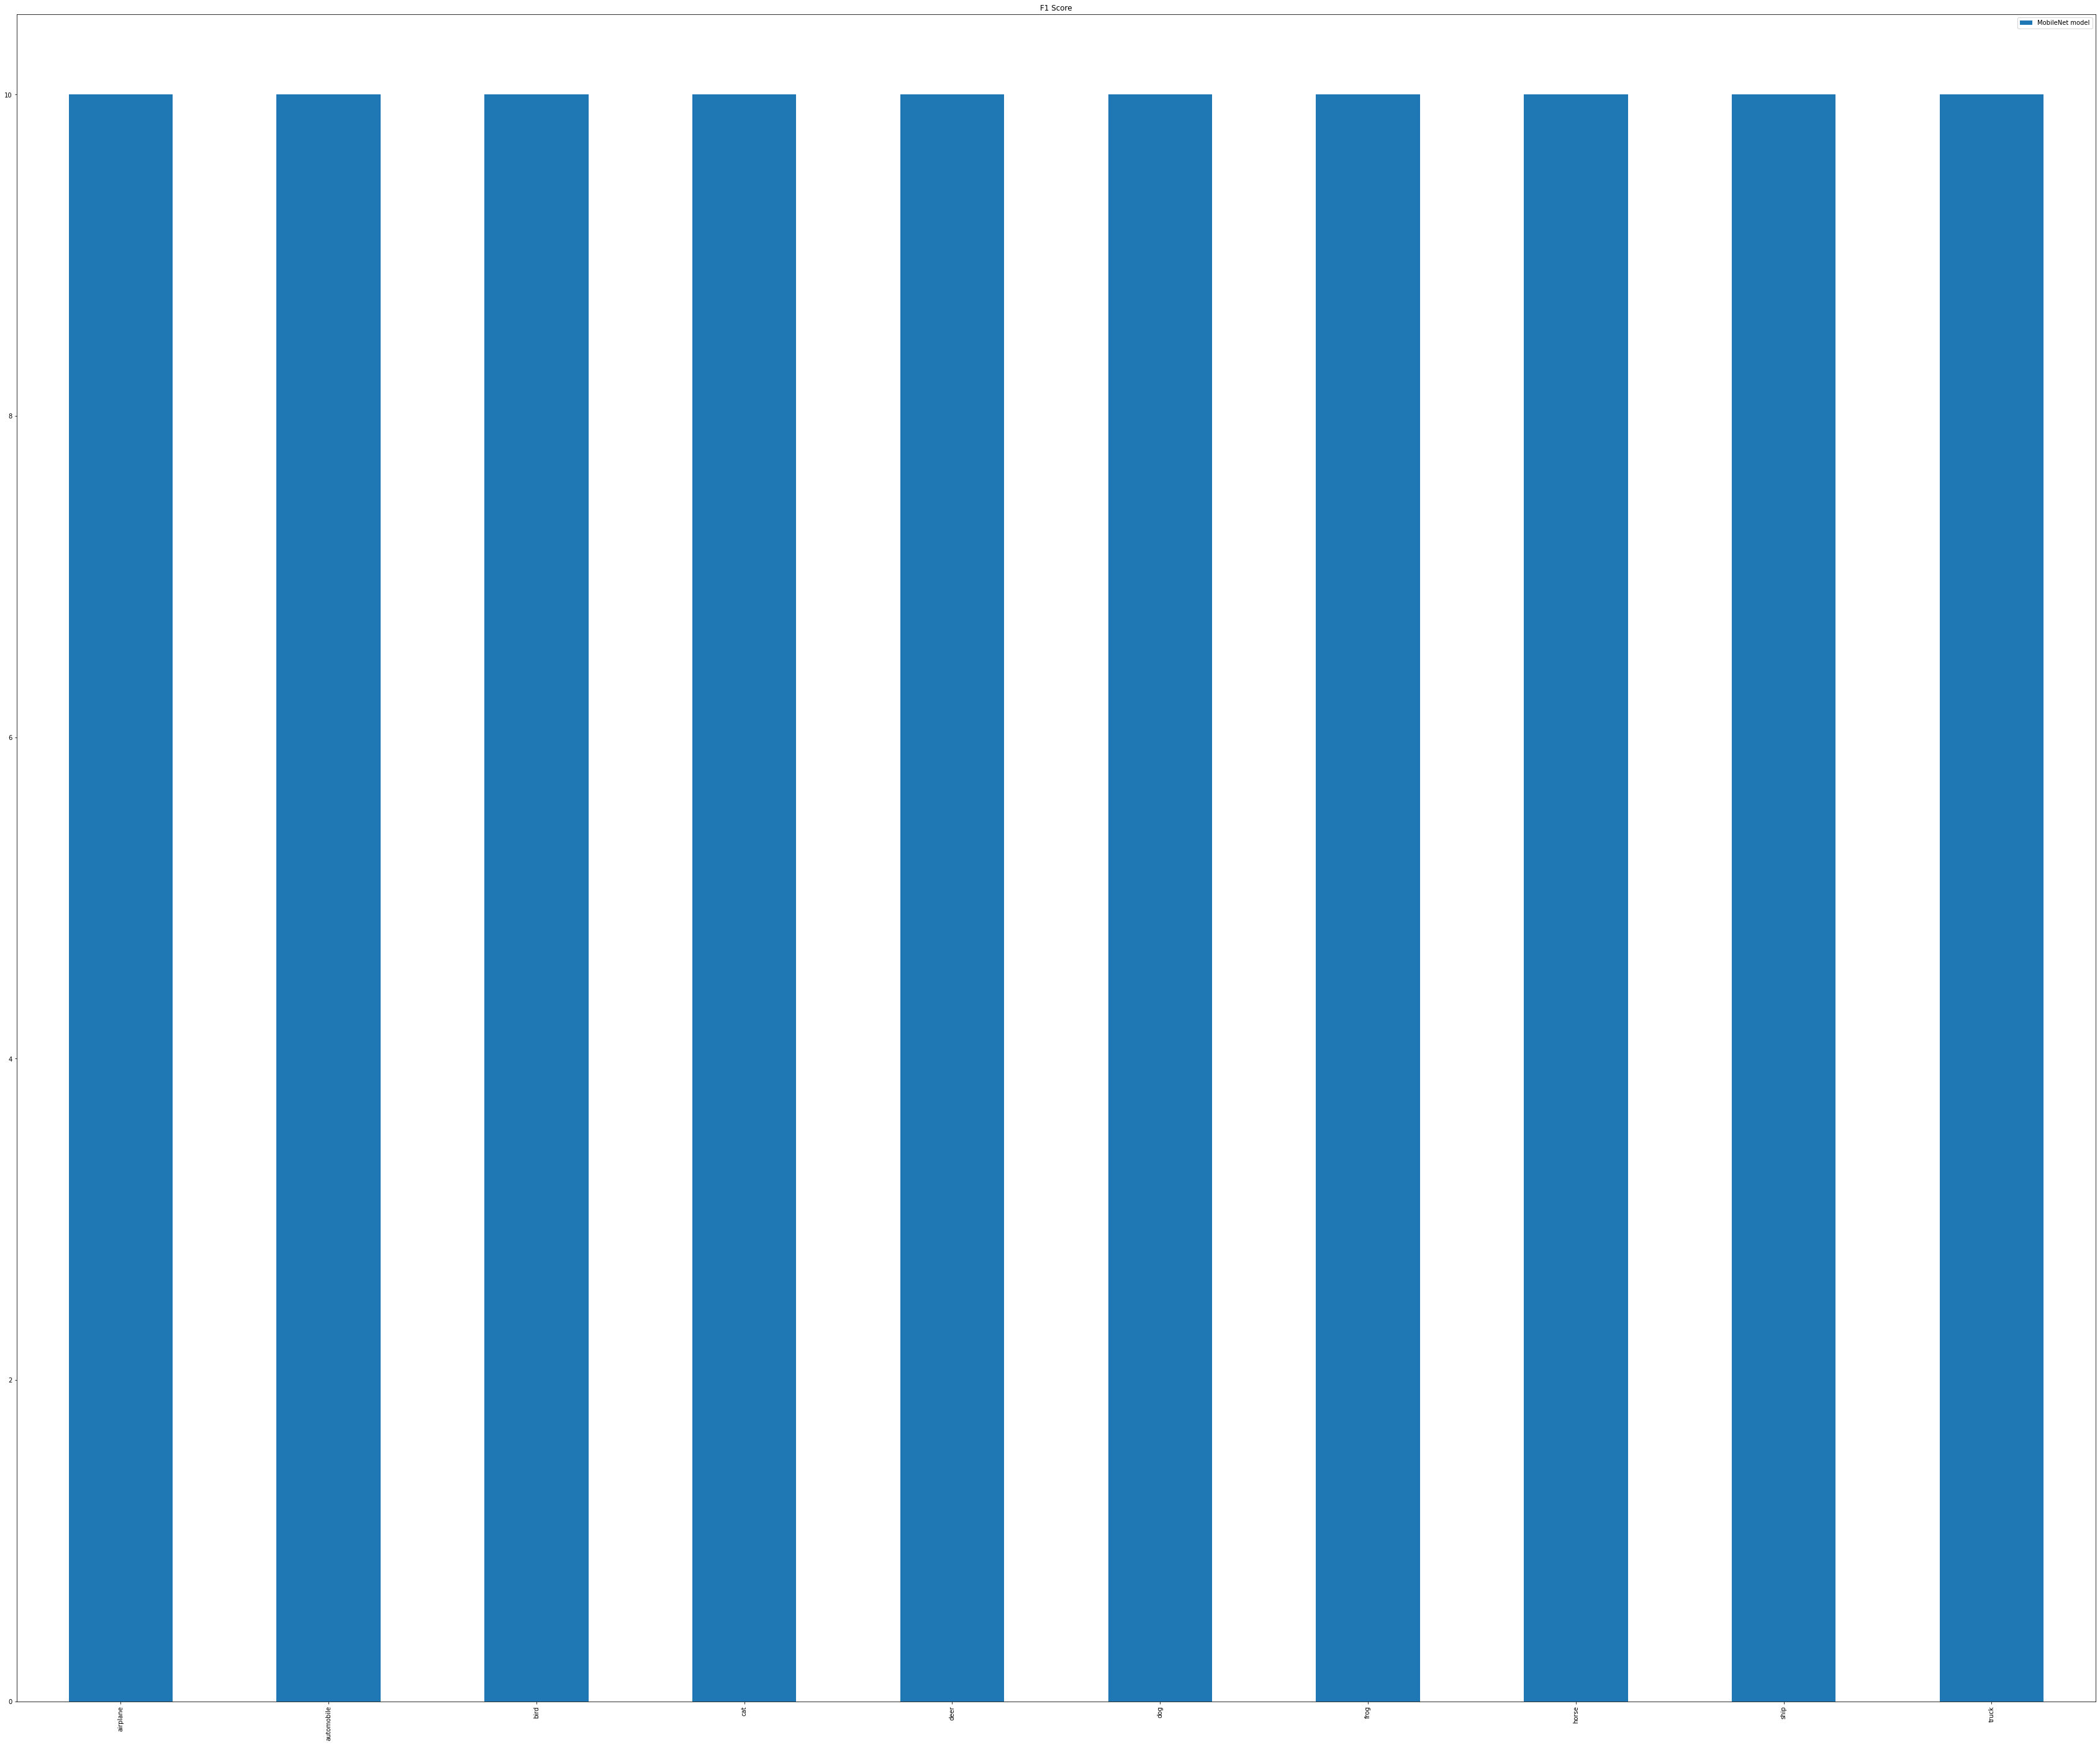

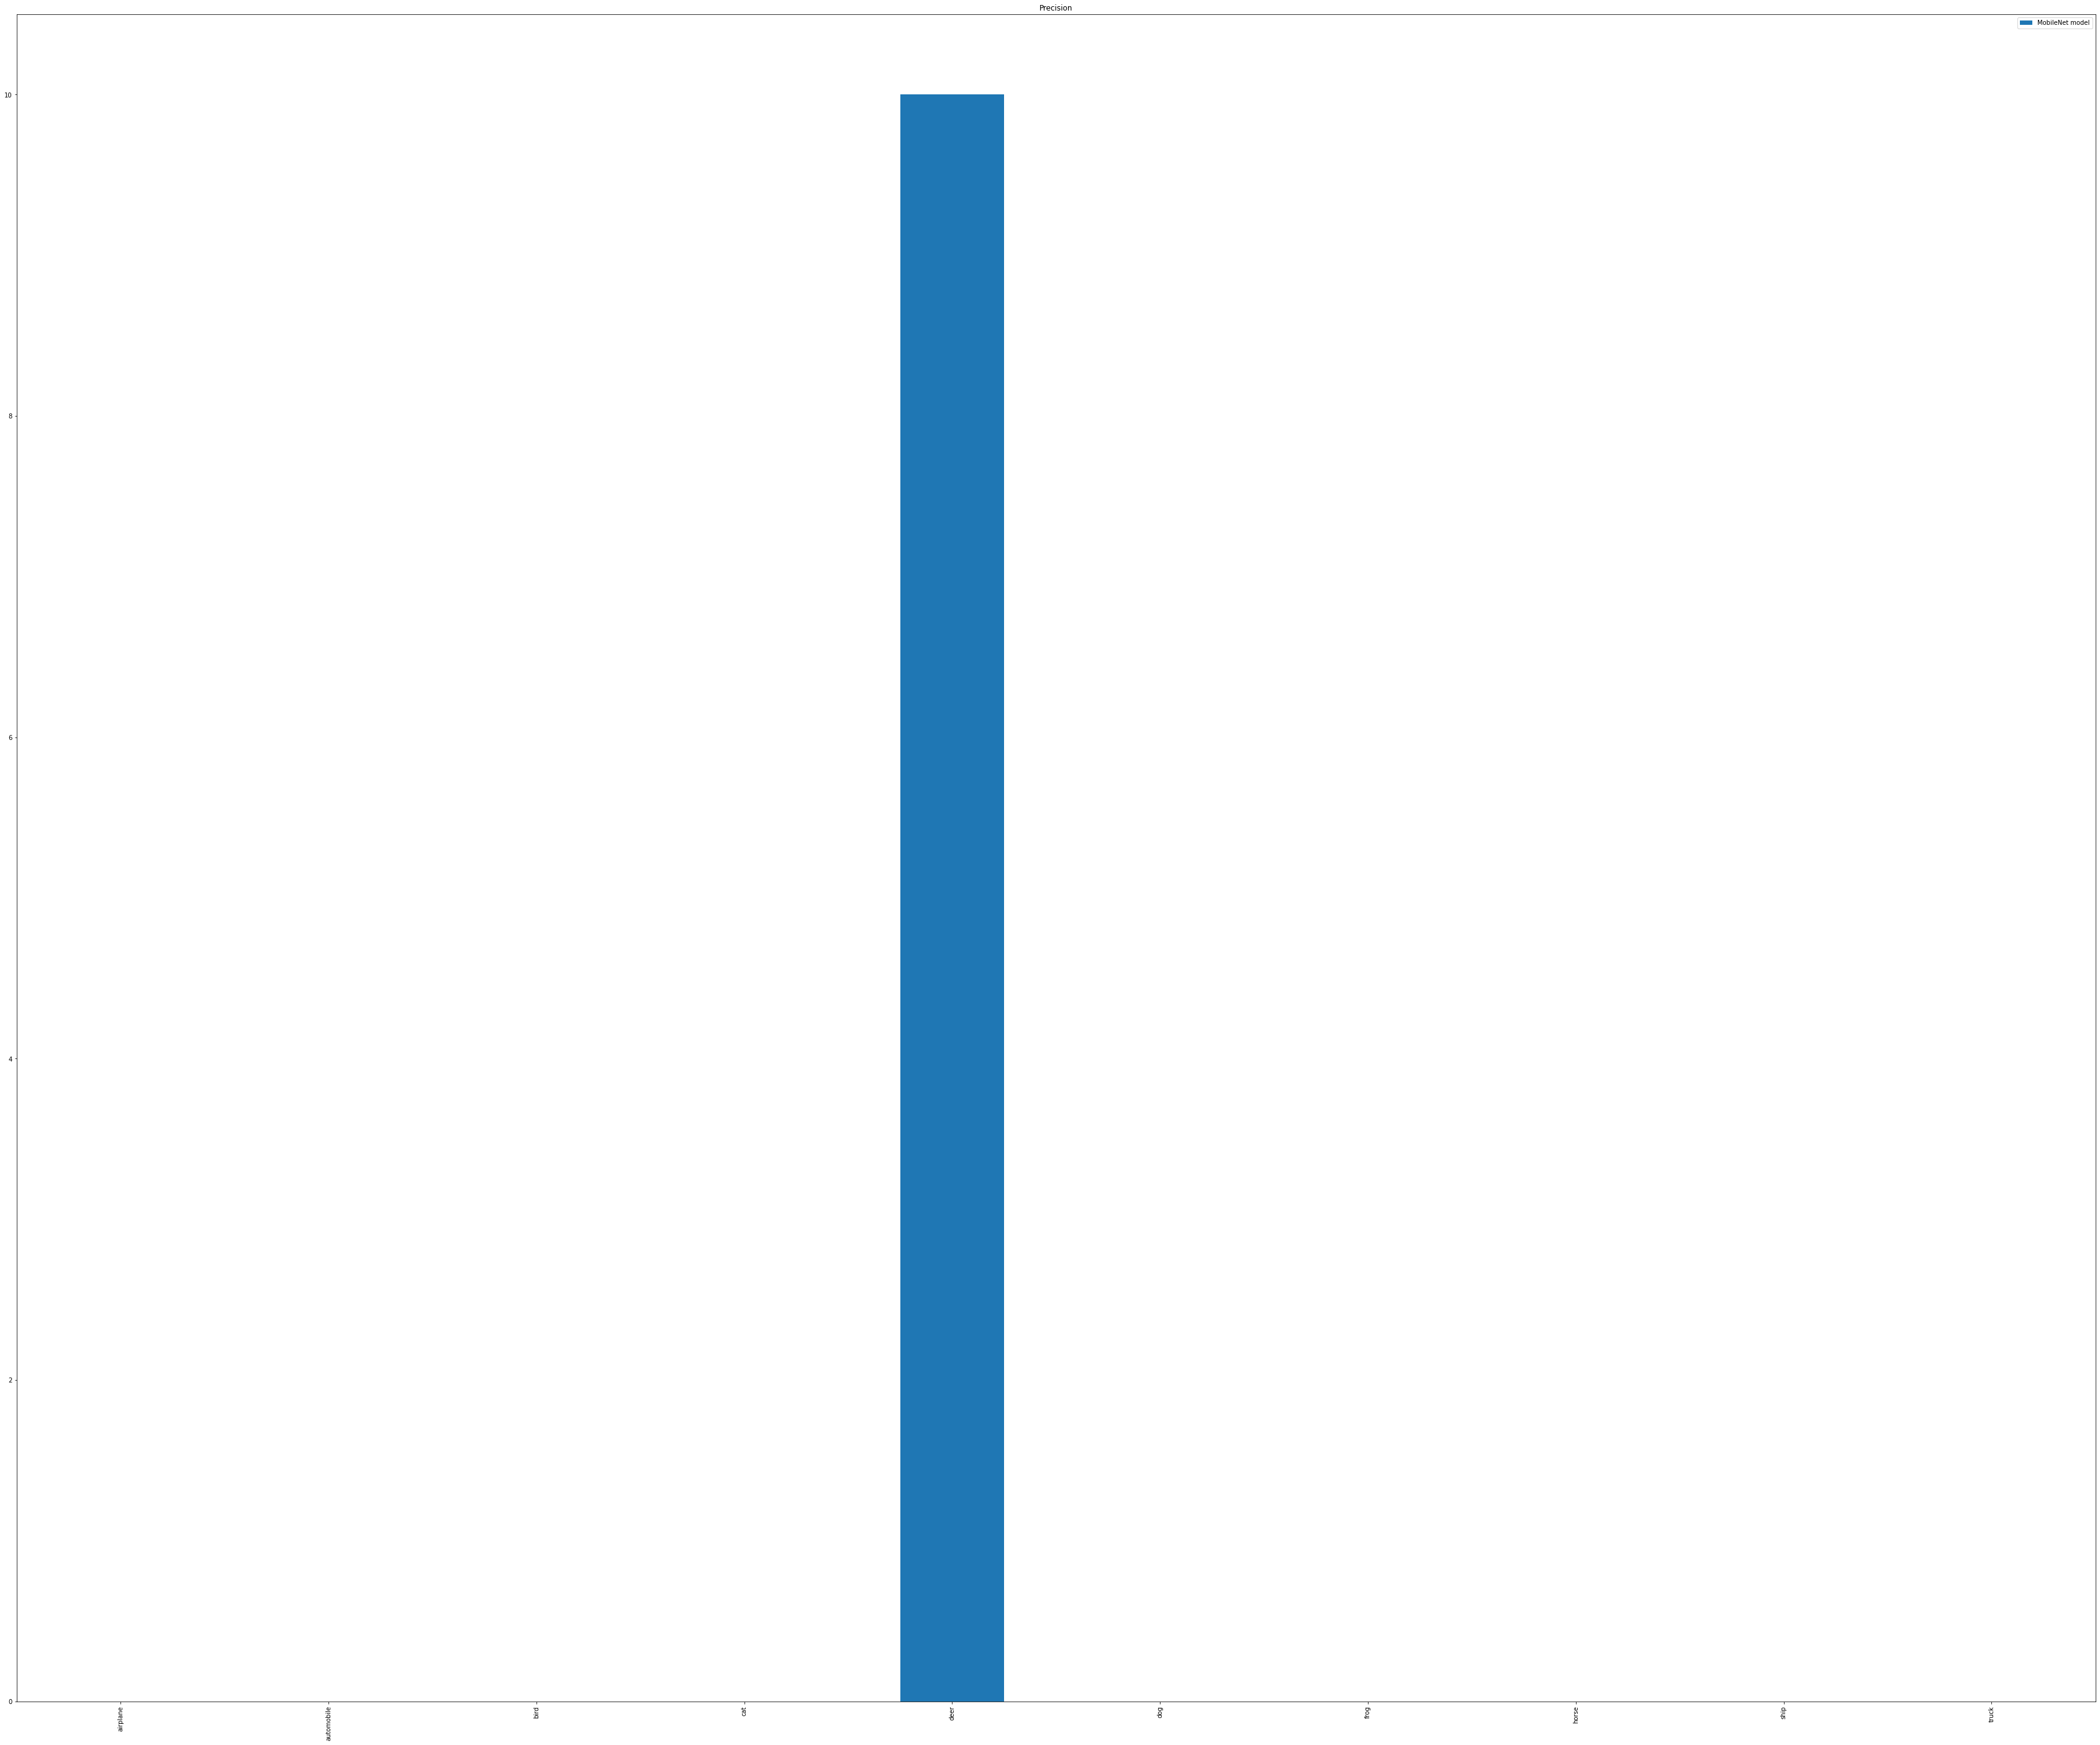

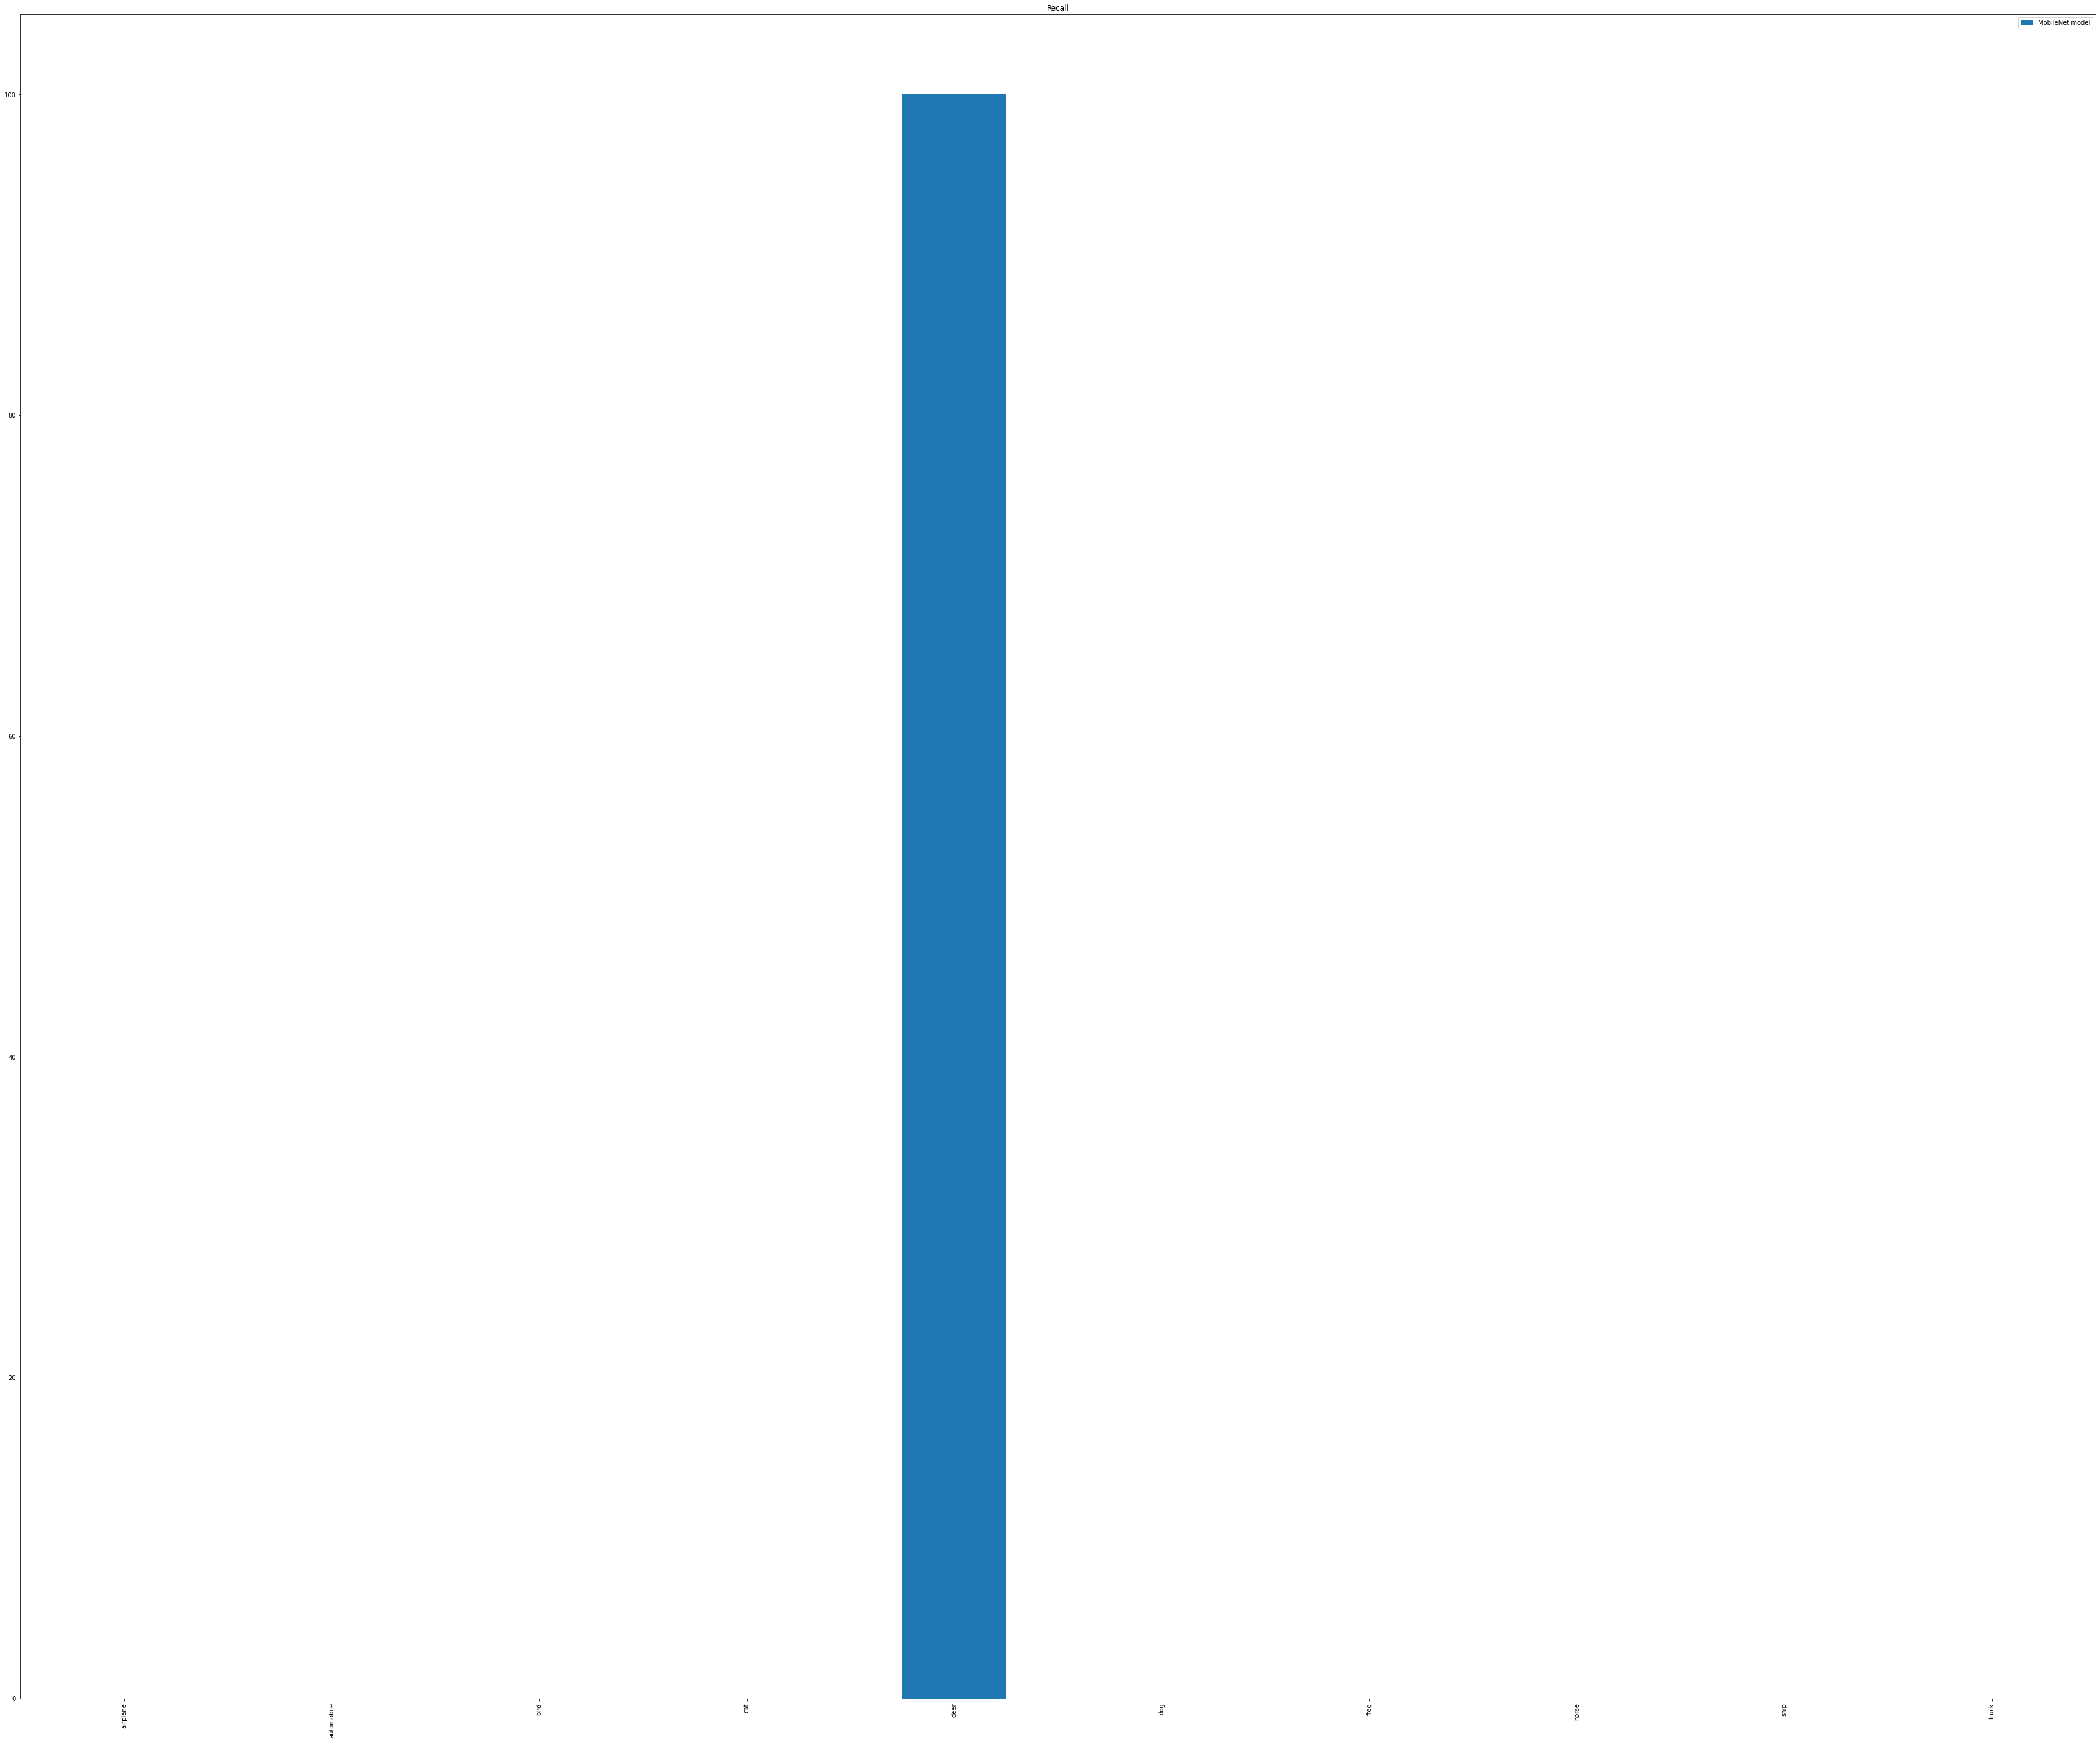

In [ ]:
f1_score, precision,sensitivity=show_results(x_test_c,y_test_c,class_list,finetune_model,history_baseline)
plt.rc('font', size=10) 
figure_size=(60,60)
color=plt.cm.Greens
pd.DataFrame(data={"F1 Score":f1_score,"Precision": precision,"Recall":sensitivity}).to_excel(WORKDIR+'/f1_pre_rec__model.xlsx', index=True)
f1_prec_rec('MobileNet model',f1_score,figure_size,"F1 Score")
f1_prec_rec('MobileNet model',precision,figure_size,"Precision")
f1_prec_rec('MobileNet model',sensitivity,figure_size,"Recall")

# COMPARISON

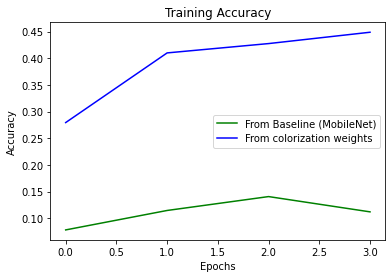

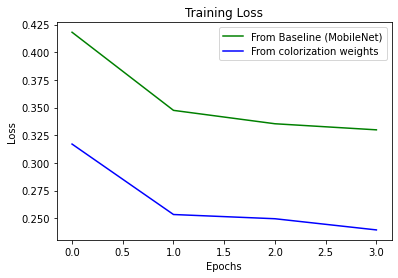

In [ ]:
compare_results(history_color_weighted, history_baseline)

# *THE END*